In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

train = pd.read_csv('smt.csv')
val = pd.read_csv('val.csv')

In [2]:
X_train, X_val = train.iloc[:, :-1].copy(), val.iloc[:, :-1].copy()
y_train, y_val = train.iloc[:, -1].copy(), val.iloc[:, -1].copy()

In [3]:
from pycaret.classification import setup, create_model, tune_model, blend_models, predict_model, finalize_model, save_model

train = pd.concat([X_train, y_train], axis=1).copy()
valid = pd.concat([X_val, y_val], axis=1).copy()

exp_clf = setup(data=train, test_data=valid, target="판정", n_jobs=-1, fold=5, index=False, verbose=False)

In [4]:
# rf = create_model('rf')  
# catboost = create_model('catboost') 
# xgboost = create_model('xgboost')  
# et = create_model('et')
# lightgbm = create_model('lightgbm', verbose=False) 
# top5 = [rf, catboost, xgboost, et, lightgbm]

In [5]:
# tuned_top5 = [tune_model(i, optimize='Accuracy', n_iter=100, choose_better=True) for i in top5]

In [6]:
# import joblib

# save_dir = 'models/'

# # 각 모델을 개별적으로 저장
# for idx, model in enumerate(tuned_top5):
#     model_name = f"tuned_model_{idx + 1}.pkl"  # 모델 이름 지정
#     model_path = save_dir + model_name
#     joblib.dump(model, model_path)  # joblib을 사용해 모델 저장
#     print(f"Model {idx + 1} saved to {model_path}")

In [7]:
# import joblib

# # 저장된 모델 불러와서 tuned_top5 리스트 재구성
# tuned_top5 = []
# for idx in range(1, 6):  # 모델 개수에 따라 조정
#     model_name = f"tuned_model_{idx}.pkl"
#     model_path = 'models/model_save/' + model_name
#     model = joblib.load(model_path)  # 모델 불러오기
#     tuned_top5.append(model)
#     print(f"Model {idx} loaded from {model_path}")

In [8]:
# exp_clf = setup(data=train, test_data=valid, target="판정", n_jobs=1, fold=5, index=False, verbose=False)
# bld_model = blend_models(estimator_list=tuned_top5, fold=5, optimize='Accuracy')

In [9]:
# exp_clf = setup(data=train, test_data=valid, target="판정", n_jobs=-1, fold=5, index=False, verbose=False)
# final_rf = finalize_model(estimator=bld_model)
# save_model(model=final_rf,
#            model_name='models/final_rf_bld_acc',
#            verbose=False)

In [10]:
import joblib
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='LightGBM')

final_rf = joblib.load('models/model_save/final_rf_bld_acc.pkl')

def set_lightgbm_verbose(pipeline, verbose_value=-1):
    for step_name, step in pipeline.named_steps.items():
        if isinstance(step, VotingClassifier):
            # VotingClassifier 내부 모델들에 접근
            for model_name, model in step.estimators:
                if isinstance(model, LGBMClassifier):
                    model.set_params(verbosity=verbose_value)
        elif hasattr(step, 'steps'):  # 중첩된 pipeline이 있는 경우
            for nested_step_name, nested_step in step.steps:
                if isinstance(nested_step, LGBMClassifier):
                    nested_step.set_params(verbosity=verbose_value)

# 파이프라인의 LightGBM 모델에 대해 verbose 설정 변경
set_lightgbm_verbose(final_rf, verbose_value=-100)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9958,1.0000,1.0000,0.9957,0.9979,0.8904,0.8958


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


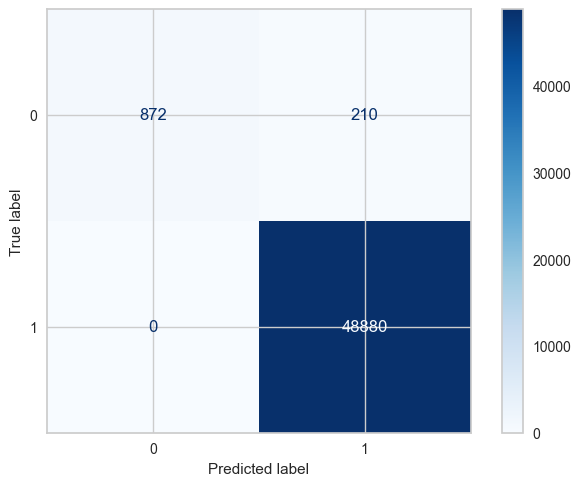

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = predict_model(final_rf)['prediction_label']

cm = confusion_matrix(y_val, y_pred)

# 혼돈 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [12]:
import optuna
import numpy as np
from scipy.stats import truncnorm

# 데이터 수정 함수
def modify_data_based_on_bounds(valid_features, bounds):
    '''
    bounds: '캡간_op_20': (10시그마 적용한 new 상한, 10시그마 적용한 new 하한) # 디테일하게, 상한 하한이 아닌 더해야 할 값.
    '''
    
    def sample_from_bounds(bounds, size):
        samples = {}
        # 새로운 상한 하한을 구함.
        for col, (plus_sigma, minus_sigma) in bounds.items():
            plus_sigma, minus_sigma = plus_sigma*1000, minus_sigma*1000
            mean = (plus_sigma + minus_sigma) / 2
            std_dev = (plus_sigma - minus_sigma) / 4
            
            a, b = minus_sigma, plus_sigma
            samples[col] = truncnorm.rvs(a, b, loc=mean, scale=std_dev, size=size)/1000
            # samples[col] = np.random.uniform(a, b, size=size)
            
            # # 중앙값이 0에 가까운 분포 생성
            # plus_samples = truncnorm.rvs(0, plus_sigma, loc=0, scale=plus_sigma / 4, size=size)  # plus_sigma는 양수 범위
            # minus_samples = truncnorm.rvs(minus_sigma, 0, loc=0, scale=abs(minus_sigma) / 4, size=size)  # minus_sigma는 음수 범위
            
            # mix_ratio = abs(plus_sigma) / (abs(plus_sigma) + abs(minus_sigma))
            
            # # 랜덤하게 선택: mix_ratio에 따라 plus 또는 minus에서 샘플 선택
            # choice_mask = np.random.rand(size) < mix_ratio
            # mixed_samples = np.where(choice_mask, plus_samples, minus_samples)
        
        return samples
    
    sampled_values = sample_from_bounds(bounds, size=len(valid_features))
    
    X_valid_copy = valid_features.copy()
    for col, value in sampled_values.items():
        X_valid_copy[col] += value

    return X_valid_copy

In [13]:
# 목적 함수 정의

trial_bounds = []
def objective(trial):
    global trial_bounds
    
    bounds = {}
    for op in ['_op_20', '_op_30']: # op20 op30
        for var in ['캡간', '전장', '거리']: # 캡간 전장 거리
            target_col = var + op
            if target_col != '거리_op_20' and target_col != '전장_op_20':
                sd = X_train[target_col].std()
                
                ten_sd = 5 * sd
                m_ten_sd = -5 * sd
                high = max(ten_sd, m_ten_sd)
                low = min(ten_sd, m_ten_sd)
                
                upper_new = trial.suggest_float(target_col+'_상한_new', high=high, low=0)
                lower_new = trial.suggest_float(target_col+'_하한_new', high=0, low=low)       
            
                bounds[var+op] = (upper_new, lower_new)

    trial_bounds.append(bounds)
    
    upper = []
    lower = []
    for item in trial_bounds[-1].items():
        for i, val in enumerate(item):
            if i % 2 != 0:
                upper.append(val[0])
                lower.append(val[1])
                
    # 조정된 상한/하한 값을 사용하여 데이터 수정
    modified_val_features = modify_data_based_on_bounds(X_val, bounds)
    
    # 검증 데이터에 대한 합격률 평가
    predictions = predict_model(final_rf, data=modified_val_features)['prediction_label']
    acceptance_rate = 1 - (sum(predictions) / len(predictions))
    
    return acceptance_rate, upper[0], upper[1], upper[2], upper[3], lower[0], lower[1], lower[2], lower[3]

In [14]:
# Optuna를 통한 상한/하한 최적화
from optuna.samplers import NSGAIIISampler, NSGAIISampler

study = optuna.create_study(sampler=NSGAIISampler(), directions=["minimize", "maximize", "maximize", "maximize", "maximize", "minimize", "minimize", "minimize", "minimize"])
study.optimize(objective, n_trials=1000)

# 최적의 상한/하한 값 확인
print("Best trial len:", len(study.best_trials))
print("Best trial:", study.best_trials[0].params)

[I 2024-11-15 10:45:23,799] A new study created in memory with name: no-name-ca7ec777-8902-4c69-b5ca-e86e2a0e91b0


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:24,446] Trial 0 finished with values: [0.05886473720027219, 0.4539626218042858, 1.6717354572847523, 3.913290910018994, 0.04345788026877294, -0.23633388193192684, -0.06400489296341272, -1.788897137170057, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.4539626218042858, '캡간_op_20_하한_new': -0.23633388193192684, '캡간_op_30_상한_new': 1.6717354572847523, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 3.913290910018994, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:25,055] Trial 1 finished with values: [0.19158560505984545, 0.7983925068266625, 1.8072375903054616, 4.441038056590769, 0.002910057367596835, -0.7634048031775691, -1.0760685630037474, -6.930719090510018, -0.007742172647094432] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.7634048031775691, '캡간_op_30_상한_new': 1.8072375903054616, '캡간_op_30_하한_new': -1.0760685630037474, '전장_op_30_상한_new': 4.441038056590769, '전장_op_30_하한_new': -6.930719090510018, '거리_op_30_상한_new': 0.002910057367596835, '거리_op_30_하한_new': -0.007742172647094432}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:25,680] Trial 2 finished with values: [0.10105680317040955, 0.6247374043554307, 1.447196614990143, 4.421429574084976, 0.01387923960357136, -0.2839445589276868, -1.2994300732868296, -2.0959282345895733, -0.008589486776110773] and parameters: {'캡간_op_20_상한_new': 0.6247374043554307, '캡간_op_20_하한_new': -0.2839445589276868, '캡간_op_30_상한_new': 1.447196614990143, '캡간_op_30_하한_new': -1.2994300732868296, '전장_op_30_상한_new': 4.421429574084976, '전장_op_30_하한_new': -2.0959282345895733, '거리_op_30_상한_new': 0.01387923960357136, '거리_op_30_하한_new': -0.008589486776110773}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:26,320] Trial 3 finished with values: [0.14346903646771547, 0.21983840206639296, 0.6803238753709784, 4.329523416993282, 0.0394479384794932, -0.4970011329625339, -0.3517803767577048, -6.564751919973721, -0.03238509113028768] and parameters: {'캡간_op_20_상한_new': 0.21983840206639296, '캡간_op_20_하한_new': -0.4970011329625339, '캡간_op_30_상한_new': 0.6803238753709784, '캡간_op_30_하한_new': -0.3517803767577048, '전장_op_30_상한_new': 4.329523416993282, '전장_op_30_하한_new': -6.564751919973721, '거리_op_30_상한_new': 0.0394479384794932, '거리_op_30_하한_new': -0.03238509113028768}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:26,901] Trial 4 finished with values: [0.18882350586445695, 0.5838283978822493, 0.6897342107807409, 1.9550543604604826, 0.03103517182776997, -0.2197611679823379, -0.904361492968581, -5.0377174173317725, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.5838283978822493, '캡간_op_20_하한_new': -0.2197611679823379, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -0.904361492968581, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -5.0377174173317725, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:27,480] Trial 5 finished with values: [0.10548016492534329, 0.4722494334577548, 0.0928086320111762, 4.8820539188966885, 0.018181545073110216, -0.669384465647284, -1.1486264162055144, -6.227486770782223, -0.03905834203678397] and parameters: {'캡간_op_20_상한_new': 0.4722494334577548, '캡간_op_20_하한_new': -0.669384465647284, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.8820539188966885, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.018181545073110216, '거리_op_30_하한_new': -0.03905834203678397}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:28,248] Trial 6 finished with values: [0.027100596453304537, 0.8707931943123146, 1.6525481055269269, 6.766096948456381, 0.006430426868531781, -0.15389522371058462, -2.205380489997569, -1.2008595762678693, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.15389522371058462, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -1.2008595762678693, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:29,063] Trial 7 finished with values: [0.05852447860373888, 0.48055356874435956, 1.4835561612078259, 6.094496405224102, 0.03701127374436278, -0.8259258218216867, -1.3867147146004781, -2.8322601256295785, -0.02998651296066497] and parameters: {'캡간_op_20_상한_new': 0.48055356874435956, '캡간_op_20_하한_new': -0.8259258218216867, '캡간_op_30_상한_new': 1.4835561612078259, '캡간_op_30_하한_new': -1.3867147146004781, '전장_op_30_상한_new': 6.094496405224102, '전장_op_30_하한_new': -2.8322601256295785, '거리_op_30_상한_new': 0.03701127374436278, '거리_op_30_하한_new': -0.02998651296066497}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:29,929] Trial 8 finished with values: [0.07175453344541849, 0.08790058348647, 1.1328989098155096, 5.002135072081498, 0.011314507323920153, -0.17946908112188742, -1.9323069317496246, -1.0509740936277012, -0.014684855616418808] and parameters: {'캡간_op_20_상한_new': 0.08790058348647, '캡간_op_20_하한_new': -0.17946908112188742, '캡간_op_30_상한_new': 1.1328989098155096, '캡간_op_30_하한_new': -1.9323069317496246, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -1.0509740936277012, '거리_op_30_상한_new': 0.011314507323920153, '거리_op_30_하한_new': -0.014684855616418808}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:30,542] Trial 9 finished with values: [0.08506464913334133, 0.7848340787214946, 1.5015864825412084, 5.063342905073503, 0.008685904697579135, -0.03998270682947036, -0.2023897053241437, -5.475378467847565, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:31,312] Trial 10 finished with values: [0.07908010087666628, 0.24846262289629767, 1.1006715951827186, 1.6991382914116246, 0.01039993584061645, -0.3641446372919792, -1.2585844170124283, -0.48147384468517185, -0.010924808687889698] and parameters: {'캡간_op_20_상한_new': 0.24846262289629767, '캡간_op_20_하한_new': -0.3641446372919792, '캡간_op_30_상한_new': 1.1006715951827186, '캡간_op_30_하한_new': -1.2585844170124283, '전장_op_30_상한_new': 1.6991382914116246, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.01039993584061645, '거리_op_30_하한_new': -0.010924808687889698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:32,115] Trial 11 finished with values: [0.17555342059965573, 0.12191699219533794, 0.1433743334052247, 2.534988872392914, 0.0007262690945668039, -0.7748991139714614, -0.14709211334682282, -2.8701589780852332, -0.004105241352784152] and parameters: {'캡간_op_20_상한_new': 0.12191699219533794, '캡간_op_20_하한_new': -0.7748991139714614, '캡간_op_30_상한_new': 0.1433743334052247, '캡간_op_30_하한_new': -0.14709211334682282, '전장_op_30_상한_new': 2.534988872392914, '전장_op_30_하한_new': -2.8701589780852332, '거리_op_30_상한_new': 0.0007262690945668039, '거리_op_30_하한_new': -0.004105241352784152}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:32,963] Trial 12 finished with values: [0.07645810816220322, 0.41470517836432963, 1.7799885598916483, 6.589306582386956, 0.0018241587776233988, -0.5026915977428201, -1.80593677670831, -2.0853996159548496, -0.0074038038537275475] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 6.589306582386956, '전장_op_30_하한_new': -2.0853996159548496, '거리_op_30_상한_new': 0.0018241587776233988, '거리_op_30_하한_new': -0.0074038038537275475}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:33,712] Trial 13 finished with values: [0.21210119690965135, 0.3527456997512678, 1.625598493235218, 0.1821957213442736, 0.03278159879719997, -0.20418189462085135, -1.0200982752512193, -6.774105548818217, -0.023208564054920864] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.20418189462085135, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.1821957213442736, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.023208564054920864}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:34,501] Trial 14 finished with values: [0.09489211800968733, 0.8816875400061509, 1.6198447081959817, 5.9015248620868155, 0.044003048880728084, -0.44300749352826385, -1.1072846762543584, -6.788067616942285, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.8816875400061509, '캡간_op_20_하한_new': -0.44300749352826385, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -1.1072846762543584, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.044003048880728084, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:35,334] Trial 15 finished with values: [0.11122453064328885, 0.25069916496467703, 0.4838370395730004, 6.098208237508082, 0.03796046577797478, -0.29567012161581463, -1.7416068955719943, -6.217575469198892, -0.022808182870205133] and parameters: {'캡간_op_20_상한_new': 0.25069916496467703, '캡간_op_20_하한_new': -0.29567012161581463, '캡간_op_30_상한_new': 0.4838370395730004, '캡간_op_30_하한_new': -1.7416068955719943, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.217575469198892, '거리_op_30_상한_new': 0.03796046577797478, '거리_op_30_하한_new': -0.022808182870205133}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:36,112] Trial 16 finished with values: [0.1705896481325807, 0.5244940824495384, 0.2900997803667435, 3.1598800643252907, 0.037376492498266835, -0.12650397144676795, -0.24691680896826562, -4.423650168882929, -0.032938049066378476] and parameters: {'캡간_op_20_상한_new': 0.5244940824495384, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.2900997803667435, '캡간_op_30_하한_new': -0.24691680896826562, '전장_op_30_상한_new': 3.1598800643252907, '전장_op_30_하한_new': -4.423650168882929, '거리_op_30_상한_new': 0.037376492498266835, '거리_op_30_하한_new': -0.032938049066378476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:36,877] Trial 17 finished with values: [0.08300308234258036, 0.3590420335633183, 0.03974419540898267, 0.8278159236058528, 0.00036169901427229525, -0.7579203326567522, -0.39506775131488214, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.3590420335633183, '캡간_op_20_하한_new': -0.7579203326567522, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.39506775131488214, '전장_op_30_상한_new': 0.8278159236058528, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:37,746] Trial 18 finished with values: [0.15627877186661865, 0.1734689594716573, 0.699947203796962, 0.13599369582417176, 0.032320907586862124, -0.7584084768121725, -2.1396996513142685, -3.5292863902511407, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.1734689594716573, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 0.699947203796962, '캡간_op_30_하한_new': -2.1396996513142685, '전장_op_30_상한_new': 0.13599369582417176, '전장_op_30_하한_new': -3.5292863902511407, '거리_op_30_상한_new': 0.032320907586862124, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:38,665] Trial 19 finished with values: [0.040851046795564616, 0.2703863645581731, 1.742794851000502, 1.478996183865933, 0.014658620829777971, -0.7674402480971444, -0.870581774850971, -1.0331293070041419, -0.04348721996057896] and parameters: {'캡간_op_20_상한_new': 0.2703863645581731, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 1.742794851000502, '캡간_op_30_하한_new': -0.870581774850971, '전장_op_30_상한_new': 1.478996183865933, '전장_op_30_하한_new': -1.0331293070041419, '거리_op_30_상한_new': 0.014658620829777971, '거리_op_30_하한_new': -0.04348721996057896}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:39,564] Trial 20 finished with values: [0.23301709299067286, 0.2538301324188659, 0.026664326066657987, 0.2476198870158609, 0.015998168784941445, -0.7397733823551492, -0.4365508237603357, -5.830669560931348, -0.02259473657512226] and parameters: {'캡간_op_20_상한_new': 0.2538301324188659, '캡간_op_20_하한_new': -0.7397733823551492, '캡간_op_30_상한_new': 0.026664326066657987, '캡간_op_30_하한_new': -0.4365508237603357, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.015998168784941445, '거리_op_30_하한_new': -0.02259473657512226}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:40,497] Trial 21 finished with values: [0.14024658740642892, 0.820470515366113, 1.0354601484708292, 3.1328317222517916, 0.022213082940955194, -0.6097161748427586, -1.306003666072996, -4.479082880478158, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.6097161748427586, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.306003666072996, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:41,410] Trial 22 finished with values: [0.06282774908930788, 0.45454767546687336, 1.8999029728260497, 6.2755842585566075, 0.01161362155427711, -0.7537468180055529, -1.5445885220247582, -4.531486290118823, -0.04123316036608367] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.7537468180055529, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 6.2755842585566075, '전장_op_30_하한_new': -4.531486290118823, '거리_op_30_상한_new': 0.01161362155427711, '거리_op_30_하한_new': -0.04123316036608367}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:42,327] Trial 23 finished with values: [0.13300108082142426, 0.4053336567501089, 1.4949710094584803, 0.0984713976061425, 0.028957198406924477, -0.5678228781228554, -0.9836846115771669, -1.6434016856767997, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.4053336567501089, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.4949710094584803, '캡간_op_30_하한_new': -0.9836846115771669, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -1.6434016856767997, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:43,227] Trial 24 finished with values: [0.15297626195908887, 0.8217624822633371, 1.524584522967632, 2.5131320204346235, 0.003352826065912028, -0.6437818838366207, -1.0014389097982317, -6.167947134831903, -0.031280965040866165] and parameters: {'캡간_op_20_상한_new': 0.8217624822633371, '캡간_op_20_하한_new': -0.6437818838366207, '캡간_op_30_상한_new': 1.524584522967632, '캡간_op_30_하한_new': -1.0014389097982317, '전장_op_30_상한_new': 2.5131320204346235, '전장_op_30_하한_new': -6.167947134831903, '거리_op_30_상한_new': 0.003352826065912028, '거리_op_30_하한_new': -0.031280965040866165}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:44,078] Trial 25 finished with values: [0.05161923061526763, 0.17274686871057143, 1.7218991650831494, 3.33014668656309, 0.0015743223432704862, -0.3798235751474889, -1.8015267347047605, -2.2045092882490547, -0.031725083152539316] and parameters: {'캡간_op_20_상한_new': 0.17274686871057143, '캡간_op_20_하한_new': -0.3798235751474889, '캡간_op_30_상한_new': 1.7218991650831494, '캡간_op_30_하한_new': -1.8015267347047605, '전장_op_30_상한_new': 3.33014668656309, '전장_op_30_하한_new': -2.2045092882490547, '거리_op_30_상한_new': 0.0015743223432704862, '거리_op_30_하한_new': -0.031725083152539316}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:44,950] Trial 26 finished with values: [0.11122453064328885, 0.4348928563222108, 2.2001421347259567, 3.8473620790322514, 0.016089894377854123, -0.7858245694524152, -0.5613589104332404, -4.156000340644775, -0.015905454051000703] and parameters: {'캡간_op_20_상한_new': 0.4348928563222108, '캡간_op_20_하한_new': -0.7858245694524152, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -0.5613589104332404, '전장_op_30_상한_new': 3.8473620790322514, '전장_op_30_하한_new': -4.156000340644775, '거리_op_30_상한_new': 0.016089894377854123, '거리_op_30_하한_new': -0.015905454051000703}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:45,828] Trial 27 finished with values: [0.046995716744726024, 0.2075883474907723, 0.5251687326961308, 3.6888170597115946, 0.0024981109879810737, -0.6230550184169572, -0.5886422415059973, -0.7991484055912643, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.2075883474907723, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 3.6888170597115946, '전장_op_30_하한_new': -0.7991484055912643, '거리_op_30_상한_new': 0.0024981109879810737, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:46,647] Trial 28 finished with values: [0.02954245226372043, 0.35119526498811066, 1.727732622138737, 4.140307899875143, 0.003350474263779679, -0.7198015940338931, -1.4285090910665224, -1.8255221514748472, -0.044494709711814066] and parameters: {'캡간_op_20_상한_new': 0.35119526498811066, '캡간_op_20_하한_new': -0.7198015940338931, '캡간_op_30_상한_new': 1.727732622138737, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 4.140307899875143, '전장_op_30_하한_new': -1.8255221514748472, '거리_op_30_상한_new': 0.003350474263779679, '거리_op_30_하한_new': -0.044494709711814066}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:47,563] Trial 29 finished with values: [0.03580721348224647, 0.13995912934991983, 0.5211149222044421, 5.181312072888389, 0.029632672116496596, -0.36160234300898586, -1.392616256199956, -0.19001597051642438, -0.03563888272607959] and parameters: {'캡간_op_20_상한_new': 0.13995912934991983, '캡간_op_20_하한_new': -0.36160234300898586, '캡간_op_30_상한_new': 0.5211149222044421, '캡간_op_30_하한_new': -1.392616256199956, '전장_op_30_상한_new': 5.181312072888389, '전장_op_30_하한_new': -0.19001597051642438, '거리_op_30_상한_new': 0.029632672116496596, '거리_op_30_하한_new': -0.03563888272607959}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:48,455] Trial 30 finished with values: [0.04001040791001165, 0.04985747742493994, 0.6772473326815169, 5.090360636420812, 0.035536810769237225, -0.4342058883590547, -1.6927986607806986, -1.1066852185882388, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.4342058883590547, '캡간_op_30_상한_new': 0.6772473326815169, '캡간_op_30_하한_new': -1.6927986607806986, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -1.1066852185882388, '거리_op_30_상한_new': 0.035536810769237225, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:49,382] Trial 31 finished with values: [0.16052199671750533, 0.5877176476062523, 0.010567638619322542, 3.427277028180203, 0.004206932627504529, -0.06194592281086919, -0.8445136942657401, -5.301967526893268, -0.01845603442735448] and parameters: {'캡간_op_20_상한_new': 0.5877176476062523, '캡간_op_20_하한_new': -0.06194592281086919, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -5.301967526893268, '거리_op_30_상한_new': 0.004206932627504529, '거리_op_30_하한_new': -0.01845603442735448}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:50,266] Trial 32 finished with values: [0.12217285136703893, 0.38165096088959116, 0.7885824093231321, 1.2521626837270494, 0.040453896215720125, -0.6867198693202693, -1.1815596439879021, -2.485539439736698, -0.02127533510658824] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.6867198693202693, '캡간_op_30_상한_new': 0.7885824093231321, '캡간_op_30_하한_new': -1.1815596439879021, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.02127533510658824}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:51,114] Trial 33 finished with values: [0.20327448861134467, 0.3405659236473025, 2.0511144052248613, 0.41470632464146234, 0.01886775189439529, -0.06029168342693736, -0.5835963553303616, -2.360780389360748, -0.013964632569128582] and parameters: {'캡간_op_20_상한_new': 0.3405659236473025, '캡간_op_20_하한_new': -0.06029168342693736, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.5835963553303616, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -2.360780389360748, '거리_op_30_상한_new': 0.01886775189439529, '거리_op_30_하한_new': -0.013964632569128582}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:51,980] Trial 34 finished with values: [0.08468436011368641, 0.8033585402167304, 1.3215538766155894, 0.8128693205650159, 0.0381771624892193, -0.8426694840698581, -1.962661519420835, -1.317179279430472, -0.037747759857783454] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.8426694840698581, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 0.8128693205650159, '전장_op_30_하한_new': -1.317179279430472, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.037747759857783454}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:52,866] Trial 35 finished with values: [0.16634642328169413, 0.3303990507819212, 0.7447361594919384, 4.490222312852269, 0.015094675658892706, -0.03829572818414617, -0.4892725314863866, -5.715465715333373, -0.03454148856057854] and parameters: {'캡간_op_20_상한_new': 0.3303990507819212, '캡간_op_20_하한_new': -0.03829572818414617, '캡간_op_30_상한_new': 0.7447361594919384, '캡간_op_30_하한_new': -0.4892725314863866, '전장_op_30_상한_new': 4.490222312852269, '전장_op_30_하한_new': -5.715465715333373, '거리_op_30_상한_new': 0.015094675658892706, '거리_op_30_하한_new': -0.03454148856057854}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:53,764] Trial 36 finished with values: [0.10626075817621394, 0.24664230901273768, 0.2221427926067657, 2.8625005624663578, 0.030168589967904696, -0.40869252157880737, -0.6956044604099643, -3.1480772070215144, -0.03864298084025241] and parameters: {'캡간_op_20_상한_new': 0.24664230901273768, '캡간_op_20_하한_new': -0.40869252157880737, '캡간_op_30_상한_new': 0.2221427926067657, '캡간_op_30_하한_new': -0.6956044604099643, '전장_op_30_상한_new': 2.8625005624663578, '전장_op_30_하한_new': -3.1480772070215144, '거리_op_30_상한_new': 0.030168589967904696, '거리_op_30_하한_new': -0.03864298084025241}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:54,693] Trial 37 finished with values: [0.03440614867299152, 0.36360255112236495, 0.29809897479198005, 4.4034273390243435, 0.03392586244293175, -0.4051296130249841, -1.728818248713037, -0.02762633834042383, -0.03745300356917502] and parameters: {'캡간_op_20_상한_new': 0.36360255112236495, '캡간_op_20_하한_new': -0.4051296130249841, '캡간_op_30_상한_new': 0.29809897479198005, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 4.4034273390243435, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.03392586244293175, '거리_op_30_하한_new': -0.03745300356917502}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:55,525] Trial 38 finished with values: [0.06394860093671195, 0.6277200170951779, 0.9595252019004537, 4.709970618660335, 0.0032628707192242593, -0.2220992323960359, -1.4932981055941523, -3.3081713659757703, -0.03932424360312893] and parameters: {'캡간_op_20_상한_new': 0.6277200170951779, '캡간_op_20_하한_new': -0.2220992323960359, '캡간_op_30_상한_new': 0.9595252019004537, '캡간_op_30_하한_new': -1.4932981055941523, '전장_op_30_상한_new': 4.709970618660335, '전장_op_30_하한_new': -3.3081713659757703, '거리_op_30_상한_new': 0.0032628707192242593, '거리_op_30_하한_new': -0.03932424360312893}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:56,409] Trial 39 finished with values: [0.15910091669668947, 0.13697117023107072, 2.126547170235616, 1.6313300657486687, 0.029153578487505057, -0.3120410219337133, -0.30182287028864474, -6.705755938476343, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.13697117023107072, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 2.126547170235616, '캡간_op_30_하한_new': -0.30182287028864474, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -6.705755938476343, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:57,324] Trial 40 finished with values: [0.2830551218926384, 0.4759658168297826, 0.6848144578609987, 1.6446046996933368, 0.004406955812949885, -0.4298773999847608, -0.42206704666637695, -4.729593570151508, -0.010166804828979359] and parameters: {'캡간_op_20_상한_new': 0.4759658168297826, '캡간_op_20_하한_new': -0.4298773999847608, '캡간_op_30_상한_new': 0.6848144578609987, '캡간_op_30_하한_new': -0.42206704666637695, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -4.729593570151508, '거리_op_30_상한_new': 0.004406955812949885, '거리_op_30_하한_new': -0.010166804828979359}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:58,211] Trial 41 finished with values: [0.17901605219967176, 0.17711217024379428, 1.6719556391395791, 0.1048929403475138, 0.019888870248044647, -0.5544613997648682, -0.6044038447407887, -2.852742724847009, -0.024820752954186096] and parameters: {'캡간_op_20_상한_new': 0.17711217024379428, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 1.6719556391395791, '캡간_op_30_하한_new': -0.6044038447407887, '전장_op_30_상한_new': 0.1048929403475138, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.024820752954186096}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:59,093] Trial 42 finished with values: [0.08912773708018096, 0.8131365466583838, 2.0471416095879302, 2.413555018992962, 0.016653044338710586, -0.5832192076538868, -0.03479095960046097, -2.4133990244489327, -0.028912598497106003] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.5832192076538868, '캡간_op_30_상한_new': 2.0471416095879302, '캡간_op_30_하한_new': -0.03479095960046097, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -2.4133990244489327, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.028912598497106003}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:45:59,941] Trial 43 finished with values: [0.07501701292982665, 0.08063785560175889, 2.1564875356021083, 5.72898156569411, 0.0068771436253848165, -0.30210349039156925, -1.1078981934781256, -2.8707734774767957, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.08063785560175889, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -2.8707734774767957, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:00,885] Trial 44 finished with values: [0.20967935631079615, 0.3384784209488083, 0.23002801806710382, 3.1715657992724995, 0.015590891321599715, -0.3302914543206502, -0.5804557932334868, -5.867023737718047, -0.004416004859868337] and parameters: {'캡간_op_20_상한_new': 0.3384784209488083, '캡간_op_20_하한_new': -0.3302914543206502, '캡간_op_30_상한_new': 0.23002801806710382, '캡간_op_30_하한_new': -0.5804557932334868, '전장_op_30_상한_new': 3.1715657992724995, '전장_op_30_하한_new': -5.867023737718047, '거리_op_30_상한_new': 0.015590891321599715, '거리_op_30_하한_new': -0.004416004859868337}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:01,719] Trial 45 finished with values: [0.050598454825667494, 0.26731380452026665, 0.22874509268276194, 2.814132897387754, 0.03399291790331441, -0.8676421247777092, -0.42695832593110694, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:02,576] Trial 46 finished with values: [0.07958048116568595, 0.6071314537266844, 1.454541224764862, 6.131019908902502, 0.015361088060796394, -0.7044217144382305, -0.25396659421090395, -3.8642400986930747, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -0.25396659421090395, '전장_op_30_상한_new': 6.131019908902502, '전장_op_30_하한_new': -3.8642400986930747, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:03,452] Trial 47 finished with values: [0.11160481966294389, 0.43275473886142934, 1.6596638536322368, 6.820568498424084, 0.007393764976770128, -0.09060942362234237, -1.1927409270470246, -2.803184143667382, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.43275473886142934, '캡간_op_20_하한_new': -0.09060942362234237, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -1.1927409270470246, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.007393764976770128, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:04,337] Trial 48 finished with values: [0.1012169248628958, 0.42781300322893157, 0.5665114187704502, 6.039684174039644, 0.026752423152282812, -0.1099859584937175, -1.074263305887913, -3.225603296159059, -0.016664642644390958] and parameters: {'캡간_op_20_상한_new': 0.42781300322893157, '캡간_op_20_하한_new': -0.1099859584937175, '캡간_op_30_상한_new': 0.5665114187704502, '캡간_op_30_하한_new': -1.074263305887913, '전장_op_30_상한_new': 6.039684174039644, '전장_op_30_하한_new': -3.225603296159059, '거리_op_30_상한_new': 0.026752423152282812, '거리_op_30_하한_new': -0.016664642644390958}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:05,238] Trial 49 finished with values: [0.0751571194107522, 0.5099242606272817, 0.10581864926742339, 4.092276392057257, 0.0070256009173050304, -0.8356087310938788, -0.2771344261888231, -2.3297066662303134, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.0070256009173050304, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:06,108] Trial 50 finished with values: [0.06064609102918217, 0.35119526498811066, 0.6803238753709784, 4.140307899875143, 0.003350474263779679, -0.4970011329625339, -0.3517803767577048, -1.8255221514748472, -0.03238509113028768] and parameters: {'캡간_op_20_상한_new': 0.35119526498811066, '캡간_op_20_하한_new': -0.4970011329625339, '캡간_op_30_상한_new': 0.6803238753709784, '캡간_op_30_하한_new': -0.3517803767577048, '전장_op_30_상한_new': 4.140307899875143, '전장_op_30_하한_new': -1.8255221514748472, '거리_op_30_상한_new': 0.003350474263779679, '거리_op_30_하한_new': -0.03238509113028768}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:06,973] Trial 51 finished with values: [0.12197269925143106, 0.4539626218042858, 1.6717354572847523, 6.039684174039644, 0.026752423152282812, -0.1099859584937175, -1.074263305887913, -6.72266135578245, -0.001713573181505064] and parameters: {'캡간_op_20_상한_new': 0.4539626218042858, '캡간_op_20_하한_new': -0.1099859584937175, '캡간_op_30_상한_new': 1.6717354572847523, '캡간_op_30_하한_new': -1.074263305887913, '전장_op_30_상한_new': 6.039684174039644, '전장_op_30_하한_new': -6.72266135578245, '거리_op_30_상한_new': 0.026752423152282812, '거리_op_30_하한_new': -0.001713573181505064}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:07,807] Trial 52 finished with values: [0.20957928025299233, 0.48055356874435956, 2.0511144052248613, 0.41470632464146234, 0.01886775189439529, -0.06029168342693736, -1.3867147146004781, -2.360780389360748, -0.013964632569128582] and parameters: {'캡간_op_20_상한_new': 0.48055356874435956, '캡간_op_20_하한_new': -0.06029168342693736, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.3867147146004781, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -2.360780389360748, '거리_op_30_상한_new': 0.01886775189439529, '거리_op_30_하한_new': -0.013964632569128582}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:08,704] Trial 53 finished with values: [0.04729594491813782, 0.43275473886142934, 1.6596638536322368, 6.820568498424084, 0.037376492498266835, -0.12650397144676795, -1.1927409270470246, -2.803184143667382, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.43275473886142934, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -1.1927409270470246, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.037376492498266835, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:09,553] Trial 54 finished with values: [0.1439093711220527, 0.5877176476062523, 0.010567638619322542, 3.427277028180203, 0.029153578487505057, -0.3120410219337133, -0.8445136942657401, -5.301967526893268, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.5877176476062523, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -5.301967526893268, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:10,434] Trial 55 finished with values: [0.06274768824306476, 0.41470517836432963, 1.7799885598916483, 1.8388483793278774, 0.014658620829777971, -0.5026915977428201, -0.870581774850971, -0.3216036656323009, -0.0074038038537275475] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -0.870581774850971, '전장_op_30_상한_new': 1.8388483793278774, '전장_op_30_하한_new': -0.3216036656323009, '거리_op_30_상한_new': 0.014658620829777971, '거리_op_30_하한_new': -0.0074038038537275475}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:11,507] Trial 56 finished with values: [0.12273327729074102, 0.8231864921477966, 1.3215538766155894, 0.41470632464146234, 0.01886775189439529, -0.06029168342693736, -0.5835963553303616, -1.317179279430472, -0.037747759857783454] and parameters: {'캡간_op_20_상한_new': 0.8231864921477966, '캡간_op_20_하한_new': -0.06029168342693736, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -0.5835963553303616, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.317179279430472, '거리_op_30_상한_new': 0.01886775189439529, '거리_op_30_하한_new': -0.037747759857783454}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:12,532] Trial 57 finished with values: [0.06703094351707295, 0.70899908676244, 0.10581864926742339, 4.027390133628035, 0.0070256009173050304, -0.40869252157880737, -0.6956044604099643, -3.1480772070215144, -0.03864298084025241] and parameters: {'캡간_op_20_상한_new': 0.70899908676244, '캡간_op_20_하한_new': -0.40869252157880737, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -0.6956044604099643, '전장_op_30_상한_new': 4.027390133628035, '전장_op_30_하한_new': -3.1480772070215144, '거리_op_30_상한_new': 0.0070256009173050304, '거리_op_30_하한_new': -0.03864298084025241}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:13,460] Trial 58 finished with values: [0.07399623714022652, 0.365295588903402, 0.40531030168017135, 6.039684174039644, 0.01014296963667352, -0.1099859584937175, -1.074263305887913, -2.3297066662303134, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.365295588903402, '캡간_op_20_하한_new': -0.1099859584937175, '캡간_op_30_상한_new': 0.40531030168017135, '캡간_op_30_하한_new': -1.074263305887913, '전장_op_30_상한_new': 6.039684174039644, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.01014296963667352, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:14,395] Trial 59 finished with values: [0.11210519995196344, 0.25069916496467703, 0.5762850298825963, 6.098208237508082, 0.03796046577797478, -0.29567012161581463, -1.7416068955719943, -6.217575469198892, -0.022808182870205133] and parameters: {'캡간_op_20_상한_new': 0.25069916496467703, '캡간_op_20_하한_new': -0.29567012161581463, '캡간_op_30_상한_new': 0.5762850298825963, '캡간_op_30_하한_new': -1.7416068955719943, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.217575469198892, '거리_op_30_상한_new': 0.03796046577797478, '거리_op_30_하한_new': -0.022808182870205133}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:15,288] Trial 60 finished with values: [0.07902005524198386, 0.25069916496467703, 0.010567638619322542, 6.098208237508082, 0.030332715221531102, -0.06194592281086919, -1.7416068955719943, -3.0262911748676498, -0.022808182870205133] and parameters: {'캡간_op_20_상한_new': 0.25069916496467703, '캡간_op_20_하한_new': -0.06194592281086919, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -1.7416068955719943, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -3.0262911748676498, '거리_op_30_상한_new': 0.030332715221531102, '거리_op_30_하한_new': -0.022808182870205133}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:16,152] Trial 61 finished with values: [0.15990152515912093, 0.5244940824495384, 0.6803238753709784, 3.1598800643252907, 0.037376492498266835, -0.12650397144676795, -0.3517803767577048, -4.423650168882929, -0.032938049066378476] and parameters: {'캡간_op_20_상한_new': 0.5244940824495384, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.6803238753709784, '캡간_op_30_하한_new': -0.3517803767577048, '전장_op_30_상한_new': 3.1598800643252907, '전장_op_30_하한_new': -4.423650168882929, '거리_op_30_상한_new': 0.037376492498266835, '거리_op_30_하한_new': -0.032938049066378476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:16,984] Trial 62 finished with values: [0.2526920459549258, 0.8217624822633371, 0.371182594362222, 2.5131320204346235, 0.003352826065912028, -0.44300749352826385, -1.1072846762543584, -6.167947134831903, -0.004523533338788875] and parameters: {'캡간_op_20_상한_new': 0.8217624822633371, '캡간_op_20_하한_new': -0.44300749352826385, '캡간_op_30_상한_new': 0.371182594362222, '캡간_op_30_하한_new': -1.1072846762543584, '전장_op_30_상한_new': 2.5131320204346235, '전장_op_30_하한_new': -6.167947134831903, '거리_op_30_상한_new': 0.003352826065912028, '거리_op_30_하한_new': -0.004523533338788875}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:17,816] Trial 63 finished with values: [0.05464152756094631, 0.8033585402167304, 1.3215538766155894, 3.913290910018994, 0.0381771624892193, -0.18650767590789152, -1.9068009814434954, -1.317179279430472, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.18650767590789152, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.9068009814434954, '전장_op_30_상한_new': 3.913290910018994, '전장_op_30_하한_new': -1.317179279430472, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:18,717] Trial 64 finished with values: [0.16052199671750533, 0.5877176476062523, 0.010567638619322542, 3.427277028180203, 0.004206932627504529, -0.06194592281086919, -0.8445136942657401, -5.301967526893268, -0.01845603442735448] and parameters: {'캡간_op_20_상한_new': 0.5877176476062523, '캡간_op_20_하한_new': -0.06194592281086919, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -5.301967526893268, '거리_op_30_상한_new': 0.004206932627504529, '거리_op_30_하한_new': -0.01845603442735448}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:19,535] Trial 65 finished with values: [0.19582882991073214, 0.3405659236473025, 2.0511144052248613, 0.41470632464146234, 0.010987570470386794, -0.06029168342693736, -0.5835963553303616, -2.360780389360748, -0.022808182870205133] and parameters: {'캡간_op_20_상한_new': 0.3405659236473025, '캡간_op_20_하한_new': -0.06029168342693736, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.5835963553303616, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -2.360780389360748, '거리_op_30_상한_new': 0.010987570470386794, '거리_op_30_하한_new': -0.022808182870205133}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:20,353] Trial 66 finished with values: [0.0831231736119451, 0.7501834855033955, 2.1564875356021083, 5.72898156569411, 0.0068771436253848165, -0.3507224630843774, -0.2771344261888231, -2.8707734774767957, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.7501834855033955, '캡간_op_20_하한_new': -0.3507224630843774, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -2.8707734774767957, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:21,185] Trial 67 finished with values: [0.09831471918658186, 0.3307178511855328, 1.9097808495914719, 3.8473620790322514, 0.019917144022120147, -0.7584084768121725, -0.5613589104332404, -3.92132494800023, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.9097808495914719, '캡간_op_30_하한_new': -0.5613589104332404, '전장_op_30_상한_new': 3.8473620790322514, '전장_op_30_하한_new': -3.92132494800023, '거리_op_30_상한_new': 0.019917144022120147, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:22,022] Trial 68 finished with values: [0.0984548256675073, 0.08063785560175889, 2.1564875356021083, 2.534988872392914, 0.0007262690945668039, -0.7748991139714614, -0.14709211334682282, -2.8701589780852332, -0.0020524966751916326] and parameters: {'캡간_op_20_상한_new': 0.08063785560175889, '캡간_op_20_하한_new': -0.7748991139714614, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -0.14709211334682282, '전장_op_30_상한_new': 2.534988872392914, '전장_op_30_하한_new': -2.8701589780852332, '거리_op_30_상한_new': 0.0007262690945668039, '거리_op_30_하한_new': -0.0020524966751916326}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:22,957] Trial 69 finished with values: [0.058644569873103514, 0.48055356874435956, 1.4835561612078259, 6.094496405224102, 0.03796046577797478, -0.8259258218216867, -1.3867147146004781, -2.8322601256295785, -0.022808182870205133] and parameters: {'캡간_op_20_상한_new': 0.48055356874435956, '캡간_op_20_하한_new': -0.8259258218216867, '캡간_op_30_상한_new': 1.4835561612078259, '캡간_op_30_하한_new': -1.3867147146004781, '전장_op_30_상한_new': 6.094496405224102, '전장_op_30_하한_new': -2.8322601256295785, '거리_op_30_상한_new': 0.03796046577797478, '거리_op_30_하한_new': -0.022808182870205133}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:23,805] Trial 70 finished with values: [0.09617309154957765, 0.28865327391659534, 0.4838370395730004, 5.264215910451547, 0.002910057367596835, -0.29567012161581463, -1.0760685630037474, -6.930719090510018, -0.040587737238581445] and parameters: {'캡간_op_20_상한_new': 0.28865327391659534, '캡간_op_20_하한_new': -0.29567012161581463, '캡간_op_30_상한_new': 0.4838370395730004, '캡간_op_30_하한_new': -1.0760685630037474, '전장_op_30_상한_new': 5.264215910451547, '전장_op_30_하한_new': -6.930719090510018, '거리_op_30_상한_new': 0.002910057367596835, '거리_op_30_하한_new': -0.040587737238581445}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:24,638] Trial 71 finished with values: [0.0398703014290861, 0.8866158163211171, 2.083827239102236, 6.766096948456381, 0.028530350525673254, -0.15389522371058462, -0.42206704666637695, -1.2008595762678693, -0.04039134972929179] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.15389522371058462, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.42206704666637695, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -1.2008595762678693, '거리_op_30_상한_new': 0.028530350525673254, '거리_op_30_하한_new': -0.04039134972929179}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:25,554] Trial 72 finished with values: [0.04189183779672556, 0.6071314537266844, 1.454541224764862, 5.002135072081498, 0.011314507323920153, -0.7044217144382305, -0.39487417925170276, -1.0509740936277012, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -1.0509740936277012, '거리_op_30_상한_new': 0.011314507323920153, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:26,456] Trial 73 finished with values: [0.09935551018774269, 0.6247374043554307, 1.447196614990143, 4.4034273390243435, 0.01387923960357136, -0.2839445589276868, -1.728818248713037, -2.0959282345895733, -0.008589486776110773] and parameters: {'캡간_op_20_상한_new': 0.6247374043554307, '캡간_op_20_하한_new': -0.2839445589276868, '캡간_op_30_상한_new': 1.447196614990143, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 4.4034273390243435, '전장_op_30_하한_new': -2.0959282345895733, '거리_op_30_상한_new': 0.01387923960357136, '거리_op_30_하한_new': -0.008589486776110773}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:27,290] Trial 74 finished with values: [0.08762659621312197, 0.4028038349848591, 0.4499061122253727, 4.8820539188966885, 0.019888870248044647, -0.6084602228963749, -1.1486264162055144, -2.852742724847009, -0.024820752954186096] and parameters: {'캡간_op_20_상한_new': 0.4028038349848591, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 0.4499061122253727, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.8820539188966885, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.024820752954186096}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:28,125] Trial 75 finished with values: [0.04151154877707053, 0.3405659236473025, 1.5015864825412084, 5.063342905073503, 0.01886775189439529, -0.06029168342693736, -0.2023897053241437, -0.7716003286481037, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.3405659236473025, '캡간_op_20_하한_new': -0.06029168342693736, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -0.7716003286481037, '거리_op_30_상한_new': 0.01886775189439529, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:28,972] Trial 76 finished with values: [0.1698891157279533, 0.3384784209488083, 0.23002801806710382, 3.1715657992724995, 0.015590891321599715, -0.3302914543206502, -0.39506775131488214, -5.867023737718047, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.3384784209488083, '캡간_op_20_하한_new': -0.3302914543206502, '캡간_op_30_상한_new': 0.23002801806710382, '캡간_op_30_하한_new': -0.39506775131488214, '전장_op_30_상한_new': 3.1715657992724995, '전장_op_30_하한_new': -5.867023737718047, '거리_op_30_상한_new': 0.015590891321599715, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:29,806] Trial 77 finished with values: [0.06064609102918217, 0.8707931943123146, 1.454541224764862, 6.131019908902502, 0.015361088060796394, -0.7044217144382305, -2.205380489997569, -3.8642400986930747, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 6.131019908902502, '전장_op_30_하한_new': -3.8642400986930747, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:30,670] Trial 78 finished with values: [0.18444017453264483, 0.41470517836432963, 0.10581864926742339, 0.5734468246827921, 0.0070256009173050304, -0.16936704378483936, -0.2771344261888231, -2.0853996159548496, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.16936704378483936, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 0.5734468246827921, '전장_op_30_하한_new': -2.0853996159548496, '거리_op_30_상한_new': 0.0070256009173050304, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:31,554] Trial 79 finished with values: [0.08464432969056479, 0.24846262289629767, 2.0511144052248613, 1.6991382914116246, 0.01886775189439529, -0.06029168342693736, -1.2585844170124283, -0.48147384468517185, -0.013964632569128582] and parameters: {'캡간_op_20_상한_new': 0.24846262289629767, '캡간_op_20_하한_new': -0.06029168342693736, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.2585844170124283, '전장_op_30_상한_new': 1.6991382914116246, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.01886775189439529, '거리_op_30_하한_new': -0.013964632569128582}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:32,403] Trial 80 finished with values: [0.007505704335294849, 0.24846262289629767, 0.03974419540898267, 5.309389660366454, 0.00036169901427229525, -0.3641446372919792, -1.1799736857944767, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.24846262289629767, '캡간_op_20_하한_new': -0.3641446372919792, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:33,268] Trial 81 finished with values: [0.05328049317481287, 0.3303990507819212, 1.742794851000502, 1.478996183865933, 0.015094675658892706, -0.7674402480971444, -0.870581774850971, -1.0331293070041419, -0.03454148856057854] and parameters: {'캡간_op_20_상한_new': 0.3303990507819212, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 1.742794851000502, '캡간_op_30_하한_new': -0.870581774850971, '전장_op_30_상한_new': 1.478996183865933, '전장_op_30_하한_new': -1.0331293070041419, '거리_op_30_상한_new': 0.015094675658892706, '거리_op_30_하한_new': -0.03454148856057854}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:34,038] Trial 82 finished with values: [0.2254513430206957, 0.17711217024379428, 1.6719556391395791, 0.09249578684189705, 0.007393764976770128, -0.6335857493588481, -1.1927409270470246, -2.852742724847009, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.17711217024379428, '캡간_op_20_하한_new': -0.6335857493588481, '캡간_op_30_상한_new': 1.6719556391395791, '캡간_op_30_하한_new': -1.1927409270470246, '전장_op_30_상한_new': 0.09249578684189705, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.007393764976770128, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:34,905] Trial 83 finished with values: [0.12779712581561986, 0.35119526498811066, 0.699947203796962, 0.13599369582417176, 0.027111773151062432, -0.7584084768121725, -1.4285090910665224, -1.8255221514748472, -0.044494709711814066] and parameters: {'캡간_op_20_상한_new': 0.35119526498811066, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 0.699947203796962, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 0.13599369582417176, '전장_op_30_하한_new': -1.8255221514748472, '거리_op_30_상한_new': 0.027111773151062432, '거리_op_30_하한_new': -0.044494709711814066}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:35,731] Trial 84 finished with values: [0.14895320443537086, 0.4759658168297826, 0.2900997803667435, 1.6446046996933368, 0.037376492498266835, -0.4298773999847608, -0.7522402495473128, -4.423650168882929, -0.010166804828979359] and parameters: {'캡간_op_20_상한_new': 0.4759658168297826, '캡간_op_20_하한_new': -0.4298773999847608, '캡간_op_30_상한_new': 0.2900997803667435, '캡간_op_30_하한_new': -0.7522402495473128, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -4.423650168882929, '거리_op_30_상한_new': 0.037376492498266835, '거리_op_30_하한_new': -0.010166804828979359}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:36,557] Trial 85 finished with values: [0.10101677274728793, 0.5244940824495384, 0.7836746532597719, 3.9089957641603954, 0.0018241587776233988, -0.5026915977428201, -1.80593677670831, -2.0853996159548496, -0.0074038038537275475] and parameters: {'캡간_op_20_상한_new': 0.5244940824495384, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 0.7836746532597719, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 3.9089957641603954, '전장_op_30_하한_new': -2.0853996159548496, '거리_op_30_상한_new': 0.0018241587776233988, '거리_op_30_하한_new': -0.0074038038537275475}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:37,469] Trial 86 finished with values: [0.08276289980385088, 0.3590420335633183, 0.03974419540898267, 0.8278159236058528, 0.0381771624892193, -0.8426694840698581, -1.578150664736273, -1.317179279430472, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.3590420335633183, '캡간_op_20_하한_new': -0.8426694840698581, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.578150664736273, '전장_op_30_상한_new': 0.8278159236058528, '전장_op_30_하한_new': -1.317179279430472, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:38,320] Trial 87 finished with values: [0.16710700132100398, 0.5244940824495384, 0.2900997803667435, 3.913290910018994, 0.04345788026877294, -0.12650397144676795, -0.06400489296341272, -4.743416139279969, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.5244940824495384, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.2900997803667435, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 3.913290910018994, '전장_op_30_하한_new': -4.743416139279969, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:39,122] Trial 88 finished with values: [0.02439854289259835, 0.8479550705415442, 1.727732622138737, 4.140307899875143, 0.003350474263779679, -0.7674402480971444, -1.4285090910665224, -1.0331293070041419, -0.04348721996057896] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 1.727732622138737, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 4.140307899875143, '전장_op_30_하한_new': -1.0331293070041419, '거리_op_30_상한_new': 0.003350474263779679, '거리_op_30_하한_new': -0.04348721996057896}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:39,954] Trial 89 finished with values: [0.2331371842600376, 0.8131365466583838, 0.5251687326961308, 2.413555018992962, 0.016653044338710586, -0.6230550184169572, -0.5886422415059973, -5.766756097020604, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:40,803] Trial 90 finished with values: [0.14224810856250747, 0.13995912934991983, 0.5211149222044421, 0.0984713976061425, 0.028957198406924477, -0.5678228781228554, -0.9836846115771669, -1.6434016856767997, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.13995912934991983, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 0.5211149222044421, '캡간_op_30_하한_new': -0.9836846115771669, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -1.6434016856767997, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:41,688] Trial 91 finished with values: [0.08364356911252557, 0.5838283978822493, 2.0471416095879302, 2.413555018992962, 0.03103517182776997, -0.5832192076538868, -0.03479095960046097, -2.4133990244489327, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.5838283978822493, '캡간_op_20_하한_new': -0.5832192076538868, '캡간_op_30_상한_new': 2.0471416095879302, '캡간_op_30_하한_new': -0.03479095960046097, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -2.4133990244489327, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:42,554] Trial 92 finished with values: [0.21512349385533003, 0.25069916496467703, 0.4838370395730004, 0.45291916092816076, 0.03796046577797478, -0.29567012161581463, -0.5804557932334868, -5.867023737718047, -0.022808182870205133] and parameters: {'캡간_op_20_상한_new': 0.25069916496467703, '캡간_op_20_하한_new': -0.29567012161581463, '캡간_op_30_상한_new': 0.4838370395730004, '캡간_op_30_하한_new': -0.5804557932334868, '전장_op_30_상한_new': 0.45291916092816076, '전장_op_30_하한_new': -5.867023737718047, '거리_op_30_상한_new': 0.03796046577797478, '거리_op_30_하한_new': -0.022808182870205133}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:43,406] Trial 93 finished with values: [0.11468716224330489, 0.24846262289629767, 1.1006715951827186, 1.6991382914116246, 0.01039993584061645, -0.3641446372919792, -1.306003666072996, -2.3006646506099893, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.24846262289629767, '캡간_op_20_하한_new': -0.3641446372919792, '캡간_op_30_상한_new': 1.1006715951827186, '캡간_op_30_하한_new': -1.306003666072996, '전장_op_30_상한_new': 1.6991382914116246, '전장_op_30_하한_new': -2.3006646506099893, '거리_op_30_상한_new': 0.01039993584061645, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:44,225] Trial 94 finished with values: [0.030983547496096997, 0.17274686871057143, 1.7218991650831494, 6.2755842585566075, 0.0015743223432704862, -0.6342432868040403, -1.5445885220247582, -2.2045092882490547, -0.031725083152539316] and parameters: {'캡간_op_20_상한_new': 0.17274686871057143, '캡간_op_20_하한_new': -0.6342432868040403, '캡간_op_30_상한_new': 1.7218991650831494, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 6.2755842585566075, '전장_op_30_하한_new': -2.2045092882490547, '거리_op_30_상한_new': 0.0015743223432704862, '거리_op_30_하한_new': -0.031725083152539316}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:45,110] Trial 95 finished with values: [0.1742524318482046, 0.3527456997512678, 1.4127825334554305, 5.090360636420812, 0.009926379790277504, -0.6632205842105209, -1.0200982752512193, -6.774105548818217, -0.0056180965938954705] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.6632205842105209, '캡간_op_30_상한_new': 1.4127825334554305, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0056180965938954705}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:45,974] Trial 96 finished with values: [0.07831952283735644, 0.1734689594716573, 2.0471416095879302, 2.413555018992962, 0.032320907586862124, -0.5832192076538868, -0.26212474220621496, -3.5292863902511407, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.1734689594716573, '캡간_op_20_하한_new': -0.5832192076538868, '캡간_op_30_상한_new': 2.0471416095879302, '캡간_op_30_하한_new': -0.26212474220621496, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -3.5292863902511407, '거리_op_30_상한_new': 0.032320907586862124, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:46,841] Trial 97 finished with values: [0.14276850406308794, 0.6262350711219871, 1.6719556391395791, 1.6446046996933368, 0.019888870248044647, -0.5544613997648682, -0.6044038447407887, -2.852742724847009, -0.024820752954186096] and parameters: {'캡간_op_20_상한_new': 0.6262350711219871, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 1.6719556391395791, '캡간_op_30_하한_new': -0.6044038447407887, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.024820752954186096}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:47,710] Trial 98 finished with values: [0.06356831191705692, 0.6247374043554307, 1.447196614990143, 4.421429574084976, 0.01387923960357136, -0.36160234300898586, -1.2994300732868296, -0.19001597051642438, -0.008589486776110773] and parameters: {'캡간_op_20_상한_new': 0.6247374043554307, '캡간_op_20_하한_new': -0.36160234300898586, '캡간_op_30_상한_new': 1.447196614990143, '캡간_op_30_하한_new': -1.2994300732868296, '전장_op_30_상한_new': 4.421429574084976, '전장_op_30_하한_new': -0.19001597051642438, '거리_op_30_상한_new': 0.01387923960357136, '거리_op_30_하한_new': -0.008589486776110773}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:48,575] Trial 99 finished with values: [0.08726632240502785, 0.6246137848241347, 2.2001421347259567, 3.8473620790322514, 0.016089894377854123, -0.7858245694524152, -1.1486264162055144, -4.156000340644775, -0.03905834203678397] and parameters: {'캡간_op_20_상한_new': 0.6246137848241347, '캡간_op_20_하한_new': -0.7858245694524152, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 3.8473620790322514, '전장_op_30_하한_new': -4.156000340644775, '거리_op_30_상한_new': 0.016089894377854123, '거리_op_30_하한_new': -0.03905834203678397}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:49,487] Trial 100 finished with values: [0.05568231856210715, 0.3590420335633183, 0.03974419540898267, 4.441038056590769, 0.00036169901427229525, -0.7634048031775691, -0.39506775131488214, -6.930719090510018, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.3590420335633183, '캡간_op_20_하한_new': -0.7634048031775691, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.39506775131488214, '전장_op_30_상한_new': 4.441038056590769, '전장_op_30_하한_new': -6.930719090510018, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:50,375] Trial 101 finished with values: [0.15355670309435165, 0.5877176476062523, 1.543696857039814, 3.427277028180203, 0.029632672116496596, -0.36160234300898586, -0.8445136942657401, -5.301967526893268, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.5877176476062523, '캡간_op_20_하한_new': -0.36160234300898586, '캡간_op_30_상한_new': 1.543696857039814, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -5.301967526893268, '거리_op_30_상한_new': 0.029632672116496596, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:51,159] Trial 102 finished with values: [0.16234338096953682, 0.5099242606272817, 0.10581864926742339, 0.13599369582417176, 0.032320907586862124, -0.1442146664234244, -2.1396996513142685, -6.128993653539253, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.1442146664234244, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -2.1396996513142685, '전장_op_30_상한_new': 0.13599369582417176, '전장_op_30_하한_new': -6.128993653539253, '거리_op_30_상한_new': 0.032320907586862124, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:52,018] Trial 103 finished with values: [0.13720427524918943, 0.6660380430591644, 1.625598493235218, 4.490222312852269, 0.015094675658892706, -0.3046725759058764, -2.115450287070275, -6.774105548818217, -0.03454148856057854] and parameters: {'캡간_op_20_상한_new': 0.6660380430591644, '캡간_op_20_하한_new': -0.3046725759058764, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -2.115450287070275, '전장_op_30_상한_new': 4.490222312852269, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.015094675658892706, '거리_op_30_하한_new': -0.03454148856057854}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:52,839] Trial 104 finished with values: [0.1027380809415156, 0.26731380452026665, 1.4949710094584803, 0.0984713976061425, 0.028957198406924477, -0.5678228781228554, -0.12757384788574866, -1.1702924517369828, -0.015208924350860527] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.4949710094584803, '캡간_op_30_하한_new': -0.12757384788574866, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.015208924350860527}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:53,662] Trial 105 finished with values: [0.13596333213242062, 0.3307178511855328, 1.0354601484708292, 3.1328317222517916, 0.019917144022120147, -0.7584084768121725, -1.2479485165424524, -3.92132494800023, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.2479485165424524, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.92132494800023, '거리_op_30_상한_new': 0.019917144022120147, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:54,487] Trial 106 finished with values: [0.1086025379288259, 0.48055356874435956, 2.0511144052248613, 0.41470632464146234, 0.04345788026877294, -0.06029168342693736, -0.06400489296341272, -1.788897137170057, -0.013964632569128582] and parameters: {'캡간_op_20_상한_new': 0.48055356874435956, '캡간_op_20_하한_new': -0.06029168342693736, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.013964632569128582}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:55,357] Trial 107 finished with values: [0.15043433009086904, 0.3527456997512678, 2.2001421347259567, 5.090360636420812, 0.009926379790277504, -0.7858245694524152, -1.0200982752512193, -6.774105548818217, -0.0056180965938954705] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.7858245694524152, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0056180965938954705}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:56,225] Trial 108 finished with values: [0.06943276890436734, 0.1734689594716573, 0.699947203796962, 5.063342905073503, 0.032320907586862124, -0.7584084768121725, -0.2023897053241437, -3.5292863902511407, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.1734689594716573, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 0.699947203796962, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -3.5292863902511407, '거리_op_30_상한_new': 0.032320907586862124, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:57,022] Trial 109 finished with values: [0.03732836956086627, 0.5244940824495384, 1.6525481055269269, 6.766096948456381, 0.040175564099277736, -0.12650397144676795, -2.205380489997569, -1.2008595762678693, -0.002032767706829121] and parameters: {'캡간_op_20_상한_new': 0.5244940824495384, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -1.2008595762678693, '거리_op_30_상한_new': 0.040175564099277736, '거리_op_30_하한_new': -0.002032767706829121}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:57,843] Trial 110 finished with values: [0.1141067211080421, 0.04985747742493994, 0.6772473326815169, 5.090360636420812, 0.035536810769237225, -0.6097161748427586, -1.6927986607806986, -6.612762120423303, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.6097161748427586, '캡간_op_30_상한_new': 0.6772473326815169, '캡간_op_30_하한_new': -1.6927986607806986, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.612762120423303, '거리_op_30_상한_new': 0.035536810769237225, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:58,692] Trial 111 finished with values: [0.06418878347544132, 0.7501834855033955, 2.1564875356021083, 5.72898156569411, 0.040453896215720125, -0.3507224630843774, -1.1815596439879021, -2.8707734774767957, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.7501834855033955, '캡간_op_20_하한_new': -0.3507224630843774, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -1.1815596439879021, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -2.8707734774767957, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:46:59,558] Trial 112 finished with values: [0.0754773627957247, 0.6262350711219871, 1.6719556391395791, 1.5025850083030596, 0.019888870248044647, -0.5544613997648682, -1.6927986607806986, -1.1066852185882388, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.6262350711219871, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 1.6719556391395791, '캡간_op_30_하한_new': -1.6927986607806986, '전장_op_30_상한_new': 1.5025850083030596, '전장_op_30_하한_new': -1.1066852185882388, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:00,430] Trial 113 finished with values: [0.09861494735999354, 0.24664230901273768, 0.2221427926067657, 2.8625005624663578, 0.030168589967904696, -0.40869252157880737, -1.4285090910665224, -3.1480772070215144, -0.03864298084025241] and parameters: {'캡간_op_20_상한_new': 0.24664230901273768, '캡간_op_20_하한_new': -0.40869252157880737, '캡간_op_30_상한_new': 0.2221427926067657, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 2.8625005624663578, '전장_op_30_하한_new': -3.1480772070215144, '거리_op_30_상한_new': 0.030168589967904696, '거리_op_30_하한_new': -0.03864298084025241}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:01,304] Trial 114 finished with values: [0.1935470957928025, 0.48055356874435956, 2.0511144052248613, 0.41470632464146234, 0.01886775189439529, -0.40869252157880737, -1.3867147146004781, -2.360780389360748, -0.01785729783122989] and parameters: {'캡간_op_20_상한_new': 0.48055356874435956, '캡간_op_20_하한_new': -0.40869252157880737, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.3867147146004781, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -2.360780389360748, '거리_op_30_상한_new': 0.01886775189439529, '거리_op_30_하한_new': -0.01785729783122989}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:02,161] Trial 115 finished with values: [0.06312797726271968, 0.19416922080804344, 0.9378063195986153, 3.913290910018994, 0.0381771624892193, -0.18650767590789152, -1.9068009814434954, -1.317179279430472, -0.02259473657512226] and parameters: {'캡간_op_20_상한_new': 0.19416922080804344, '캡간_op_20_하한_new': -0.18650767590789152, '캡간_op_30_상한_new': 0.9378063195986153, '캡간_op_30_하한_new': -1.9068009814434954, '전장_op_30_상한_new': 3.913290910018994, '전장_op_30_하한_new': -1.317179279430472, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.02259473657512226}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:02,982] Trial 116 finished with values: [0.04237220287418442, 0.24846262289629767, 0.03974419540898267, 5.309389660366454, 0.00036169901427229525, -0.7634048031775691, -1.0760685630037474, -0.48147384468517185, -0.007742172647094432] and parameters: {'캡간_op_20_상한_new': 0.24846262289629767, '캡간_op_20_하한_new': -0.7634048031775691, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.0760685630037474, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.007742172647094432}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:03,826] Trial 117 finished with values: [0.08570513590328654, 0.8866158163211171, 2.083827239102236, 2.413555018992962, 0.028530350525673254, -0.15389522371058462, -0.42206704666637695, -2.4133990244489327, -0.04039134972929179] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.15389522371058462, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.42206704666637695, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -2.4133990244489327, '거리_op_30_상한_new': 0.028530350525673254, '거리_op_30_하한_new': -0.04039134972929179}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:04,735] Trial 118 finished with values: [0.16250350266202318, 0.8816875400061509, 1.6198447081959817, 1.6446046996933368, 0.019888870248044647, -0.5544613997648682, -1.1072846762543584, -2.852742724847009, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.8816875400061509, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -1.1072846762543584, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:05,581] Trial 119 finished with values: [0.0693126776350026, 0.7317235859603629, 1.727732622138737, 4.140307899875143, 0.003350474263779679, -0.7674402480971444, -1.4285090910665224, -4.479082880478158, -0.04348721996057896] and parameters: {'캡간_op_20_상한_new': 0.7317235859603629, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 1.727732622138737, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 4.140307899875143, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.003350474263779679, '거리_op_30_하한_new': -0.04348721996057896}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:06,452] Trial 120 finished with values: [0.0509186982106401, 0.6262350711219871, 1.6719556391395791, 1.6446046996933368, 0.019888870248044647, -0.3641446372919792, -1.7348279103519286, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6262350711219871, '캡간_op_20_하한_new': -0.3641446372919792, '캡간_op_30_상한_new': 1.6719556391395791, '캡간_op_30_하한_new': -1.7348279103519286, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:07,364] Trial 121 finished with values: [0.15077458868740246, 0.3303990507819212, 0.7447361594919384, 2.413555018992962, 0.015094675658892706, -0.5832192076538868, -0.7153801733477687, -2.6821903343334714, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.3303990507819212, '캡간_op_20_하한_new': -0.5832192076538868, '캡간_op_30_상한_new': 0.7447361594919384, '캡간_op_30_하한_new': -0.7153801733477687, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -2.6821903343334714, '거리_op_30_상한_new': 0.015094675658892706, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:08,202] Trial 122 finished with values: [0.23441815779992792, 0.3527456997512678, 0.361436029154697, 3.1598800643252907, 0.009926379790277504, -0.47295137754283295, -1.0200982752512193, -6.774105548818217, -0.0056180965938954705] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.47295137754283295, '캡간_op_30_상한_new': 0.361436029154697, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 3.1598800643252907, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0056180965938954705}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:09,104] Trial 123 finished with values: [0.0975141107241504, 0.36360255112236495, 0.29809897479198005, 5.72898156569411, 0.03392586244293175, -0.4051296130249841, -0.2771344261888231, -2.9441461981584656, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.36360255112236495, '캡간_op_20_하한_new': -0.4051296130249841, '캡간_op_30_상한_new': 0.29809897479198005, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -2.9441461981584656, '거리_op_30_상한_new': 0.03392586244293175, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:10,044] Trial 124 finished with values: [0.04971778551699291, 0.4722494334577548, 1.4253765396252551, 4.8820539188966885, 0.018181545073110216, -0.6363697658626195, -1.1486264162055144, -1.868058141439934, -0.03864298084025241] and parameters: {'캡간_op_20_상한_new': 0.4722494334577548, '캡간_op_20_하한_new': -0.6363697658626195, '캡간_op_30_상한_new': 1.4253765396252551, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.8820539188966885, '전장_op_30_하한_new': -1.868058141439934, '거리_op_30_상한_new': 0.018181545073110216, '거리_op_30_하한_new': -0.03864298084025241}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:10,878] Trial 125 finished with values: [0.21029982786918056, 0.2538301324188659, 0.026664326066657987, 0.2476198870158609, 0.0018241587776233988, -0.5026915977428201, -0.4365508237603357, -5.830669560931348, -0.02259473657512226] and parameters: {'캡간_op_20_상한_new': 0.2538301324188659, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 0.026664326066657987, '캡간_op_30_하한_new': -0.4365508237603357, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.0018241587776233988, '거리_op_30_하한_new': -0.02259473657512226}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:11,742] Trial 126 finished with values: [0.1536968095752772, 0.44619184291372493, 0.6803238753709784, 4.329523416993282, 0.0394479384794932, -0.4970011329625339, -0.3517803767577048, -6.564751919973721, -0.03238509113028768] and parameters: {'캡간_op_20_상한_new': 0.44619184291372493, '캡간_op_20_하한_new': -0.4970011329625339, '캡간_op_30_상한_new': 0.6803238753709784, '캡간_op_30_하한_new': -0.3517803767577048, '전장_op_30_상한_new': 4.329523416993282, '전장_op_30_하한_new': -6.564751919973721, '거리_op_30_상한_new': 0.0394479384794932, '거리_op_30_하한_new': -0.03238509113028768}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:12,718] Trial 127 finished with values: [0.037528521676474136, 0.18731983656875997, 0.5211149222044421, 5.181312072888389, 0.030168589967904696, -0.36160234300898586, -1.392616256199956, -0.19001597051642438, -0.03563888272607959] and parameters: {'캡간_op_20_상한_new': 0.18731983656875997, '캡간_op_20_하한_new': -0.36160234300898586, '캡간_op_30_상한_new': 0.5211149222044421, '캡간_op_30_하한_new': -1.392616256199956, '전장_op_30_상한_new': 5.181312072888389, '전장_op_30_하한_new': -0.19001597051642438, '거리_op_30_상한_new': 0.030168589967904696, '거리_op_30_하한_new': -0.03563888272607959}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:13,642] Trial 128 finished with values: [0.09735398903166403, 0.8816875400061509, 1.6596638536322368, 2.6700349735178164, 0.037376492498266835, -0.44300749352826385, -1.1927409270470246, -2.803184143667382, -0.013494220070243583] and parameters: {'캡간_op_20_상한_new': 0.8816875400061509, '캡간_op_20_하한_new': -0.44300749352826385, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -1.1927409270470246, '전장_op_30_상한_new': 2.6700349735178164, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.037376492498266835, '거리_op_30_하한_new': -0.013494220070243583}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:14,631] Trial 129 finished with values: [0.11552780112885797, 0.3307178511855328, 1.9097808495914719, 3.8473620790322514, 0.003352826065912028, -0.7584084768121725, -0.5613589104332404, -6.167947134831903, -0.026698792323331413] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.9097808495914719, '캡간_op_30_하한_new': -0.5613589104332404, '전장_op_30_상한_new': 3.8473620790322514, '전장_op_30_하한_new': -6.167947134831903, '거리_op_30_상한_new': 0.003352826065912028, '거리_op_30_하한_new': -0.026698792323331413}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:15,755] Trial 130 finished with values: [0.14276850406308794, 0.6262350711219871, 1.6719556391395791, 1.6446046996933368, 0.019888870248044647, -0.5544613997648682, -0.6044038447407887, -2.852742724847009, -0.024820752954186096] and parameters: {'캡간_op_20_상한_new': 0.6262350711219871, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 1.6719556391395791, '캡간_op_30_하한_new': -0.6044038447407887, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.024820752954186096}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:16,719] Trial 131 finished with values: [0.1678075337256315, 0.3527456997512678, 0.44053704158083073, 0.1821957213442736, 0.0004317105832939691, -0.20418189462085135, -1.4540632096765322, -6.774105548818217, -0.024820752954186096] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.20418189462085135, '캡간_op_30_상한_new': 0.44053704158083073, '캡간_op_30_하한_new': -1.4540632096765322, '전장_op_30_상한_new': 0.1821957213442736, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.0004317105832939691, '거리_op_30_하한_new': -0.024820752954186096}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:17,648] Trial 132 finished with values: [0.17223089548056525, 0.6246137848241347, 0.6897342107807409, 1.9550543604604826, 0.03103517182776997, -0.6838466737013722, -1.1486264162055144, -5.0377174173317725, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.6246137848241347, '캡간_op_20_하한_new': -0.6838466737013722, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -5.0377174173317725, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:18,592] Trial 133 finished with values: [0.0806613025899684, 0.3527456997512678, 1.4127825334554305, 5.090360636420812, 0.009926379790277504, -0.4342058883590547, -1.090707911295186, -1.504942162724646, -0.0056180965938954705] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.4342058883590547, '캡간_op_30_상한_new': 1.4127825334554305, '캡간_op_30_하한_new': -1.090707911295186, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -1.504942162724646, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0056180965938954705}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:19,581] Trial 134 finished with values: [0.09455185941315403, 0.8479550705415442, 1.727732622138737, 2.5131320204346235, 0.003352826065912028, -0.6437818838366207, -0.09112108977420164, -6.167947134831903, -0.04348721996057896] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.6437818838366207, '캡간_op_30_상한_new': 1.727732622138737, '캡간_op_30_하한_new': -0.09112108977420164, '전장_op_30_상한_new': 2.5131320204346235, '전장_op_30_하한_new': -6.167947134831903, '거리_op_30_상한_new': 0.003352826065912028, '거리_op_30_하한_new': -0.04348721996057896}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:20,622] Trial 135 finished with values: [0.10686121452303754, 0.36360255112236495, 0.2900997803667435, 3.913290910018994, 0.04345788026877294, -0.12650397144676795, -1.728818248713037, -4.711457239176618, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.36360255112236495, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.2900997803667435, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 3.913290910018994, '전장_op_30_하한_new': -4.711457239176618, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:21,501] Trial 136 finished with values: [0.12013129978783876, 0.5877176476062523, 0.0928086320111762, 3.427277028180203, 0.03666586453339316, -0.3120410219337133, -0.8445136942657401, -6.227486770782223, -0.04646576651324665] and parameters: {'캡간_op_20_상한_new': 0.5877176476062523, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04646576651324665}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:22,365] Trial 137 finished with values: [0.10626075817621394, 0.24664230901273768, 0.2221427926067657, 2.8625005624663578, 0.030168589967904696, -0.40869252157880737, -0.6956044604099643, -3.1480772070215144, -0.03864298084025241] and parameters: {'캡간_op_20_상한_new': 0.24664230901273768, '캡간_op_20_하한_new': -0.40869252157880737, '캡간_op_30_상한_new': 0.2221427926067657, '캡간_op_30_하한_new': -0.6956044604099643, '전장_op_30_상한_new': 2.8625005624663578, '전장_op_30_하한_new': -3.1480772070215144, '거리_op_30_상한_new': 0.030168589967904696, '거리_op_30_하한_new': -0.03864298084025241}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:23,238] Trial 138 finished with values: [0.04991793763260077, 0.41470517836432963, 1.7799885598916483, 6.589306582386956, 0.0018241587776233988, -0.6315211233870044, -1.1078981934781256, -2.8707734774767957, -0.02766665383963118] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.6315211233870044, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.589306582386956, '전장_op_30_하한_new': -2.8707734774767957, '거리_op_30_상한_new': 0.0018241587776233988, '거리_op_30_하한_new': -0.02766665383963118}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:24,109] Trial 139 finished with values: [0.09537248308714619, 0.08063785560175889, 0.03974419540898267, 5.72898156569411, 0.0068771436253848165, -0.30210349039156925, -1.1078981934781256, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.08063785560175889, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:25,013] Trial 140 finished with values: [0.16830791401465117, 0.08208284353063236, 1.8999029728260497, 2.8625005624663578, 0.01161362155427711, -0.028083396928568427, -1.5445885220247582, -3.1480772070215144, -0.013779164393102991] and parameters: {'캡간_op_20_상한_new': 0.08208284353063236, '캡간_op_20_하한_new': -0.028083396928568427, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 2.8625005624663578, '전장_op_30_하한_new': -3.1480772070215144, '거리_op_30_상한_new': 0.01161362155427711, '거리_op_30_하한_new': -0.013779164393102991}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:25,949] Trial 141 finished with values: [0.03580721348224647, 0.13995912934991983, 0.5211149222044421, 5.181312072888389, 0.029632672116496596, -0.36160234300898586, -1.392616256199956, -0.19001597051642438, -0.03563888272607959] and parameters: {'캡간_op_20_상한_new': 0.13995912934991983, '캡간_op_20_하한_new': -0.36160234300898586, '캡간_op_30_상한_new': 0.5211149222044421, '캡간_op_30_하한_new': -1.392616256199956, '전장_op_30_상한_new': 5.181312072888389, '전장_op_30_하한_new': -0.19001597051642438, '거리_op_30_상한_new': 0.029632672116496596, '거리_op_30_하한_new': -0.03563888272607959}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:26,897] Trial 142 finished with values: [0.04917737480485174, 0.3938711456869239, 1.3215538766155894, 2.814132897387754, 0.0381771624892193, -0.49208556864038094, -1.962661519420835, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.49208556864038094, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:27,786] Trial 143 finished with values: [0.09993595132300548, 0.7983925068266625, 1.6596638536322368, 6.820568498424084, 0.002910057367596835, -0.12650397144676795, -0.48304762331429063, -2.803184143667382, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.002910057367596835, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:28,706] Trial 144 finished with values: [0.15990152515912093, 0.5244940824495384, 0.6803238753709784, 3.1598800643252907, 0.037376492498266835, -0.12650397144676795, -0.3517803767577048, -4.423650168882929, -0.032938049066378476] and parameters: {'캡간_op_20_상한_new': 0.5244940824495384, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.6803238753709784, '캡간_op_30_하한_new': -0.3517803767577048, '전장_op_30_상한_new': 3.1598800643252907, '전장_op_30_하한_new': -4.423650168882929, '거리_op_30_상한_new': 0.037376492498266835, '거리_op_30_하한_new': -0.032938049066378476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:29,663] Trial 145 finished with values: [0.1711700892678436, 0.2538301324188659, 0.026664326066657987, 3.427277028180203, 0.015998168784941445, -0.3120410219337133, -0.8445136942657401, -5.830669560931348, -0.02259473657512226] and parameters: {'캡간_op_20_상한_new': 0.2538301324188659, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 0.026664326066657987, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.015998168784941445, '거리_op_30_하한_new': -0.02259473657512226}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:30,571] Trial 146 finished with values: [0.0601256955286017, 0.4539626218042858, 1.6717354572847523, 3.913290910018994, 0.04345788026877294, -0.23633388193192684, -0.20830001653976682, -1.788897137170057, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.4539626218042858, '캡간_op_20_하한_new': -0.23633388193192684, '캡간_op_30_상한_new': 1.6717354572847523, '캡간_op_30_하한_new': -0.20830001653976682, '전장_op_30_상한_new': 3.913290910018994, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:31,453] Trial 147 finished with values: [0.18119771025979747, 0.34472800512514107, 1.4127825334554305, 5.090360636420812, 0.009926379790277504, -0.23633388193192684, -1.0200982752512193, -6.774105548818217, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.34472800512514107, '캡간_op_20_하한_new': -0.23633388193192684, '캡간_op_30_상한_new': 1.4127825334554305, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:32,285] Trial 148 finished with values: [0.08202233697610184, 0.4440421907444976, 0.010567638619322542, 5.002135072081498, 0.011314507323920153, -0.7044217144382305, -1.7416068955719943, -3.0262911748676498, -0.022808182870205133] and parameters: {'캡간_op_20_상한_new': 0.4440421907444976, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -1.7416068955719943, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.0262911748676498, '거리_op_30_상한_new': 0.011314507323920153, '거리_op_30_하한_new': -0.022808182870205133}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:33,193] Trial 149 finished with values: [0.2331371842600376, 0.8131365466583838, 0.5251687326961308, 2.413555018992962, 0.016653044338710586, -0.6230550184169572, -0.5886422415059973, -5.766756097020604, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:34,288] Trial 150 finished with values: [0.06282774908930788, 0.3307178511855328, 2.0511144052248613, 0.41470632464146234, 0.04345788026877294, -0.7584084768121725, -0.06400489296341272, -1.788897137170057, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:35,403] Trial 151 finished with values: [0.22619190584844484, 0.48055356874435956, 1.5015864825412084, 0.035916358552950264, 0.01886775189439529, -0.40869252157880737, -0.2023897053241437, -5.475378467847565, -0.009385671472802844] and parameters: {'캡간_op_20_상한_new': 0.48055356874435956, '캡간_op_20_하한_new': -0.40869252157880737, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 0.035916358552950264, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.01886775189439529, '거리_op_30_하한_new': -0.009385671472802844}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:36,340] Trial 152 finished with values: [0.12949841879828672, 0.820470515366113, 2.2001421347259567, 5.090360636420812, 0.009926379790277504, -0.23334140525889524, -1.0200982752512193, -6.774105548818217, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:37,263] Trial 153 finished with values: [0.10676113846523361, 0.820470515366113, 1.454541224764862, 5.002135072081498, 0.022213082940955194, -0.7044217144382305, -1.306003666072996, -4.479082880478158, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -1.306003666072996, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:38,158] Trial 154 finished with values: [0.060165725951723315, 0.8504404368921693, 0.22874509268276194, 2.814132897387754, 0.03399291790331441, -0.8676421247777092, -0.42695832593110694, -1.1702924517369828, -0.03405806651823449] and parameters: {'캡간_op_20_상한_new': 0.8504404368921693, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.03405806651823449}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:39,020] Trial 155 finished with values: [0.19158560505984545, 0.7983925068266625, 1.8072375903054616, 4.441038056590769, 0.002910057367596835, -0.7634048031775691, -1.0760685630037474, -6.930719090510018, -0.007742172647094432] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.7634048031775691, '캡간_op_30_상한_new': 1.8072375903054616, '캡간_op_30_하한_new': -1.0760685630037474, '전장_op_30_상한_new': 4.441038056590769, '전장_op_30_하한_new': -6.930719090510018, '거리_op_30_상한_new': 0.002910057367596835, '거리_op_30_하한_new': -0.007742172647094432}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:39,909] Trial 156 finished with values: [0.02373804091109244, 0.8479550705415442, 0.22874509268276194, 2.814132897387754, 0.003350474263779679, -0.706709061907831, -0.42695832593110694, -0.1916347780302896, -0.04348721996057896] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.706709061907831, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -0.1916347780302896, '거리_op_30_상한_new': 0.003350474263779679, '거리_op_30_하한_new': -0.04348721996057896}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:40,808] Trial 157 finished with values: [0.12803730835434934, 0.5877176476062523, 1.543696857039814, 3.427277028180203, 0.022213082940955194, -0.6097161748427586, -1.4707336617684175, -4.479082880478158, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.5877176476062523, '캡간_op_20_하한_new': -0.6097161748427586, '캡간_op_30_상한_new': 1.543696857039814, '캡간_op_30_하한_new': -1.4707336617684175, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:41,711] Trial 158 finished with values: [0.06304791641647656, 0.8479550705415442, 2.0511144052248613, 4.140307899875143, 0.01886775189439529, -0.40869252157880737, -1.4285090910665224, -1.0331293070041419, -0.01785729783122989] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.40869252157880737, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 4.140307899875143, '전장_op_30_하한_new': -1.0331293070041419, '거리_op_30_상한_new': 0.01886775189439529, '거리_op_30_하한_new': -0.01785729783122989}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:42,538] Trial 159 finished with values: [0.08762659621312197, 0.4028038349848591, 0.4499061122253727, 4.8820539188966885, 0.019888870248044647, -0.6084602228963749, -1.1486264162055144, -2.852742724847009, -0.024820752954186096] and parameters: {'캡간_op_20_상한_new': 0.4028038349848591, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 0.4499061122253727, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.8820539188966885, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.024820752954186096}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:43,358] Trial 160 finished with values: [0.14625115087466478, 0.8131365466583838, 0.03974419540898267, 2.413555018992962, 0.038119584464929725, -0.6230550184169572, -0.39506775131488214, -5.766756097020604, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.39506775131488214, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.038119584464929725, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:44,193] Trial 161 finished with values: [0.0831231736119451, 0.6262350711219871, 1.6719556391395791, 6.098208237508082, 0.010614282745336604, -0.06194592281086919, -0.6044038447407887, -2.852742724847009, -0.024820752954186096] and parameters: {'캡간_op_20_상한_new': 0.6262350711219871, '캡간_op_20_하한_new': -0.06194592281086919, '캡간_op_30_상한_new': 1.6719556391395791, '캡간_op_30_하한_new': -0.6044038447407887, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.010614282745336604, '거리_op_30_하한_new': -0.024820752954186096}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:45,127] Trial 162 finished with values: [0.0862055161923061, 0.19416922080804344, 2.126547170235616, 1.6313300657486687, 0.029153578487505057, -0.3120410219337133, -1.9068009814434954, -1.317179279430472, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.19416922080804344, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 2.126547170235616, '캡간_op_30_하한_new': -1.9068009814434954, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -1.317179279430472, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:45,942] Trial 163 finished with values: [0.16540570833833712, 0.4053336567501089, 1.4949710094584803, 0.0984713976061425, 0.020583377777447474, -0.5678228781228554, -0.9836846115771669, -1.6434016856767997, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.4053336567501089, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.4949710094584803, '캡간_op_30_하한_new': -0.9836846115771669, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -1.6434016856767997, '거리_op_30_상한_new': 0.020583377777447474, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:46,807] Trial 164 finished with values: [0.0693126776350026, 0.7317235859603629, 1.727732622138737, 4.140307899875143, 0.003350474263779679, -0.7674402480971444, -1.4285090910665224, -4.479082880478158, -0.04348721996057896] and parameters: {'캡간_op_20_상한_new': 0.7317235859603629, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 1.727732622138737, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 4.140307899875143, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.003350474263779679, '거리_op_30_하한_new': -0.04348721996057896}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:47,671] Trial 165 finished with values: [0.0865257595772787, 0.30636744358188744, 0.5251687326961308, 5.72898156569411, 0.016653044338710586, -0.6230550184169572, -1.1815596439879021, -2.8707734774767957, -0.0009279982273223755] and parameters: {'캡간_op_20_상한_new': 0.30636744358188744, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.1815596439879021, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -2.8707734774767957, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.0009279982273223755}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:48,488] Trial 166 finished with values: [0.09215003402585964, 0.8866158163211171, 2.083827239102236, 2.413555018992962, 0.03103517182776997, -0.5832192076538868, -0.42206704666637695, -2.4133990244489327, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.5832192076538868, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.42206704666637695, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -2.4133990244489327, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:49,338] Trial 167 finished with values: [0.09789439974380532, 0.8265033011248079, 2.1564875356021083, 0.0984713976061425, 0.028957198406924477, -0.3507224630843774, -0.2405998375691334, -1.1702924517369828, -0.03687495956678159] and parameters: {'캡간_op_20_상한_new': 0.8265033011248079, '캡간_op_20_하한_new': -0.3507224630843774, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -0.2405998375691334, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.03687495956678159}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:50,203] Trial 168 finished with values: [0.10503983027100594, 0.4722494334577548, 1.8072375903054616, 4.8820539188966885, 0.018181545073110216, -0.7634048031775691, -1.1486264162055144, -6.227486770782223, -0.03905834203678397] and parameters: {'캡간_op_20_상한_new': 0.4722494334577548, '캡간_op_20_하한_new': -0.7634048031775691, '캡간_op_30_상한_new': 1.8072375903054616, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.8820539188966885, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.018181545073110216, '거리_op_30_하한_new': -0.03905834203678397}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:51,052] Trial 169 finished with values: [0.13676394059485208, 0.820470515366113, 1.0354601484708292, 3.1328317222517916, 0.022213082940955194, -0.7674402480971444, -1.4285090910665224, -4.479082880478158, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:51,885] Trial 170 finished with values: [0.13886553780873467, 0.34472800512514107, 0.10581864926742339, 5.090360636420812, 0.03146615310419297, -0.23633388193192684, -2.1396996513142685, -6.774105548818217, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.34472800512514107, '캡간_op_20_하한_new': -0.23633388193192684, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -2.1396996513142685, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.03146615310419297, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:52,686] Trial 171 finished with values: [0.19336695888875544, 0.820470515366113, 1.0354601484708292, 0.9397643242123114, 0.022213082940955194, -0.6097161748427586, -1.306003666072996, -4.479082880478158, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.6097161748427586, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.306003666072996, '전장_op_30_상한_new': 0.9397643242123114, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:53,535] Trial 172 finished with values: [0.1242544333693607, 0.08063785560175889, 1.5015864825412084, 5.72898156569411, 0.0068771436253848165, -0.03998270682947036, -1.1078981934781256, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.08063785560175889, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:54,400] Trial 173 finished with values: [0.14040670909891517, 0.4028038349848591, 0.9378063195986153, 3.913290910018994, 0.0381771624892193, -0.18650767590789152, -1.1486264162055144, -5.396949270810072, -0.02259473657512226] and parameters: {'캡간_op_20_상한_new': 0.4028038349848591, '캡간_op_20_하한_new': -0.18650767590789152, '캡간_op_30_상한_new': 0.9378063195986153, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 3.913290910018994, '전장_op_30_하한_new': -5.396949270810072, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.02259473657512226}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:55,256] Trial 174 finished with values: [0.0450942716464513, 0.24846262289629767, 0.03974419540898267, 5.309389660366454, 0.033167781571596854, -0.3641446372919792, -1.1799736857944767, -0.48147384468517185, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.24846262289629767, '캡간_op_20_하한_new': -0.3641446372919792, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.033167781571596854, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:56,098] Trial 175 finished with values: [0.21814579080100882, 0.2538301324188659, 0.0736590603504715, 0.2476198870158609, 0.019888870248044647, -0.6084602228963749, -1.1486264162055144, -5.830669560931348, -0.024820752954186096] and parameters: {'캡간_op_20_상한_new': 0.2538301324188659, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 0.0736590603504715, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.024820752954186096}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:56,998] Trial 176 finished with values: [0.21826588207037345, 0.4053336567501089, 1.4949710094584803, 0.0984713976061425, 0.0018241587776233988, -0.5026915977428201, -0.9836846115771669, -1.6434016856767997, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.4053336567501089, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 1.4949710094584803, '캡간_op_30_하한_new': -0.9836846115771669, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -1.6434016856767997, '거리_op_30_상한_new': 0.0018241587776233988, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:57,925] Trial 177 finished with values: [0.12203274488611349, 0.7501834855033955, 2.1564875356021083, 3.427277028180203, 0.03666586453339316, -0.12423790892956532, -1.1815596439879021, -6.227486770782223, -0.04646576651324665] and parameters: {'캡간_op_20_상한_new': 0.7501834855033955, '캡간_op_20_하한_new': -0.12423790892956532, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -1.1815596439879021, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04646576651324665}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:58,735] Trial 178 finished with values: [0.08506464913334133, 0.7848340787214946, 1.5015864825412084, 5.063342905073503, 0.008685904697579135, -0.03998270682947036, -0.2023897053241437, -5.475378467847565, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:47:59,687] Trial 179 finished with values: [0.09116928865938112, 0.41470517836432963, 1.7799885598916483, 5.9015248620868155, 0.044003048880728084, -0.5026915977428201, -1.80593677670831, -6.788067616942285, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.044003048880728084, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:00,583] Trial 180 finished with values: [0.08094151555181939, 0.18495068452159713, 1.9097808495914719, 4.982214545434818, 0.019917144022120147, -0.6909205963850726, -0.5613589104332404, -3.92132494800023, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.18495068452159713, '캡간_op_20_하한_new': -0.6909205963850726, '캡간_op_30_상한_new': 1.9097808495914719, '캡간_op_30_하한_new': -0.5613589104332404, '전장_op_30_상한_new': 4.982214545434818, '전장_op_30_하한_new': -3.92132494800023, '거리_op_30_상한_new': 0.019917144022120147, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:01,479] Trial 181 finished with values: [0.17012929826668266, 0.36360255112236495, 2.2001421347259567, 5.090360636420812, 0.009926379790277504, -0.4051296130249841, -1.0200982752512193, -6.686107634378965, -0.0056180965938954705] and parameters: {'캡간_op_20_상한_new': 0.36360255112236495, '캡간_op_20_하한_new': -0.4051296130249841, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.686107634378965, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0056180965938954705}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:02,361] Trial 182 finished with values: [0.22387014130739358, 0.8033585402167304, 1.3215538766155894, 0.8128693205650159, 0.002910057367596835, -0.8426694840698581, -1.962661519420835, -2.803184143667382, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.8426694840698581, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 0.8128693205650159, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.002910057367596835, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:03,289] Trial 183 finished with values: [0.12401425083063133, 0.8033585402167304, 1.4890382109835403, 1.6446046996933368, 0.031939055442860055, -0.821909856248813, -0.6044038447407887, -2.852742724847009, -0.013838815820450025] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.821909856248813, '캡간_op_30_상한_new': 1.4890382109835403, '캡간_op_30_하한_new': -0.6044038447407887, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.031939055442860055, '거리_op_30_하한_new': -0.013838815820450025}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:04,201] Trial 184 finished with values: [0.03306512949841878, 0.25069916496467703, 0.29809897479198005, 6.098208237508082, 0.0185542530843399, -0.4051296130249841, -1.728818248713037, -0.02762633834042383, -0.03584466446510835] and parameters: {'캡간_op_20_상한_new': 0.25069916496467703, '캡간_op_20_하한_new': -0.4051296130249841, '캡간_op_30_상한_new': 0.29809897479198005, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.0185542530843399, '거리_op_30_하한_new': -0.03584466446510835}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:05,113] Trial 185 finished with values: [0.042132020335454934, 0.6071314537266844, 1.8855530547871036, 5.002135072081498, 0.0381771624892193, -0.7044217144382305, -1.9068009814434954, -1.0509740936277012, -0.02259473657512226] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.8855530547871036, '캡간_op_30_하한_new': -1.9068009814434954, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -1.0509740936277012, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.02259473657512226}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:05,978] Trial 186 finished with values: [0.10163724430567234, 0.3307178511855328, 0.03974419540898267, 5.309389660366454, 0.019917144022120147, -0.7584084768121725, -1.1799736857944767, -3.92132494800023, -0.021016090347048325] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -3.92132494800023, '거리_op_30_상한_new': 0.019917144022120147, '거리_op_30_하한_new': -0.021016090347048325}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:06,811] Trial 187 finished with values: [0.08980825427324768, 0.019423160893755648, 0.010567638619322542, 6.098208237508082, 0.0068771436253848165, -0.30210349039156925, -1.1078981934781256, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:07,740] Trial 188 finished with values: [0.1119450782594772, 0.42781300322893157, 0.5665114187704502, 6.039684174039644, 0.026752423152282812, -0.1099859584937175, -0.48304762331429063, -2.803184143667382, -0.016664642644390958] and parameters: {'캡간_op_20_상한_new': 0.42781300322893157, '캡간_op_20_하한_new': -0.1099859584937175, '캡간_op_30_상한_new': 0.5665114187704502, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.039684174039644, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.026752423152282812, '거리_op_30_하한_new': -0.016664642644390958}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:08,620] Trial 189 finished with values: [0.12077178655778387, 0.38165096088959116, 0.7885824093231321, 1.2521626837270494, 0.040453896215720125, -0.6867198693202693, -0.22700598907275626, -2.485539439736698, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.6867198693202693, '캡간_op_30_상한_new': 0.7885824093231321, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:09,532] Trial 190 finished with values: [0.043352948240662936, 0.34472800512514107, 1.4127825334554305, 4.140307899875143, 0.003350474263779679, -0.7674402480971444, -1.0200982752512193, -1.0331293070041419, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.34472800512514107, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 1.4127825334554305, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 4.140307899875143, '전장_op_30_하한_new': -1.0331293070041419, '거리_op_30_상한_new': 0.003350474263779679, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:10,364] Trial 191 finished with values: [0.07357591769745009, 0.8816875400061509, 1.6198447081959817, 5.9015248620868155, 0.044003048880728084, -0.44300749352826385, -1.1072846762543584, -4.479082880478158, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.8816875400061509, '캡간_op_20_하한_new': -0.44300749352826385, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -1.1072846762543584, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.044003048880728084, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:11,243] Trial 192 finished with values: [0.09825467355189943, 0.17372524749738366, 1.8999029728260497, 3.427277028180203, 0.01161362155427711, -0.3120410219337133, -1.5445885220247582, -4.531486290118823, -0.04123316036608367] and parameters: {'캡간_op_20_상한_new': 0.17372524749738366, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -4.531486290118823, '거리_op_30_상한_new': 0.01161362155427711, '거리_op_30_하한_new': -0.04123316036608367}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:12,077] Trial 193 finished with values: [0.11696889636123453, 0.3307178511855328, 1.9097808495914719, 6.800204774198868, 0.019367232653423216, -0.36160234300898586, -0.8445136942657401, -6.167947134831903, -0.026698792323331413] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.36160234300898586, '캡간_op_30_상한_new': 1.9097808495914719, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.800204774198868, '전장_op_30_하한_new': -6.167947134831903, '거리_op_30_상한_new': 0.019367232653423216, '거리_op_30_하한_new': -0.026698792323331413}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:13,003] Trial 194 finished with values: [0.08146191105239986, 0.4053336567501089, 1.4949710094584803, 4.441038056590769, 0.002910057367596835, -0.5678228781228554, -0.9836846115771669, -1.6434016856767997, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.4053336567501089, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.4949710094584803, '캡간_op_30_하한_new': -0.9836846115771669, '전장_op_30_상한_new': 4.441038056590769, '전장_op_30_하한_new': -1.6434016856767997, '거리_op_30_상한_new': 0.002910057367596835, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:13,930] Trial 195 finished with values: [0.15866058204235223, 0.7983925068266625, 0.10581864926742339, 4.441038056590769, 0.032320907586862124, -0.7634048031775691, -0.12660665429403117, -6.930719090510018, -0.007742172647094432] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.7634048031775691, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -0.12660665429403117, '전장_op_30_상한_new': 4.441038056590769, '전장_op_30_하한_new': -6.930719090510018, '거리_op_30_상한_new': 0.032320907586862124, '거리_op_30_하한_new': -0.007742172647094432}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:14,827] Trial 196 finished with values: [0.29150154117129023, 0.26731380452026665, 0.7493819437582955, 0.0984713976061425, 0.003352826065912028, -0.5678228781228554, -0.5613589104332404, -6.167947134831903, -0.015208924350860527] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 0.7493819437582955, '캡간_op_30_하한_new': -0.5613589104332404, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -6.167947134831903, '거리_op_30_상한_new': 0.003352826065912028, '거리_op_30_하한_new': -0.015208924350860527}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:15,708] Trial 197 finished with values: [0.08828709819462788, 0.6246137848241347, 0.6772473326815169, 5.090360636420812, 0.035536810769237225, -0.4342058883590547, -1.6927986607806986, -4.156000340644775, -0.03905834203678397] and parameters: {'캡간_op_20_상한_new': 0.6246137848241347, '캡간_op_20_하한_new': -0.4342058883590547, '캡간_op_30_상한_new': 0.6772473326815169, '캡간_op_30_하한_new': -1.6927986607806986, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -4.156000340644775, '거리_op_30_상한_new': 0.035536810769237225, '거리_op_30_하한_new': -0.03905834203678397}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:16,605] Trial 198 finished with values: [0.10139706176694285, 0.04985747742493994, 0.6772473326815169, 3.8473620790322514, 0.016089894377854123, -0.7858245694524152, -1.6927986607806986, -4.156000340644775, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.7858245694524152, '캡간_op_30_상한_new': 0.6772473326815169, '캡간_op_30_하한_new': -1.6927986607806986, '전장_op_30_상한_new': 3.8473620790322514, '전장_op_30_하한_new': -4.156000340644775, '거리_op_30_상한_new': 0.016089894377854123, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:17,469] Trial 199 finished with values: [0.11262559545254391, 0.7600234113325263, 0.0928086320111762, 4.8820539188966885, 0.018181545073110216, -0.7584084768121725, -0.5613589104332404, -6.227486770782223, -0.03905834203678397] and parameters: {'캡간_op_20_상한_new': 0.7600234113325263, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -0.5613589104332404, '전장_op_30_상한_new': 4.8820539188966885, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.018181545073110216, '거리_op_30_하한_new': -0.03905834203678397}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:18,398] Trial 200 finished with values: [0.06607021336215524, 0.38165096088959116, 1.454541224764862, 5.002135072081498, 0.022887205367665794, -0.7044217144382305, -0.22700598907275626, -3.954283551282626, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:19,231] Trial 201 finished with values: [0.13992634402145632, 0.8866158163211171, 2.083827239102236, 0.0984713976061425, 0.03103517182776997, -0.5832192076538868, -0.9836846115771669, -2.4133990244489327, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.5832192076538868, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.9836846115771669, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -2.4133990244489327, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:20,080] Trial 202 finished with values: [0.06745126295984949, 0.8707931943123146, 1.6525481055269269, 6.766096948456381, 0.0018241587776233988, -0.5026915977428201, -2.205380489997569, -1.2008595762678693, -0.0023248307498346596] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -1.2008595762678693, '거리_op_30_상한_new': 0.0018241587776233988, '거리_op_30_하한_new': -0.0023248307498346596}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:21,023] Trial 203 finished with values: [0.21360233777671034, 0.3527456997512678, 1.625598493235218, 0.13599369582417176, 0.03278159879719997, -0.1442146664234244, -1.0200982752512193, -6.128993653539253, -0.023208564054920864] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.1442146664234244, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.13599369582417176, '전장_op_30_하한_new': -6.128993653539253, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.023208564054920864}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:21,906] Trial 204 finished with values: [0.15361674872903408, 0.03316013596443298, 0.9368452937912317, 1.6313300657486687, 0.03103517182776997, -0.6838466737013722, -0.30182287028864474, -5.320546048516263, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.03316013596443298, '캡간_op_20_하한_new': -0.6838466737013722, '캡간_op_30_상한_new': 0.9368452937912317, '캡간_op_30_하한_new': -0.30182287028864474, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -5.320546048516263, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:22,785] Trial 205 finished with values: [0.14428966014170774, 0.6929250199143316, 0.0928086320111762, 3.427277028180203, 0.03666586453339316, -0.30210349039156925, -1.1078981934781256, -6.964041245929497, -0.021740067964052527] and parameters: {'캡간_op_20_상한_new': 0.6929250199143316, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.021740067964052527}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:23,744] Trial 206 finished with values: [0.06913254073095554, 0.8504404368921693, 0.22874509268276194, 2.1064184587925587, 0.03399291790331441, -0.8676421247777092, -0.42695832593110694, -1.1702924517369828, -0.03405806651823449] and parameters: {'캡간_op_20_상한_new': 0.8504404368921693, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 2.1064184587925587, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.03405806651823449}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:24,580] Trial 207 finished with values: [0.03456627036547777, 0.04985747742493994, 1.7799885598916483, 5.9015248620868155, 0.035536810769237225, -0.4342058883590547, -1.80593677670831, -1.1066852185882388, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.4342058883590547, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -1.1066852185882388, '거리_op_30_상한_new': 0.035536810769237225, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:25,430] Trial 208 finished with values: [0.11142468275889672, 0.6246137848241347, 1.679938721425876, 1.9550543604604826, 0.03103517182776997, -0.6867198693202693, -1.1486264162055144, -2.485539439736698, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.6246137848241347, '캡간_op_20_하한_new': -0.6867198693202693, '캡간_op_30_상한_new': 1.679938721425876, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:26,380] Trial 209 finished with values: [0.10211760938313119, 0.8816875400061509, 1.6198447081959817, 3.1328317222517916, 0.044003048880728084, -0.06423066722753068, -1.1072846762543584, -4.479082880478158, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.8816875400061509, '캡간_op_20_하한_new': -0.06423066722753068, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -1.1072846762543584, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.044003048880728084, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:27,398] Trial 210 finished with values: [0.2189864296865618, 0.6071314537266844, 0.9118503385741519, 0.0984713976061425, 0.011314507323920153, -0.7044217144382305, -0.39487417925170276, -1.6434016856767997, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.9118503385741519, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -1.6434016856767997, '거리_op_30_상한_new': 0.011314507323920153, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:28,578] Trial 211 finished with values: [0.08214242824546658, 0.09002162332046923, 2.0511144052248613, 0.0984713976061425, 0.028957198406924477, -0.8912132725068825, -0.06400489296341272, -1.6434016856767997, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -1.6434016856767997, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:29,788] Trial 212 finished with values: [0.14472999479604498, 0.019423160893755648, 1.6198447081959817, 6.098208237508082, 0.0068771436253848165, -0.44300749352826385, -1.1078981934781256, -6.964041245929497, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.44300749352826385, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:30,859] Trial 213 finished with values: [0.1024378527681038, 0.7803092003649501, 0.29809897479198005, 5.6846253731673055, 0.03392586244293175, -0.5678228781228554, -1.728818248713037, -5.223484640557515, -0.015208924350860527] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 0.29809897479198005, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.6846253731673055, '전장_op_30_하한_new': -5.223484640557515, '거리_op_30_상한_new': 0.03392586244293175, '거리_op_30_하한_new': -0.015208924350860527}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:31,797] Trial 214 finished with values: [0.1634842480285017, 0.13697117023107072, 0.0928086320111762, 1.6313300657486687, 0.03666586453339316, -0.3120410219337133, -0.30182287028864474, -6.227486770782223, -0.04646576651324665] and parameters: {'캡간_op_20_상한_new': 0.13697117023107072, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -0.30182287028864474, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04646576651324665}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:32,699] Trial 215 finished with values: [0.0638084944557864, 0.48055356874435956, 2.0511144052248613, 5.309389660366454, 0.00036169901427229525, -0.3641446372919792, -1.1799736857944767, -2.360780389360748, -0.01785729783122989] and parameters: {'캡간_op_20_상한_new': 0.48055356874435956, '캡간_op_20_하한_new': -0.3641446372919792, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -2.360780389360748, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.01785729783122989}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:33,498] Trial 216 finished with values: [0.15265601857411637, 0.820470515366113, 0.7402816929459378, 0.8278159236058528, 0.00036169901427229525, -0.7674402480971444, -0.2414697853574026, -4.479082880478158, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 0.7402816929459378, '캡간_op_30_하한_new': -0.2414697853574026, '전장_op_30_상한_new': 0.8278159236058528, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:34,261] Trial 217 finished with values: [0.051959489211800935, 0.8425423144961744, 0.11300758588499708, 5.72898156569411, 0.0068771436253848165, -0.6867198693202693, -0.22700598907275626, -2.485539439736698, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.8425423144961744, '캡간_op_20_하한_new': -0.6867198693202693, '캡간_op_30_상한_new': 0.11300758588499708, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:34,982] Trial 218 finished with values: [0.11602818141787763, 0.26731380452026665, 0.22874509268276194, 2.814132897387754, 0.03666586453339316, -0.8676421247777092, -0.8445136942657401, -5.459680174345724, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:35,763] Trial 219 finished with values: [0.08082142428245465, 0.20313560871634467, 1.8855530547871036, 6.039684174039644, 0.0381771624892193, -0.1099859584937175, -1.126263024965062, -3.225603296159059, -0.016664642644390958] and parameters: {'캡간_op_20_상한_new': 0.20313560871634467, '캡간_op_20_하한_new': -0.1099859584937175, '캡간_op_30_상한_new': 1.8855530547871036, '캡간_op_30_하한_new': -1.126263024965062, '전장_op_30_상한_new': 6.039684174039644, '전장_op_30_하한_new': -3.225603296159059, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.016664642644390958}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:36,497] Trial 220 finished with values: [0.10750170129298264, 0.38165096088959116, 0.7885824093231321, 1.9550543604604826, 0.03103517182776997, -0.6838466737013722, -1.1486264162055144, -2.485539439736698, -0.006457621793990918] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.6838466737013722, '캡간_op_30_상한_new': 0.7885824093231321, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.006457621793990918}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:37,330] Trial 221 finished with values: [0.1346823585925303, 0.7251155822132709, 1.625598493235218, 2.814132897387754, 0.03399291790331441, -0.8676421247777092, -0.42695832593110694, -6.774105548818217, -0.03454148856057854] and parameters: {'캡간_op_20_상한_new': 0.7251155822132709, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.03454148856057854}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:38,209] Trial 222 finished with values: [0.06170689724190381, 0.5877176476062523, 0.03828546385627993, 6.800204774198868, 0.019367232653423216, -0.3120410219337133, -0.8445136942657401, -4.477844313893998, -0.04646576651324665] and parameters: {'캡간_op_20_상한_new': 0.5877176476062523, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 0.03828546385627993, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.800204774198868, '전장_op_30_하한_new': -4.477844313893998, '거리_op_30_상한_new': 0.019367232653423216, '거리_op_30_하한_new': -0.04646576651324665}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:38,972] Trial 223 finished with values: [0.20219366718706222, 0.5853881956566385, 1.9097808495914719, 0.1821957213442736, 0.03278159879719997, -0.20418189462085135, -1.0200982752512193, -6.167947134831903, -0.023208564054920864] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.20418189462085135, '캡간_op_30_상한_new': 1.9097808495914719, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.1821957213442736, '전장_op_30_하한_new': -6.167947134831903, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.023208564054920864}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:39,866] Trial 224 finished with values: [0.11897041751731319, 0.8033585402167304, 1.5015864825412084, 1.6446046996933368, 0.008685904697579135, -0.821909856248813, -0.6044038447407887, -5.475378467847565, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.821909856248813, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -0.6044038447407887, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:40,822] Trial 225 finished with values: [0.1512349385533005, 0.8816875400061509, 1.6198447081959817, 4.092276392057257, 0.0070256009173050304, -0.44300749352826385, -0.2771344261888231, -4.479082880478158, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.8816875400061509, '캡간_op_20_하한_new': -0.44300749352826385, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.0070256009173050304, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:41,613] Trial 226 finished with values: [0.08210239782234496, 0.7501834855033955, 2.083827239102236, 2.413555018992962, 0.040453896215720125, -0.5832192076538868, -1.1815596439879021, -2.4133990244489327, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.7501834855033955, '캡간_op_20_하한_new': -0.5832192076538868, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1815596439879021, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -2.4133990244489327, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:42,411] Trial 227 finished with values: [0.0604059084904528, 0.38165096088959116, 1.8734159656032134, 2.4433009441450673, 0.0068771436253848165, -0.6867198693202693, -1.1078981934781256, -2.485539439736698, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.6867198693202693, '캡간_op_30_상한_new': 1.8734159656032134, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 2.4433009441450673, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:43,202] Trial 228 finished with values: [0.07315559825467355, 0.6071314537266844, 0.20929609154302256, 5.002135072081498, 0.04345788026877294, -0.7044217144382305, -0.06400489296341272, -1.788897137170057, -0.02259473657512226] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.20929609154302256, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.02259473657512226}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:44,179] Trial 229 finished with values: [0.1469316680677315, 0.8866158163211171, 2.083827239102236, 3.427277028180203, 0.03103517182776997, -0.22742076382407062, -0.8445136942657401, -6.227486770782223, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.22742076382407062, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:45,087] Trial 230 finished with values: [0.10451943477042558, 0.34472800512514107, 1.4127825334554305, 5.090360636420812, 0.009926379790277504, -0.23633388193192684, -1.0200982752512193, -2.852742724847009, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.34472800512514107, '캡간_op_20_하한_new': -0.23633388193192684, '캡간_op_30_상한_new': 1.4127825334554305, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:45,924] Trial 231 finished with values: [0.07645810816220322, 0.41470517836432963, 1.7799885598916483, 6.589306582386956, 0.0018241587776233988, -0.5026915977428201, -1.80593677670831, -2.0853996159548496, -0.0074038038537275475] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 6.589306582386956, '전장_op_30_하한_new': -2.0853996159548496, '거리_op_30_상한_new': 0.0018241587776233988, '거리_op_30_하한_new': -0.0074038038537275475}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:46,664] Trial 232 finished with values: [0.05604259237020137, 0.8033585402167304, 2.1564875356021083, 5.72898156569411, 0.040453896215720125, -0.821909856248813, -1.1815596439879021, -2.8707734774767957, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.821909856248813, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -1.1815596439879021, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -2.8707734774767957, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:47,395] Trial 233 finished with values: [0.20817821544373727, 0.8479550705415442, 0.22874509268276194, 1.9550543604604826, 0.003350474263779679, -0.6838466737013722, -1.410605279742362, -5.0377174173317725, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.6838466737013722, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -1.410605279742362, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -5.0377174173317725, '거리_op_30_상한_new': 0.003350474263779679, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:48,196] Trial 234 finished with values: [0.14915335655097872, 0.7848340787214946, 1.5015864825412084, 5.063342905073503, 0.009926379790277504, -0.23633388193192684, -0.2023897053241437, -5.475378467847565, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.23633388193192684, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:48,962] Trial 235 finished with values: [0.08784676354029064, 0.24846262289629767, 1.454541224764862, 5.002135072081498, 0.022213082940955194, -0.7044217144382305, -1.306003666072996, -4.479082880478158, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.24846262289629767, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -1.306003666072996, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:49,713] Trial 236 finished with values: [0.05255994555862453, 0.8707931943123146, 1.6525481055269269, 6.766096948456381, 0.006430426868531781, -0.8607178791780226, -1.728818248713037, -1.2008595762678693, -0.015713285599443773] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.8607178791780226, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -1.2008595762678693, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.015713285599443773}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:50,492] Trial 237 finished with values: [0.07229494415755977, 0.8816875400061509, 1.6198447081959817, 5.9015248620868155, 0.044003048880728084, -0.5678228781228554, -1.1072846762543584, -4.479082880478158, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.8816875400061509, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -1.1072846762543584, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.044003048880728084, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:51,311] Trial 238 finished with values: [0.022437052159641313, 0.36360255112236495, 1.7799885598916483, 4.4034273390243435, 0.0029113890269583274, -0.38739036605124144, -1.728818248713037, -0.02762633834042383, -0.03745300356917502] and parameters: {'캡간_op_20_상한_new': 0.36360255112236495, '캡간_op_20_하한_new': -0.38739036605124144, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 4.4034273390243435, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.0029113890269583274, '거리_op_30_하한_new': -0.03745300356917502}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:52,096] Trial 239 finished with values: [0.04825667507305553, 0.8479550705415442, 0.22874509268276194, 2.814132897387754, 0.035536810769237225, -0.4342058883590547, -0.42695832593110694, -0.1916347780302896, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.4342058883590547, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -0.1916347780302896, '거리_op_30_상한_new': 0.035536810769237225, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:52,813] Trial 240 finished with values: [0.0481565990152516, 0.26731380452026665, 0.6528816451106538, 2.814132897387754, 0.03399291790331441, -0.8676421247777092, -0.42695832593110694, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.6528816451106538, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:53,526] Trial 241 finished with values: [0.046695488571314225, 0.24846262289629767, 0.03974419540898267, 5.309389660366454, 0.00036169901427229525, -0.30210349039156925, -1.3716529112412086, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.24846262289629767, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.3716529112412086, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:54,277] Trial 242 finished with values: [0.028701813378167462, 0.26731380452026665, 1.4949710094584803, 6.131019908902502, 0.028957198406924477, -0.5678228781228554, -0.12757384788574866, -1.1702924517369828, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.4949710094584803, '캡간_op_30_하한_new': -0.12757384788574866, '전장_op_30_상한_new': 6.131019908902502, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:55,047] Trial 243 finished with values: [0.10449941955886477, 0.6071314537266844, 0.10581864926742339, 0.13599369582417176, 0.032320907586862124, -0.7044217144382305, -0.39487417925170276, -1.0509740936277012, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 0.13599369582417176, '전장_op_30_하한_new': -1.0509740936277012, '거리_op_30_상한_new': 0.032320907586862124, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:56,018] Trial 244 finished with values: [0.07273527881189701, 0.3938711456869239, 1.3215538766155894, 5.236770271786085, 0.0068771436253848165, -0.49208556864038094, -1.962661519420835, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.49208556864038094, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 5.236770271786085, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:56,982] Trial 245 finished with values: [0.06649053280493178, 0.34472800512514107, 1.7799885598916483, 5.090360636420812, 0.0018241587776233988, -0.8660542103678122, -1.0200982752512193, -2.0853996159548496, -0.0074038038537275475] and parameters: {'캡간_op_20_상한_new': 0.34472800512514107, '캡간_op_20_하한_new': -0.8660542103678122, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -2.0853996159548496, '거리_op_30_상한_new': 0.0018241587776233988, '거리_op_30_하한_new': -0.0074038038537275475}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:57,895] Trial 246 finished with values: [0.12097193867339173, 0.09360129904917004, 2.2001421347259567, 5.090360636420812, 0.031161387626575797, -0.23334140525889524, -1.0200982752512193, -6.774105548818217, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.09360129904917004, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.031161387626575797, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:58,778] Trial 247 finished with values: [0.13384171970697734, 0.5099242606272817, 0.10581864926742339, 0.13599369582417176, 0.032320907586862124, -0.1442146664234244, -2.1396996513142685, -1.3598427819275791, -0.0209127103850294] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.1442146664234244, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -2.1396996513142685, '전장_op_30_상한_new': 0.13599369582417176, '전장_op_30_하한_new': -1.3598427819275791, '거리_op_30_상한_new': 0.032320907586862124, '거리_op_30_하한_new': -0.0209127103850294}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:48:59,693] Trial 248 finished with values: [0.1051999519634923, 0.8033585402167304, 2.2001421347259567, 5.090360636420812, 0.002910057367596835, -0.8426694840698581, -1.962661519420835, -6.774105548818217, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.8426694840698581, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.002910057367596835, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:00,558] Trial 249 finished with values: [0.17285136703894965, 0.3527456997512678, 2.1564875356021083, 0.1821957213442736, 0.03278159879719997, -0.3507224630843774, -1.0200982752512193, -3.17241438483874, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.3507224630843774, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.1821957213442736, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:01,410] Trial 250 finished with values: [0.12841759737400427, 0.8866158163211171, 2.083827239102236, 1.2521626837270494, 0.040453896215720125, -0.6867198693202693, -0.22700598907275626, -6.227486770782223, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.6867198693202693, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:02,229] Trial 251 finished with values: [0.15395700732556739, 0.8866158163211171, 2.083827239102236, 0.0984713976061425, 0.03103517182776997, -0.5026915977428201, -0.5664762241086161, -6.788067616942285, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.5664762241086161, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:03,096] Trial 252 finished with values: [0.10407910011608823, 0.836950360616384, 0.7885824093231321, 2.357058524823713, 0.040453896215720125, -0.7341291974002784, -0.06400489296341272, -2.485539439736698, -0.02715995729465428] and parameters: {'캡간_op_20_상한_new': 0.836950360616384, '캡간_op_20_하한_new': -0.7341291974002784, '캡간_op_30_상한_new': 0.7885824093231321, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 2.357058524823713, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.02715995729465428}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:03,977] Trial 253 finished with values: [0.1493935390897082, 0.7848340787214946, 0.8811458683021544, 6.131019908902502, 0.009926379790277504, -0.7044217144382305, -0.2023897053241437, -5.475378467847565, -0.0199591057900075] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.8811458683021544, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 6.131019908902502, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0199591057900075}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:04,831] Trial 254 finished with values: [0.12681638044914134, 0.3412783315989115, 1.6198447081959817, 1.6313300657486687, 0.044003048880728084, -0.3120410219337133, -1.4346058330584506, -4.479082880478158, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.3412783315989115, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -1.4346058330584506, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.044003048880728084, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:05,762] Trial 255 finished with values: [0.1536567791521556, 0.5099242606272817, 0.29809897479198005, 2.3162240097044373, 0.0070256009173050304, -0.7151011049986762, -1.728818248713037, -5.223484640557515, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.7151011049986762, '캡간_op_30_상한_new': 0.29809897479198005, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 2.3162240097044373, '전장_op_30_하한_new': -5.223484640557515, '거리_op_30_상한_new': 0.0070256009173050304, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:06,567] Trial 256 finished with values: [0.09893519074496615, 0.04985747742493994, 1.7799885598916483, 0.8278159236058528, 0.00036169901427229525, -0.4342058883590547, -0.39506775131488214, -6.964041245929497, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.4342058883590547, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -0.39506775131488214, '전장_op_30_상한_new': 0.8278159236058528, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:07,450] Trial 257 finished with values: [0.11722909411152471, 0.6071314537266844, 0.5665114187704502, 5.002135072081498, 0.026752423152282812, -0.1099859584937175, -1.980981527571081, -4.582297254608728, -0.016664642644390958] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.1099859584937175, '캡간_op_30_상한_new': 0.5665114187704502, '캡간_op_30_하한_new': -1.980981527571081, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -4.582297254608728, '거리_op_30_상한_new': 0.026752423152282812, '거리_op_30_하한_new': -0.016664642644390958}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:08,270] Trial 258 finished with values: [0.07211480725351271, 0.8815476630733559, 1.8999029728260497, 6.2755842585566075, 0.0381771624892193, -0.7537468180055529, -1.126263024965062, -4.531486290118823, -0.04123316036608367] and parameters: {'캡간_op_20_상한_new': 0.8815476630733559, '캡간_op_20_하한_new': -0.7537468180055529, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -1.126263024965062, '전장_op_30_상한_new': 6.2755842585566075, '전장_op_30_하한_new': -4.531486290118823, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.04123316036608367}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:09,058] Trial 259 finished with values: [0.09040871062007128, 0.658479330610471, 1.6369062760124407, 0.8278159236058528, 0.00036169901427229525, -0.7579203326567522, -0.39506775131488214, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.658479330610471, '캡간_op_20_하한_new': -0.7579203326567522, '캡간_op_30_상한_new': 1.6369062760124407, '캡간_op_30_하한_new': -0.39506775131488214, '전장_op_30_상한_new': 0.8278159236058528, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:09,923] Trial 260 finished with values: [0.11056402866178294, 0.5853881956566385, 1.625598493235218, 4.811814228536121, 0.03399291790331441, -0.8676421247777092, -1.0200982752512193, -6.167947134831903, -0.03454148856057854] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -6.167947134831903, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.03454148856057854}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:10,789] Trial 261 finished with values: [0.08198230655298022, 0.8033585402167304, 2.1564875356021083, 6.800204774198868, 0.017281404711820762, -0.3120410219337133, -0.8445136942657401, -2.8707734774767957, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.800204774198868, '전장_op_30_하한_new': -2.8707734774767957, '거리_op_30_상한_new': 0.017281404711820762, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:11,656] Trial 262 finished with values: [0.19714983387374407, 0.36360255112236495, 1.6198447081959817, 4.4034273390243435, 0.0068771436253848165, -0.4051296130249841, -1.1078981934781256, -6.964041245929497, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.36360255112236495, '캡간_op_20_하한_new': -0.4051296130249841, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 4.4034273390243435, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:12,539] Trial 263 finished with values: [0.09733397382010323, 0.7848340787214946, 1.5015864825412084, 5.063342905073503, 0.009926379790277504, -0.5832192076538868, -0.9836846115771669, -2.4133990244489327, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.5832192076538868, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -0.9836846115771669, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -2.4133990244489327, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:13,390] Trial 264 finished with values: [0.06450902686041393, 0.3938711456869239, 1.3215538766155894, 1.5081688684740004, 0.0381771624892193, -0.49208556864038094, -1.962661519420835, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.49208556864038094, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 1.5081688684740004, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:14,209] Trial 265 finished with values: [0.14643128777871184, 0.7251155822132709, 1.625598493235218, 2.814132897387754, 0.03399291790331441, -0.558066339785408, -0.42695832593110694, -6.774105548818217, -0.03454148856057854] and parameters: {'캡간_op_20_상한_new': 0.7251155822132709, '캡간_op_20_하한_new': -0.558066339785408, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.03454148856057854}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:15,091] Trial 266 finished with values: [0.12585565029422363, 0.6262350711219871, 2.1763545377944444, 1.6446046996933368, 0.022887205367665794, -0.5544613997648682, -0.22700598907275626, -2.852742724847009, -0.021151972803140698] and parameters: {'캡간_op_20_상한_new': 0.6262350711219871, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.021151972803140698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:15,940] Trial 267 finished with values: [0.11770945918898368, 0.26731380452026665, 2.126547170235616, 2.814132897387754, 0.029153578487505057, -0.3120410219337133, -0.30182287028864474, -5.459680174345724, -0.04080258059682951] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 2.126547170235616, '캡간_op_30_하한_new': -0.30182287028864474, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.04080258059682951}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:16,780] Trial 268 finished with values: [0.15691925863656375, 0.820470515366113, 0.03974419540898267, 3.1328317222517916, 0.022213082940955194, -0.3941226278319564, -1.3716529112412086, -6.964041245929497, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.3941226278319564, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.3716529112412086, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:17,662] Trial 269 finished with values: [0.05131900244185583, 0.3938711456869239, 1.3215538766155894, 5.4003930981154395, 0.0381771624892193, -0.20418189462085135, -1.0200982752512193, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.20418189462085135, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.4003930981154395, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:18,466] Trial 270 finished with values: [0.007145430527200625, 0.8497767598152114, 0.03974419540898267, 5.309389660366454, 0.00036169901427229525, -0.7397253643752674, -1.1799736857944767, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:19,316] Trial 271 finished with values: [0.15944117529322288, 0.7251155822132709, 0.03974419540898267, 2.34223436176727, 0.03399291790331441, -0.8676421247777092, -0.39506775131488214, -6.774105548818217, -0.03454148856057854] and parameters: {'캡간_op_20_상한_new': 0.7251155822132709, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.39506775131488214, '전장_op_30_상한_new': 2.34223436176727, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.03454148856057854}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:20,168] Trial 272 finished with values: [0.2085585044633922, 0.4304590809048461, 0.4930567547152197, 3.1328317222517916, 0.022213082940955194, -0.3120410219337133, -0.30182287028864474, -4.479082880478158, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.4304590809048461, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 0.4930567547152197, '캡간_op_30_하한_new': -0.30182287028864474, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:20,988] Trial 273 finished with values: [0.06601016772747292, 0.09002162332046923, 2.0511144052248613, 1.2521626837270494, 0.040453896215720125, -0.8912132725068825, -0.06400489296341272, -2.485539439736698, -0.03778447834655117] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.03778447834655117}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:21,792] Trial 274 finished with values: [0.017653416596613458, 0.4947251482130023, 1.5264900663285317, 5.309389660366454, 0.00036169901427229525, -0.7044217144382305, -0.39487417925170276, -0.48147384468517185, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:22,677] Trial 275 finished with values: [0.12927825147111804, 0.7848340787214946, 1.8868892131358228, 1.2521626837270494, 0.008685904697579135, -0.03998270682947036, -0.2023897053241437, -6.961968214261283, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.8868892131358228, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -6.961968214261283, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:23,671] Trial 276 finished with values: [0.13390176534165965, 0.7848340787214946, 1.5015864825412084, 1.2521626837270494, 0.040453896215720125, -0.6867198693202693, -0.2023897053241437, -5.475378467847565, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6867198693202693, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:24,630] Trial 277 finished with values: [0.2346983707617789, 0.8131365466583838, 0.5251687326961308, 2.413555018992962, 0.015873387935819258, -0.6230550184169572, -0.5886422415059973, -5.766756097020604, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.015873387935819258, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:25,624] Trial 278 finished with values: [0.08170209359112923, 0.8479550705415442, 0.0928086320111762, 3.427277028180203, 0.03666586453339316, -0.30210349039156925, -0.42695832593110694, -3.0080816190347206, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -3.0080816190347206, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:26,648] Trial 279 finished with values: [0.09154957767903604, 0.3938711456869239, 1.3215538766155894, 2.814132897387754, 0.00036169901427229525, -0.30210349039156925, -1.3716529112412086, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.3716529112412086, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:27,469] Trial 280 finished with values: [0.00874664745206355, 0.09002162332046923, 2.0511144052248613, 5.309389660366454, 0.00036169901427229525, -0.3641446372919792, -0.06400489296341272, -1.6434016856767997, -0.04182029373020476] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.3641446372919792, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -1.6434016856767997, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04182029373020476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:28,273] Trial 281 finished with values: [0.1055201953484648, 0.38165096088959116, 1.5015864825412084, 1.2521626837270494, 0.008685904697579135, -0.821909856248813, -0.22700598907275626, -5.475378467847565, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.821909856248813, '캡간_op_30_상한_new': 1.5015864825412084, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:29,154] Trial 282 finished with values: [0.16446499339498022, 0.8866158163211171, 2.083827239102236, 0.0984713976061425, 0.02708776305466098, -0.07003270607128231, -1.1737429962500616, -0.02762633834042383, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.07003270607128231, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1737429962500616, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:30,005] Trial 283 finished with values: [0.10770185340859051, 0.7251155822132709, 1.6198447081959817, 6.098208237508082, 0.03399291790331441, -0.8676421247777092, -1.1078981934781256, -6.964041245929497, -0.03454148856057854] and parameters: {'캡간_op_20_상한_new': 0.7251155822132709, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 1.6198447081959817, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.03454148856057854}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:30,808] Trial 284 finished with values: [0.14965373683999839, 0.3590420335633183, 1.0538271469831346, 0.8278159236058528, 0.00036169901427229525, -0.7579203326567522, -0.39506775131488214, -6.964041245929497, -0.0283375168735284] and parameters: {'캡간_op_20_상한_new': 0.3590420335633183, '캡간_op_20_하한_new': -0.7579203326567522, '캡간_op_30_상한_new': 1.0538271469831346, '캡간_op_30_하한_new': -0.39506775131488214, '전장_op_30_상한_new': 0.8278159236058528, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.0283375168735284}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:31,755] Trial 285 finished with values: [0.05366078219446779, 0.8866158163211171, 1.7799885598916483, 3.427277028180203, 0.03103517182776997, -0.4342058883590547, -1.80593677670831, -1.1066852185882388, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.4342058883590547, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -1.1066852185882388, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:32,573] Trial 286 finished with values: [0.11798967215083467, 0.019423160893755648, 0.010567638619322542, 5.002135072081498, 0.0068771436253848165, -0.7044217144382305, -0.06400489296341272, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:33,423] Trial 287 finished with values: [0.15317641407469673, 0.41470517836432963, 1.7799885598916483, 6.589306582386956, 0.014289000851018549, -0.5026915977428201, -1.4399094999038962, -6.964041245929497, -0.0074038038537275475] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.4399094999038962, '전장_op_30_상한_new': 6.589306582386956, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.014289000851018549, '거리_op_30_하한_new': -0.0074038038537275475}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:34,243] Trial 288 finished with values: [0.04881710099675751, 0.6940770284264148, 0.03974419540898267, 4.872362974125799, 0.00036169901427229525, -0.7579203326567522, -0.795736751516025, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6940770284264148, '캡간_op_20_하한_new': -0.7579203326567522, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.795736751516025, '전장_op_30_상한_new': 4.872362974125799, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:35,253] Trial 289 finished with values: [0.12831752131620033, 0.42781300322893157, 1.4062238997779075, 4.4034273390243435, 0.0029113890269583274, -0.1099859584937175, -1.074263305887913, -3.225603296159059, -0.016664642644390958] and parameters: {'캡간_op_20_상한_new': 0.42781300322893157, '캡간_op_20_하한_new': -0.1099859584937175, '캡간_op_30_상한_new': 1.4062238997779075, '캡간_op_30_하한_new': -1.074263305887913, '전장_op_30_상한_new': 4.4034273390243435, '전장_op_30_하한_new': -3.225603296159059, '거리_op_30_상한_new': 0.0029113890269583274, '거리_op_30_하한_new': -0.016664642644390958}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:36,149] Trial 290 finished with values: [0.027540931107641775, 0.09002162332046923, 2.0511144052248613, 5.002135072081498, 0.028957198406924477, -0.8912132725068825, -0.39487417925170276, -1.6434016856767997, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -1.6434016856767997, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:37,066] Trial 291 finished with values: [0.024118329930747362, 0.665716204271318, 0.03974419540898267, 5.309389660366454, 0.00036169901427229525, -0.1099859584937175, -1.1799736857944767, -3.225603296159059, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.665716204271318, '캡간_op_20_하한_new': -0.1099859584937175, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -3.225603296159059, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:37,965] Trial 292 finished with values: [0.20373483847724272, 0.170618612723737, 0.8675406763240263, 1.6313300657486687, 0.029153578487505057, -0.3120410219337133, -1.392932873926807, -6.705755938476343, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.170618612723737, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -6.705755938476343, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:38,801] Trial 293 finished with values: [0.19500820623673987, 0.8866158163211171, 2.083827239102236, 3.427277028180203, 0.003013421872507443, -0.22742076382407062, -0.8445136942657401, -6.227486770782223, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.22742076382407062, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.003013421872507443, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:39,682] Trial 294 finished with values: [0.15848044513830506, 0.12283281751960133, 0.29809897479198005, 4.4034273390243435, 0.008685904697579135, -0.5192152692820067, -0.6044038447407887, -5.475378467847565, -0.020795906975736037] and parameters: {'캡간_op_20_상한_new': 0.12283281751960133, '캡간_op_20_하한_new': -0.5192152692820067, '캡간_op_30_상한_new': 0.29809897479198005, '캡간_op_30_하한_new': -0.6044038447407887, '전장_op_30_상한_new': 4.4034273390243435, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.020795906975736037}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:40,502] Trial 295 finished with values: [0.1267163043913374, 0.8866158163211171, 0.22874509268276194, 2.814132897387754, 0.003350474263779679, -0.5637097486238781, -0.42695832593110694, -6.227486770782223, -0.04348721996057896] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.5637097486238781, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.003350474263779679, '거리_op_30_하한_new': -0.04348721996057896}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:41,335] Trial 296 finished with values: [0.10169728994035465, 0.41470517836432963, 0.03974419540898267, 5.9015248620868155, 0.044003048880728084, -0.5026915977428201, -1.80593677670831, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.044003048880728084, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:42,216] Trial 297 finished with values: [0.06552980265001396, 0.7903785546131517, 1.8999029728260497, 6.2755842585566075, 0.01161362155427711, -0.7537468180055529, -2.115450287070275, -4.531486290118823, -0.04123316036608367] and parameters: {'캡간_op_20_상한_new': 0.7903785546131517, '캡간_op_20_하한_new': -0.7537468180055529, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -2.115450287070275, '전장_op_30_상한_new': 6.2755842585566075, '전장_op_30_하한_new': -4.531486290118823, '거리_op_30_상한_new': 0.01161362155427711, '거리_op_30_하한_new': -0.04123316036608367}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:43,036] Trial 298 finished with values: [0.14807253512669627, 0.3307178511855328, 2.0511144052248613, 0.41470632464146234, 0.03103517182776997, -0.15591142126615276, -0.9836846115771669, -2.4133990244489327, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.15591142126615276, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.9836846115771669, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -2.4133990244489327, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:43,886] Trial 299 finished with values: [0.03360554021056006, 0.6071314537266844, 2.0511144052248613, 5.002135072081498, 0.0071272908320935986, -0.7584084768121725, -0.39487417925170276, -1.0509740936277012, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -1.0509740936277012, '거리_op_30_상한_new': 0.0071272908320935986, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:44,707] Trial 300 finished with values: [0.12595572635202756, 0.5853881956566385, 2.0511144052248613, 0.1821957213442736, 0.040453896215720125, -0.20418189462085135, -0.06400489296341272, -2.485539439736698, -0.01194314743726875] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.20418189462085135, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.1821957213442736, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.01194314743726875}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:45,593] Trial 301 finished with values: [0.09026860413914573, 0.5099242606272817, 0.5665114187704502, 4.092276392057257, 0.026752423152282812, -0.8356087310938788, -0.2771344261888231, -2.3297066662303134, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.5665114187704502, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.026752423152282812, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:46,445] Trial 302 finished with values: [0.11544774028261484, 0.820470515366113, 2.126547170235616, 5.090360636420812, 0.009926379790277504, -0.23334140525889524, -1.0200982752512193, -5.459680174345724, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 2.126547170235616, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:47,273] Trial 303 finished with values: [0.14458988831511954, 0.38165096088959116, 2.126547170235616, 1.2521626837270494, 0.040453896215720125, -0.3120410219337133, -0.22700598907275626, -6.705755938476343, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 2.126547170235616, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -6.705755938476343, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:48,132] Trial 304 finished with values: [0.04617509307073375, 0.6071314537266844, 1.3215538766155894, 5.076199159553955, 0.011314507323920153, -0.7044217144382305, -0.39487417925170276, -1.1702924517369828, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.076199159553955, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.011314507323920153, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:49,015] Trial 305 finished with values: [0.15327649013250066, 0.3527456997512678, 2.11975772003307, 0.0984713976061425, 0.03278159879719997, -0.3507224630843774, -1.1737429962500616, -0.02762633834042383, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.3507224630843774, '캡간_op_30_상한_new': 2.11975772003307, '캡간_op_30_하한_new': -1.1737429962500616, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:49,883] Trial 306 finished with values: [0.20077258716624635, 0.7983925068266625, 1.6596638536322368, 1.4499377694048243, 0.002910057367596835, -0.12650397144676795, -0.48304762331429063, -2.803184143667382, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 1.4499377694048243, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.002910057367596835, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:50,655] Trial 307 finished with values: [0.09221007966054207, 0.09002162332046923, 2.2001421347259567, 5.090360636420812, 0.009926379790277504, -0.3641446372919792, -0.06400489296341272, -6.774105548818217, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.3641446372919792, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:51,492] Trial 308 finished with values: [0.19730995556623032, 0.6246137848241347, 0.6897342107807409, 1.9550543604604826, 0.03103517182776997, -0.30210349039156925, -1.1078981934781256, -6.964041245929497, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.6246137848241347, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:52,438] Trial 309 finished with values: [0.1359433169208598, 0.820470515366113, 2.2001421347259567, 5.002135072081498, 0.022887205367665794, -0.23334140525889524, -1.0200982752512193, -6.774105548818217, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:53,273] Trial 310 finished with values: [0.1223930186942076, 0.6262350711219871, 2.1763545377944444, 1.6446046996933368, 0.022887205367665794, -0.6504486535430718, -0.22700598907275626, -2.852742724847009, -0.021151972803140698] and parameters: {'캡간_op_20_상한_new': 0.6262350711219871, '캡간_op_20_하한_new': -0.6504486535430718, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.021151972803140698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:54,125] Trial 311 finished with values: [0.16324406548977222, 0.170618612723737, 0.2877783827529241, 1.6313300657486687, 0.029153578487505057, -0.3120410219337133, -1.392932873926807, -3.6034747263370623, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.170618612723737, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 0.2877783827529241, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -3.6034747263370623, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:55,086] Trial 312 finished with values: [0.07715864056683075, 0.8479550705415442, 0.0928086320111762, 3.427277028180203, 0.03666586453339316, -0.9015510037134565, -0.42695832593110694, -3.0080816190347206, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.9015510037134565, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -3.0080816190347206, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:56,082] Trial 313 finished with values: [0.22411032384612306, 0.7983925068266625, 0.8675406763240263, 1.6313300657486687, 0.029153578487505057, -0.12650397144676795, -0.48304762331429063, -5.643343392836542, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -5.643343392836542, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:56,982] Trial 314 finished with values: [0.057523718025699555, 0.8131365466583838, 0.5251687326961308, 5.309389660366454, 0.00036169901427229525, -0.30210349039156925, -1.3716529112412086, -5.766756097020604, -0.034029188573258505] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.3716529112412086, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.034029188573258505}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:57,882] Trial 315 finished with values: [0.08552499899923938, 0.45454767546687336, 0.9025034578680919, 5.002135072081498, 0.022887205367665794, -0.7537468180055529, -1.5445885220247582, -4.531486290118823, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.7537468180055529, '캡간_op_30_상한_new': 0.9025034578680919, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -4.531486290118823, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:58,701] Trial 316 finished with values: [0.1491333413394179, 0.41470517836432963, 0.7736158035788504, 1.6446046996933368, 0.022887205367665794, -0.5544613997648682, -1.80593677670831, -4.082095002277905, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 0.7736158035788504, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -4.082095002277905, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:49:59,539] Trial 317 finished with values: [0.10842240102477885, 0.5099242606272817, 0.7885824093231321, 1.2521626837270494, 0.0070256009173050304, -0.6867198693202693, -0.22700598907275626, -2.3297066662303134, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.6867198693202693, '캡간_op_30_상한_new': 0.7885824093231321, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.0070256009173050304, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:00,549] Trial 318 finished with values: [0.24398542892598374, 0.41470517836432963, 0.5251687326961308, 2.413555018992962, 0.016653044338710586, -0.6230550184169572, -0.5886422415059973, -6.788067616942285, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:01,514] Trial 319 finished with values: [0.10455946519354709, 0.7848340787214946, 2.1564875356021083, 5.063342905073503, 0.03278159879719997, -0.3507224630843774, -0.2023897053241437, -5.475378467847565, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.3507224630843774, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -0.2023897053241437, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -5.475378467847565, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:02,524] Trial 320 finished with values: [0.09829470397502105, 0.38165096088959116, 1.7799885598916483, 5.002135072081498, 0.022887205367665794, -0.700274186678291, -1.4399094999038962, -3.954283551282626, -0.0074038038537275475] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.700274186678291, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.4399094999038962, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.0074038038537275475}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:03,438] Trial 321 finished with values: [0.03666786757936036, 0.8707931943123146, 1.6525481055269269, 6.766096948456381, 0.025775770835700727, -0.15389522371058462, -2.205380489997569, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.15389522371058462, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.025775770835700727, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:04,256] Trial 322 finished with values: [0.0739361915055442, 0.658479330610471, 0.03974419540898267, 0.8278159236058528, 0.00036169901427229525, -0.1330536477265576, -1.5456870510750955, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.658479330610471, '캡간_op_20_하한_new': -0.1330536477265576, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.5456870510750955, '전장_op_30_상한_new': 0.8278159236058528, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:05,140] Trial 323 finished with values: [0.023137584564268843, 0.13697117023107072, 2.126547170235616, 1.6313300657486687, 0.00036169901427229525, -0.7397253643752674, -0.4069331276369108, -0.48147384468517185, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.13697117023107072, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 2.126547170235616, '캡간_op_30_하한_new': -0.4069331276369108, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:06,039] Trial 324 finished with values: [0.1803770865858052, 0.09002162332046923, 0.5251687326961308, 2.413555018992962, 0.028957198406924477, -0.8912132725068825, -0.5886422415059973, -6.651318554683277, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -6.651318554683277, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:06,905] Trial 325 finished with values: [0.08382370601657263, 0.682072646053715, 1.0354601484708292, 3.1328317222517916, 0.015361088060796394, -0.7044217144382305, -2.205380489997569, -3.4523677305180462, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.682072646053715, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.4523677305180462, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:07,755] Trial 326 finished with values: [0.11298586926063814, 0.27769208873457973, 2.1763545377944444, 1.6446046996933368, 0.00426811042377165, -0.5544613997648682, -0.22700598907275626, -2.852742724847009, -0.021151972803140698] and parameters: {'캡간_op_20_상한_new': 0.27769208873457973, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.00426811042377165, '거리_op_30_하한_new': -0.021151972803140698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:08,595] Trial 327 finished with values: [0.11378647772306949, 0.5853881956566385, 2.0511144052248613, 0.1821957213442736, 0.03278159879719997, -0.7584084768121725, -1.0200982752512193, -1.788897137170057, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.1821957213442736, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:09,415] Trial 328 finished with values: [0.02718065729954766, 0.04985747742493994, 2.1763545377944444, 5.9015248620868155, 0.024002641649761257, -0.5544613997648682, -1.035594266307293, -1.1066852185882388, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.035594266307293, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -1.1066852185882388, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:10,232] Trial 329 finished with values: [0.03786878027300744, 0.8866158163211171, 2.083827239102236, 5.002135072081498, 0.02708776305466098, -0.07003270607128231, -1.980981527571081, -1.548534044602703, -0.00032819866052177793] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.07003270607128231, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.980981527571081, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -1.548534044602703, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.00032819866052177793}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:11,114] Trial 330 finished with values: [0.07321564388935586, 0.8707931943123146, 1.7799885598916483, 6.131019908902502, 0.035536810769237225, -0.7044217144382305, -2.205380489997569, -3.8642400986930747, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 6.131019908902502, '전장_op_30_하한_new': -3.8642400986930747, '거리_op_30_상한_new': 0.035536810769237225, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:11,949] Trial 331 finished with values: [0.23501861414675151, 0.3307178511855328, 0.29809897479198005, 0.41470632464146234, 0.03392586244293175, -0.7584084768121725, -0.06400489296341272, -5.223484640557515, -0.015208924350860527] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 0.29809897479198005, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -5.223484640557515, '거리_op_30_상한_new': 0.03392586244293175, '거리_op_30_하한_new': -0.015208924350860527}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:12,783] Trial 332 finished with values: [0.024738801489131768, 0.07854250285708311, 2.0511144052248613, 6.602396905446636, 0.025840430850717393, -0.8676421247777092, -0.06400489296341272, -1.788897137170057, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.07854250285708311, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 6.602396905446636, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.025840430850717393, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:13,649] Trial 333 finished with values: [0.07385613065930108, 0.820470515366113, 1.7799885598916483, 6.589306582386956, 0.0018241587776233988, -0.7674402480971444, -1.4285090910665224, -2.0853996159548496, -0.0074038038537275475] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 6.589306582386956, '전장_op_30_하한_new': -2.0853996159548496, '거리_op_30_상한_new': 0.0018241587776233988, '거리_op_30_하한_new': -0.0074038038537275475}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:14,501] Trial 334 finished with values: [0.10033625555422121, 0.3527456997512678, 1.1056029999747639, 3.427277028180203, 0.03278159879719997, -0.22742076382407062, -0.38486274547333976, -2.309950155306625, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.22742076382407062, '캡간_op_30_상한_new': 1.1056029999747639, '캡간_op_30_하한_new': -0.38486274547333976, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -2.309950155306625, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:15,353] Trial 335 finished with values: [0.03484648332732876, 0.38165096088959116, 1.7799885598916483, 5.9015248620868155, 0.040453896215720125, -0.4342058883590547, -0.3457712222435594, -1.1066852185882388, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.4342058883590547, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -0.3457712222435594, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -1.1066852185882388, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:16,234] Trial 336 finished with values: [0.15691925863656375, 0.820470515366113, 0.03974419540898267, 3.1328317222517916, 0.022213082940955194, -0.3941226278319564, -1.3716529112412086, -6.964041245929497, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.3941226278319564, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.3716529112412086, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:17,069] Trial 337 finished with values: [0.09016852808134179, 0.13697117023107072, 1.454541224764862, 5.002135072081498, 0.029153578487505057, -0.3120410219337133, -0.22700598907275626, -3.954283551282626, -0.022249609479536067] and parameters: {'캡간_op_20_상한_new': 0.13697117023107072, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.022249609479536067}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:17,951] Trial 338 finished with values: [0.12389415956126659, 0.820470515366113, 2.083827239102236, 3.1328317222517916, 0.03103517182776997, -0.7674402480971444, -1.4285090910665224, -4.479082880478158, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:18,817] Trial 339 finished with values: [0.16484528241463514, 0.8866158163211171, 2.083827239102236, 1.9550543604604826, 0.03103517182776997, -0.6838466737013722, -1.1486264162055144, -6.227486770782223, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.6838466737013722, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:19,666] Trial 340 finished with values: [0.11692886593811291, 0.45454767546687336, 1.8999029728260497, 6.2755842585566075, 0.01161362155427711, -0.3120410219337133, -1.5445885220247582, -4.531486290118823, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 6.2755842585566075, '전장_op_30_하한_new': -4.531486290118823, '거리_op_30_상한_new': 0.01161362155427711, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:20,486] Trial 341 finished with values: [0.13962611584804452, 0.658479330610471, 1.9715181533880226, 0.41470632464146234, 0.03473507770935743, -0.7584084768121725, -0.06400489296341272, -5.487582495295091, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.658479330610471, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.9715181533880226, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -5.487582495295091, '거리_op_30_상한_new': 0.03473507770935743, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:21,337] Trial 342 finished with values: [0.0978543693206837, 0.820470515366113, 0.4303492340026661, 5.063342905073503, 0.014912296951913448, -0.004335278320307223, -0.604057551867391, -4.569326622860082, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.004335278320307223, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.604057551867391, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:22,188] Trial 343 finished with values: [0.0417317161042392, 0.8866158163211171, 2.083827239102236, 3.1328317222517916, 0.03103517182776997, -0.3941226278319564, -0.9836846115771669, -0.3151703796610015, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.3941226278319564, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.9836846115771669, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:23,056] Trial 344 finished with values: [0.08822705255994556, 0.8033585402167304, 1.7799885598916483, 6.589306582386956, 0.040453896215720125, -0.5026915977428201, -1.4399094999038962, -6.964041245929497, -0.0074038038537275475] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.4399094999038962, '전장_op_30_상한_new': 6.589306582386956, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.0074038038537275475}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:23,907] Trial 345 finished with values: [0.04317281133661588, 0.45454767546687336, 1.8999029728260497, 5.309389660366454, 0.039572697040396655, -0.14845869002160017, -1.5445885220247582, -0.48147384468517185, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:24,726] Trial 346 finished with values: [0.0880269004443377, 0.7848340787214946, 0.22874509268276194, 2.814132897387754, 0.008685904697579135, -0.03998270682947036, -1.6627138553285263, -4.5445104494059905, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -1.6627138553285263, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:25,577] Trial 347 finished with values: [0.03492654417357188, 0.04985747742493994, 1.7799885598916483, 5.9015248620868155, 0.01904344859351864, -0.4342058883590547, -1.80593677670831, -1.1066852185882388, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.4342058883590547, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -1.1066852185882388, '거리_op_30_상한_new': 0.01904344859351864, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:26,539] Trial 348 finished with values: [0.08170209359112923, 0.45454767546687336, 1.3215538766155894, 6.2755842585566075, 0.01161362155427711, -0.20418189462085135, -1.5445885220247582, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.20418189462085135, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 6.2755842585566075, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.01161362155427711, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:27,485] Trial 349 finished with values: [0.08042112005123891, 0.7803092003649501, 1.454541224764862, 5.002135072081498, 0.03392586244293175, -0.5678228781228554, -1.728818248713037, -3.954283551282626, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.03392586244293175, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:28,321] Trial 350 finished with values: [0.029062087186261576, 0.7983925068266625, 1.6596638536322368, 6.820568498424084, 0.045889150063562326, -0.12650397144676795, -0.48304762331429063, -2.803184143667382, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.045889150063562326, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:29,281] Trial 351 finished with values: [0.16334414154757615, 0.41470517836432963, 0.5251687326961308, 6.098208237508082, 0.016653044338710586, -0.6620036126527107, -1.1078981934781256, -6.788067616942285, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.6620036126527107, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:30,101] Trial 352 finished with values: [0.1024378527681038, 0.7803092003649501, 0.29809897479198005, 5.6846253731673055, 0.03392586244293175, -0.5678228781228554, -1.728818248713037, -5.223484640557515, -0.015208924350860527] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 0.29809897479198005, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.6846253731673055, '전장_op_30_하한_new': -5.223484640557515, '거리_op_30_상한_new': 0.03392586244293175, '거리_op_30_하한_new': -0.015208924350860527}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:30,954] Trial 353 finished with values: [0.011588807493695175, 0.8497767598152114, 0.03974419540898267, 0.38568176297279994, 0.00036169901427229525, -0.9015510037134565, -1.1799736857944767, -0.48147384468517185, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.9015510037134565, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.38568176297279994, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:31,835] Trial 354 finished with values: [0.15693927384812456, 0.658479330610471, 1.9715181533880226, 0.41470632464146234, 0.03473507770935743, -0.7584084768121725, -0.7149802438305388, -5.487582495295091, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.658479330610471, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.9715181533880226, '캡간_op_30_하한_new': -0.7149802438305388, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -5.487582495295091, '거리_op_30_상한_new': 0.03473507770935743, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:32,703] Trial 355 finished with values: [0.15695928905968537, 0.8131365466583838, 0.5251687326961308, 6.162806914937582, 0.016653044338710586, -0.6230550184169572, -0.5886422415059973, -5.766756097020604, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 6.162806914937582, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:33,554] Trial 356 finished with values: [0.24012249309475198, 0.48055356874435956, 1.7237506734434302, 0.41470632464146234, 0.016653044338710586, -0.40869252157880737, -1.3867147146004781, -4.651678169985004, -0.01785729783122989] and parameters: {'캡간_op_20_상한_new': 0.48055356874435956, '캡간_op_20_하한_new': -0.40869252157880737, '캡간_op_30_상한_new': 1.7237506734434302, '캡간_op_30_하한_new': -1.3867147146004781, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -4.651678169985004, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.01785729783122989}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:34,357] Trial 357 finished with values: [0.11002361794964177, 0.0452401759165377, 0.10581864926742339, 6.131019908902502, 0.032320907586862124, -0.1442146664234244, -2.205380489997569, -6.128993653539253, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.0452401759165377, '캡간_op_20_하한_new': -0.1442146664234244, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 6.131019908902502, '전장_op_30_하한_new': -6.128993653539253, '거리_op_30_상한_new': 0.032320907586862124, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:35,303] Trial 358 finished with values: [0.05075857651815374, 0.3938711456869239, 2.083827239102236, 5.002135072081498, 0.02708776305466098, -0.4988691757430634, -1.962661519420835, -1.1702924517369828, -0.02708987002377543] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.4988691757430634, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.02708987002377543}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:36,121] Trial 359 finished with values: [0.12195268403987025, 0.8866158163211171, 0.03828546385627993, 3.427277028180203, 0.03103517182776997, -0.3120410219337133, -0.8445136942657401, -4.477844313893998, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 0.03828546385627993, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -4.477844313893998, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:37,115] Trial 360 finished with values: [0.1141267363196029, 0.658479330610471, 2.1763545377944444, 5.9015248620868155, 0.024002641649761257, -0.5544613997648682, -1.5456870510750955, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.658479330610471, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.5456870510750955, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:38,033] Trial 361 finished with values: [0.042112005123894125, 0.5091179809660668, 0.29809897479198005, 5.9015248620868155, 0.03392586244293175, -0.5544613997648682, -1.728818248713037, -1.1066852185882388, -0.032631824306807215] and parameters: {'캡간_op_20_상한_new': 0.5091179809660668, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 0.29809897479198005, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -1.1066852185882388, '거리_op_30_상한_new': 0.03392586244293175, '거리_op_30_하한_new': -0.032631824306807215}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:38,834] Trial 362 finished with values: [0.033805692326167924, 0.10525701589561239, 2.1564875356021083, 5.72898156569411, 0.040453896215720125, -0.821909856248813, -0.22700598907275626, -2.8707734774767957, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.10525701589561239, '캡간_op_20_하한_new': -0.821909856248813, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -2.8707734774767957, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:39,685] Trial 363 finished with values: [0.03816900844641924, 0.8497767598152114, 0.03974419540898267, 2.413555018992962, 0.028957198406924477, -0.7397253643752674, -0.5886422415059973, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:40,646] Trial 364 finished with values: [0.10141707697850366, 0.5099242606272817, 0.5665114187704502, 4.092276392057257, 0.026752423152282812, -0.6867198693202693, -0.22700598907275626, -2.485539439736698, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.6867198693202693, '캡간_op_30_상한_new': 0.5665114187704502, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.026752423152282812, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:41,514] Trial 365 finished with values: [0.1893038709419158, 0.6246137848241347, 0.6897342107807409, 1.9550543604604826, 0.03103517182776997, -0.30210349039156925, -1.6229403051407087, -6.964041245929497, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.6246137848241347, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.6229403051407087, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:42,338] Trial 366 finished with values: [0.03840919098514872, 0.8866158163211171, 2.083827239102236, 6.820568498424084, 0.03103517182776997, -0.12650397144676795, -0.48304762331429063, -0.3151703796610015, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:43,217] Trial 367 finished with values: [0.08248268684199989, 0.8866158163211171, 0.0928086320111762, 3.1328317222517916, 0.03103517182776997, -0.9015510037134565, -0.42695832593110694, -3.0080816190347206, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.9015510037134565, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.0080816190347206, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:44,070] Trial 368 finished with values: [0.12747688243064725, 0.8866158163211171, 1.9399314481769385, 5.090360636420812, 0.03103517182776997, -0.6838466737013722, -1.1486264162055144, -6.774105548818217, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.6838466737013722, '캡간_op_30_상한_new': 1.9399314481769385, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:45,002] Trial 369 finished with values: [0.04451383051118851, 0.8707931943123146, 1.6525481055269269, 6.766096948456381, 0.006430426868531781, -0.15389522371058462, -0.8445136942657401, -3.1152415369537616, -0.04646576651324665] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.15389522371058462, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -3.1152415369537616, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.04646576651324665}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:45,870] Trial 370 finished with values: [0.10051639245826827, 0.38165096088959116, 0.0736590603504715, 1.2521626837270494, 0.040453896215720125, -0.8886410193988296, -1.1486264162055144, -2.485539439736698, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.8886410193988296, '캡간_op_30_상한_new': 0.0736590603504715, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -2.485539439736698, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:46,767] Trial 371 finished with values: [0.027580961530763393, 0.4947251482130023, 1.5264900663285317, 5.309389660366454, 0.00036169901427229525, -0.22206043743565929, -0.39487417925170276, -0.48147384468517185, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.22206043743565929, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:47,618] Trial 372 finished with values: [0.021536367639405918, 0.07854250285708311, 2.0511144052248613, 6.602396905446636, 0.03103517182776997, -0.8676421247777092, -0.12986648315449711, -1.788897137170057, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.07854250285708311, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.12986648315449711, '전장_op_30_상한_new': 6.602396905446636, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:48,468] Trial 373 finished with values: [0.0978543693206837, 0.820470515366113, 0.4303492340026661, 5.063342905073503, 0.014912296951913448, -0.004335278320307223, -0.604057551867391, -4.569326622860082, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.004335278320307223, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.604057551867391, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:49,303] Trial 374 finished with values: [0.10628077338777475, 0.8866158163211171, 2.083827239102236, 1.9550543604604826, 0.03103517182776997, -0.8912132725068825, -1.1510326077678317, -6.227486770782223, -0.001110692205227956] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1510326077678317, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.001110692205227956}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:50,184] Trial 375 finished with values: [0.13540290620871864, 0.7196007411011612, 1.454541224764862, 5.002135072081498, 0.009926379790277504, -0.5678228781228554, -1.728818248713037, -3.954283551282626, -0.009490445462282115] and parameters: {'캡간_op_20_상한_new': 0.7196007411011612, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.009490445462282115}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:51,002] Trial 376 finished with values: [0.19929146151074817, 0.2538301324188659, 0.0736590603504715, 0.2476198870158609, 0.010635240645628015, -0.5191693948306935, -1.8136340243014435, -5.830669560931348, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.2538301324188659, '캡간_op_20_하한_new': -0.5191693948306935, '캡간_op_30_상한_new': 0.0736590603504715, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.010635240645628015, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:51,853] Trial 377 finished with values: [0.06803170409511228, 0.8033585402167304, 0.5251687326961308, 5.72898156569411, 0.040453896215720125, -0.8912132725068825, -0.5886422415059973, -2.8707734774767957, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 5.72898156569411, '전장_op_30_하한_new': -2.8707734774767957, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:52,784] Trial 378 finished with values: [0.06292782514711182, 0.09002162332046923, 2.1564875356021083, 5.090360636420812, 0.009926379790277504, -0.3507224630843774, -1.0200982752512193, -3.17241438483874, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.3507224630843774, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:53,618] Trial 379 finished with values: [0.19528841919859097, 0.5099242606272817, 0.10581864926742339, 0.13599369582417176, 0.025496966009676873, -0.1442146664234244, -2.1396996513142685, -6.128993653539253, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.1442146664234244, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -2.1396996513142685, '전장_op_30_상한_new': 0.13599369582417176, '전장_op_30_하한_new': -6.128993653539253, '거리_op_30_상한_new': 0.025496966009676873, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:54,583] Trial 380 finished with values: [0.08486449701773346, 0.26731380452026665, 1.625598493235218, 4.811814228536121, 0.03399291790331441, -0.8676421247777092, -1.265780293920011, -5.459680174345724, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -1.265780293920011, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:55,512] Trial 381 finished with values: [0.06064609102918217, 0.8707931943123146, 1.454541224764862, 6.131019908902502, 0.015361088060796394, -0.7044217144382305, -2.205380489997569, -3.8642400986930747, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 6.131019908902502, '전장_op_30_하한_new': -3.8642400986930747, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:56,410] Trial 382 finished with values: [0.037688643368960384, 0.41470517836432963, 1.12229280769859, 2.4016342895714873, 0.022887205367665794, -0.5678228781228554, -1.728818248713037, -0.31311893279115655, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.12229280769859, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 2.4016342895714873, '전장_op_30_하한_new': -0.31311893279115655, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:57,353] Trial 383 finished with values: [0.03300508386373646, 0.3938711456869239, 0.10790783251012709, 4.9671386314249695, 0.039572697040396655, -0.49208556864038094, -1.5445885220247582, -0.48147384468517185, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.49208556864038094, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 4.9671386314249695, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:58,376] Trial 384 finished with values: [0.04979784636323603, 0.6575216745026131, 1.3215538766155894, 2.814132897387754, 0.0381771624892193, -0.49208556864038094, -1.962661519420835, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.6575216745026131, '캡간_op_20_하한_new': -0.49208556864038094, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:50:59,257] Trial 385 finished with values: [0.152776109843481, 0.8707931943123146, 1.7799885598916483, 0.13599369582417176, 0.032320907586862124, -0.7044217144382305, -2.205380489997569, -3.8642400986930747, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.7799885598916483, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 0.13599369582417176, '전장_op_30_하한_new': -3.8642400986930747, '거리_op_30_상한_new': 0.032320907586862124, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:00,160] Trial 386 finished with values: [0.14921340218566115, 0.38165096088959116, 2.083827239102236, 1.2521626837270494, 0.03103517182776997, -0.22742076382407062, -0.22700598907275626, -6.227486770782223, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.38165096088959116, '캡간_op_20_하한_new': -0.22742076382407062, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.2521626837270494, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:01,084] Trial 387 finished with values: [0.22018734238020898, 0.8479550705415442, 0.0928086320111762, 3.427277028180203, 0.0068771436253848165, -0.6552368152346473, -1.1078981934781256, -6.964041245929497, -0.0075377926585251664] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.6552368152346473, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.0075377926585251664}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:02,063] Trial 388 finished with values: [0.09237020135302831, 0.41470517836432963, 0.10581864926742339, 4.092276392057257, 0.016653044338710586, -0.8356087310938788, -0.5886422415059973, -2.3297066662303134, -0.012691110876349464] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.012691110876349464}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:02,898] Trial 389 finished with values: [0.09219006444898126, 0.3938711456869239, 1.0354601484708292, 5.4003930981154395, 0.0310248193222096, -0.7408794690788111, -0.8471758630306696, -4.479082880478158, -0.036985973444670917] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 5.4003930981154395, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.036985973444670917}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:03,734] Trial 390 finished with values: [0.14675153116368445, 0.8866158163211171, 2.083827239102236, 0.0984713976061425, 0.03278159879719997, -0.3507224630843774, -1.1737429962500616, -3.17241438483874, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.3507224630843774, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1737429962500616, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:04,615] Trial 391 finished with values: [0.2147031744125535, 0.170618612723737, 0.8023549400462641, 1.6313300657486687, 0.029153578487505057, -0.1442146664234244, -1.392932873926807, -6.705755938476343, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.170618612723737, '캡간_op_20_하한_new': -0.1442146664234244, '캡간_op_30_상한_new': 0.8023549400462641, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -6.705755938476343, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:05,608] Trial 392 finished with values: [0.17989672150834635, 0.8707931943123146, 2.083827239102236, 0.0984713976061425, 0.015361088060796394, -0.7044217144382305, -1.7546621894993426, -0.02762633834042383, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.7546621894993426, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:06,428] Trial 393 finished with values: [0.12121212121212122, 0.20613088188025327, 1.9715181533880226, 0.41470632464146234, 0.03473507770935743, -0.7584084768121725, -0.06400489296341272, -5.487582495295091, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.20613088188025327, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.9715181533880226, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -5.487582495295091, '거리_op_30_상한_new': 0.03473507770935743, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:07,294] Trial 394 finished with values: [0.09114927344782031, 0.8033585402167304, 2.1564875356021083, 6.098208237508082, 0.040453896215720125, -0.821909856248813, -0.6972142795004233, -6.964041245929497, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.8033585402167304, '캡간_op_20_하한_new': -0.821909856248813, '캡간_op_30_상한_new': 2.1564875356021083, '캡간_op_30_하한_new': -0.6972142795004233, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.040453896215720125, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:08,177] Trial 395 finished with values: [0.04535446939674148, 0.6881912823063496, 0.7736158035788504, 1.6446046996933368, 0.0411817096472335, -0.4537703585030382, -1.80593677670831, -0.7901292788161127, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.4537703585030382, '캡간_op_30_상한_new': 0.7736158035788504, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -0.7901292788161127, '거리_op_30_상한_new': 0.0411817096472335, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:09,061] Trial 396 finished with values: [0.1478123373764061, 0.8866158163211171, 2.083827239102236, 0.0984713976061425, 0.03399291790331441, -0.07003270607128231, -1.0200982752512193, -0.02762633834042383, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.07003270607128231, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:09,942] Trial 397 finished with values: [0.16364436972098795, 0.820470515366113, 2.2001421347259567, 3.1328317222517916, 0.022887205367665794, -0.23334140525889524, -1.0200982752512193, -6.774105548818217, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:10,839] Trial 398 finished with values: [0.08686601817381212, 0.45454767546687336, 1.8999029728260497, 5.309389660366454, 0.035536810769237225, -0.7044217144382305, -1.5445885220247582, -5.161155826056184, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -5.161155826056184, '거리_op_30_상한_new': 0.035536810769237225, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:11,722] Trial 399 finished with values: [0.16314398943196828, 0.26731380452026665, 1.2879230214040382, 1.6446046996933368, 0.022887205367665794, -0.5544613997648682, -0.8445136942657401, -5.459680174345724, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 1.2879230214040382, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:12,575] Trial 400 finished with values: [0.07761899043272891, 0.45454767546687336, 1.8999029728260497, 5.309389660366454, 0.035536810769237225, -0.8356087310938788, -0.2771344261888231, -5.161155826056184, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -5.161155826056184, '거리_op_30_상한_new': 0.035536810769237225, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:13,392] Trial 401 finished with values: [0.21182098394780036, 0.8479550705415442, 0.0928086320111762, 3.427277028180203, 0.0068771436253848165, -0.0014921266333830507, -1.1078981934781256, -6.964041245929497, -0.01242334772860125] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.01242334772860125}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:14,323] Trial 402 finished with values: [0.030162923822104837, 0.09002162332046923, 0.5251687326961308, 5.002135072081498, 0.022887205367665794, -0.8912132725068825, -1.0200982752512193, -0.6556763177811362, -0.031853344033092826] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -0.6556763177811362, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.031853344033092826}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:15,236] Trial 403 finished with values: [0.09371122052760095, 0.3527456997512678, 0.8675406763240263, 6.614515358302483, 0.029153578487505057, -0.21131796040745965, -1.0200982752512193, -3.17241438483874, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.21131796040745965, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 6.614515358302483, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:16,104] Trial 404 finished with values: [0.05662303350546416, 0.26731380452026665, 1.6596638536322368, 4.811814228536121, 0.045889150063562326, -0.12650397144676795, -1.265780293920011, -5.459680174345724, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -1.265780293920011, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.045889150063562326, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:16,970] Trial 405 finished with values: [0.06877226692286142, 0.7803092003649501, 1.2708808219631782, 5.002135072081498, 0.008685904697579135, -0.5678228781228554, -1.728818248713037, -3.954283551282626, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.2708808219631782, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:17,791] Trial 406 finished with values: [0.11298586926063814, 0.27769208873457973, 2.1763545377944444, 1.6446046996933368, 0.00426811042377165, -0.5544613997648682, -0.22700598907275626, -2.852742724847009, -0.021151972803140698] and parameters: {'캡간_op_20_상한_new': 0.27769208873457973, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.00426811042377165, '거리_op_30_하한_new': -0.021151972803140698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:18,683] Trial 407 finished with values: [0.14987390416716706, 0.7848340787214946, 0.22874509268276194, 2.814132897387754, 0.008685904697579135, -0.11693911183616734, -0.604057551867391, -3.747512938775857, -0.02639174741261862] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.11693911183616734, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.604057551867391, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -3.747512938775857, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.02639174741261862}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:19,523] Trial 408 finished with values: [0.051399063288098956, 0.26731380452026665, 1.625598493235218, 4.811814228536121, 0.0070256009173050304, -0.8356087310938788, -1.265780293920011, -2.3297066662303134, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -1.265780293920011, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.0070256009173050304, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:20,391] Trial 409 finished with values: [0.04929746607421637, 0.8866158163211171, 0.44451821439516304, 3.1328317222517916, 0.03103517182776997, -0.3941226278319564, -0.5886422415059973, -0.2978921685936635, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.3941226278319564, '캡간_op_30_상한_new': 0.44451821439516304, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.2978921685936635, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:21,259] Trial 410 finished with values: [0.04775629478403587, 0.07854250285708311, 0.03974419540898267, 6.602396905446636, 0.03103517182776997, -0.5026915977428201, -0.12986648315449711, -1.788897137170057, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.07854250285708311, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.12986648315449711, '전장_op_30_상한_new': 6.602396905446636, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:22,095] Trial 411 finished with values: [0.03430607261518759, 0.8497767598152114, 0.03974419540898267, 5.002135072081498, 0.02708776305466098, -0.07003270607128231, -1.1799736857944767, -1.548534044602703, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.07003270607128231, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -1.548534044602703, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:22,915] Trial 412 finished with values: [0.06576998518874344, 0.8497767598152114, 1.625598493235218, 0.38568176297279994, 0.00036169901427229525, -0.9015510037134565, -1.1799736857944767, -1.8069664405650254, -0.03454148856057854] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.9015510037134565, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.38568176297279994, '전장_op_30_하한_new': -1.8069664405650254, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03454148856057854}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:23,765] Trial 413 finished with values: [0.19060485969336693, 0.1989258834728269, 0.0736590603504715, 0.2476198870158609, 0.0310248193222096, -0.6084602228963749, -1.1486264162055144, -6.134813744296423, -0.03182508375724125] and parameters: {'캡간_op_20_상한_new': 0.1989258834728269, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 0.0736590603504715, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.03182508375724125}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:24,632] Trial 414 finished with values: [0.18071734518233862, 0.6568462092128918, 1.0354601484708292, 0.6201442410423293, 0.03399291790331441, -0.7408794690788111, -0.8471758630306696, -4.58238965629326, -0.036985973444670917] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -4.58238965629326, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.036985973444670917}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:25,564] Trial 415 finished with values: [0.05578239461991108, 0.8497767598152114, 0.22874509268276194, 2.814132897387754, 0.00036169901427229525, -0.7397253643752674, -1.1799736857944767, -0.48147384468517185, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:26,368] Trial 416 finished with values: [0.01152876185901286, 0.26731380452026665, 1.625598493235218, 0.38568176297279994, 0.00036169901427229525, -0.9015510037134565, -1.265780293920011, -0.7490372761858843, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.9015510037134565, '캡간_op_30_상한_new': 1.625598493235218, '캡간_op_30_하한_new': -1.265780293920011, '전장_op_30_상한_new': 0.38568176297279994, '전장_op_30_하한_new': -0.7490372761858843, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:27,298] Trial 417 finished with values: [0.08686601817381212, 0.45454767546687336, 1.8999029728260497, 5.309389660366454, 0.035536810769237225, -0.7044217144382305, -1.5445885220247582, -5.161155826056184, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -5.161155826056184, '거리_op_30_상한_new': 0.035536810769237225, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:28,229] Trial 418 finished with values: [0.057083383371362206, 0.7848340787214946, 1.6525481055269269, 6.766096948456381, 0.006430426868531781, -0.15389522371058462, -1.6627138553285263, -4.5445104494059905, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.15389522371058462, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -1.6627138553285263, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:29,112] Trial 419 finished with values: [0.08042112005123891, 0.7803092003649501, 1.454541224764862, 5.002135072081498, 0.03392586244293175, -0.5678228781228554, -1.728818248713037, -3.954283551282626, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.03392586244293175, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:29,932] Trial 420 finished with values: [0.11756935270805813, 0.8866158163211171, 1.9542698510683882, 0.5164789177672049, 0.02708776305466098, -0.6084602228963749, -1.1486264162055144, -5.830669560931348, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:30,697] Trial 421 finished with values: [0.0398703014290861, 0.8497767598152114, 0.03974419540898267, 0.38568176297279994, 0.00036169901427229525, -0.11227799132512895, -1.1799736857944767, -4.569326622860082, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.11227799132512895, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.38568176297279994, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:31,556] Trial 422 finished with values: [0.06629038068932391, 0.5853881956566385, 2.1763545377944444, 4.811814228536121, 0.009706485448705662, -0.8676421247777092, -0.22700598907275626, -2.852742724847009, -0.021151972803140698] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.021151972803140698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:32,423] Trial 423 finished with values: [0.19182578759857494, 0.09002162332046923, 2.083827239102236, 1.9550543604604826, 0.009926379790277504, -0.5089490965967669, -1.1486264162055144, -6.227486770782223, -0.01503136911307934] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.5089490965967669, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.01503136911307934}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:33,240] Trial 424 finished with values: [0.13794483807693847, 0.5099242606272817, 1.9715181533880226, 1.1932069959001301, 0.03473507770935743, -0.8356087310938788, -0.2771344261888231, -5.815284923094781, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.9715181533880226, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 1.1932069959001301, '전장_op_30_하한_new': -5.815284923094781, '거리_op_30_상한_new': 0.03473507770935743, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:34,077] Trial 425 finished with values: [0.06386854009046872, 0.8707931943123146, 2.1272254439760263, 6.098208237508082, 0.015361088060796394, -0.30210349039156925, -1.1078981934781256, -3.8642400986930747, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 2.1272254439760263, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -3.8642400986930747, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:34,880] Trial 426 finished with values: [0.007145430527200625, 0.8497767598152114, 0.03974419540898267, 5.309389660366454, 0.00036169901427229525, -0.7397253643752674, -1.1799736857944767, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:35,762] Trial 427 finished with values: [0.1926664264841279, 0.2538301324188659, 2.083827239102236, 0.2476198870158609, 0.019888870248044647, -0.6084602228963749, -1.1486264162055144, -5.830669560931348, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.2538301324188659, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.019888870248044647, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:36,596] Trial 428 finished with values: [0.0898883151194908, 0.09002162332046923, 2.0511144052248613, 0.41470632464146234, 0.028957198406924477, -0.8912132725068825, -0.6014296683852121, -1.788897137170057, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.6014296683852121, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:37,464] Trial 429 finished with values: [0.16590608862735678, 0.7983925068266625, 2.2001421347259567, 5.090360636420812, 0.009926379790277504, -0.12650397144676795, -0.48304762331429063, -6.774105548818217, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:38,361] Trial 430 finished with values: [0.11460710139706176, 0.019423160893755648, 0.010567638619322542, 6.098208237508082, 0.022887205367665794, -0.30210349039156925, -1.1078981934781256, -6.964041245929497, -0.033284721687940055] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.033284721687940055}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:39,211] Trial 431 finished with values: [0.24408550498378767, 0.6881912823063496, 0.7736158035788504, 1.6446046996933368, 0.010635240645628015, -0.4537703585030382, -1.8136340243014435, -5.830669560931348, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.4537703585030382, '캡간_op_30_상한_new': 0.7736158035788504, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.010635240645628015, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:40,218] Trial 432 finished with values: [0.10800208158200231, 0.41470517836432963, 0.0736590603504715, 4.254465089751725, 0.04279938931254348, -0.7410450875590785, -1.8136340243014435, -5.830669560931348, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.7410450875590785, '캡간_op_30_상한_new': 0.0736590603504715, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 4.254465089751725, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.04279938931254348, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:41,037] Trial 433 finished with values: [0.15199551659261035, 0.8866158163211171, 2.083827239102236, 0.0984713976061425, 0.03399291790331441, -0.07003270607128231, -1.1078981934781256, -6.964041245929497, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.07003270607128231, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:41,912] Trial 434 finished with values: [0.11082422641207312, 0.7803092003649501, 1.454541224764862, 2.6728867738993007, 0.03392586244293175, -0.5678228781228554, -1.7546621894993426, -3.954283551282626, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -1.7546621894993426, '전장_op_30_상한_new': 2.6728867738993007, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.03392586244293175, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:42,735] Trial 435 finished with values: [0.04625515391697688, 0.6575216745026131, 1.3215538766155894, 2.814132897387754, 0.0381771624892193, -0.7492401140033754, -1.962661519420835, -1.1702924517369828, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.6575216745026131, '캡간_op_20_하한_new': -0.7492401140033754, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:43,648] Trial 436 finished with values: [0.1616828789880309, 0.8866158163211171, 2.1763545377944444, 0.0984713976061425, 0.024002641649761257, -0.5544613997648682, -1.9420170277612931, -0.02762633834042383, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.9420170277612931, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:44,498] Trial 437 finished with values: [0.07926023778071334, 0.820470515366113, 1.454541224764862, 5.063342905073503, 0.015361088060796394, -0.7044217144382305, -2.205380489997569, -4.569326622860082, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:45,477] Trial 438 finished with values: [0.029222208878747824, 0.8707931943123146, 1.9962946233010501, 6.766096948456381, 0.009926379790277504, -0.3641446372919792, -2.205380489997569, -1.2008595762678693, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.8707931943123146, '캡간_op_20_하한_new': -0.3641446372919792, '캡간_op_30_상한_new': 1.9962946233010501, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -1.2008595762678693, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:46,331] Trial 439 finished with values: [0.13302109603298506, 0.170618612723737, 2.2001421347259567, 5.002135072081498, 0.029153578487505057, -0.23334140525889524, -2.010878529096867, -6.774105548818217, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.170618612723737, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -2.010878529096867, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:47,166] Trial 440 finished with values: [0.0837436451703294, 0.26731380452026665, 1.9715181533880226, 4.811814228536121, 0.03399291790331441, -0.8676421247777092, -0.7149802438305388, -5.459680174345724, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 1.9715181533880226, '캡간_op_30_하한_new': -0.7149802438305388, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:48,051] Trial 441 finished with values: [0.08728633761658866, 0.8866158163211171, 0.0928086320111762, 3.1328317222517916, 0.022887205367665794, -0.23334140525889524, -0.42695832593110694, -3.0080816190347206, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -0.42695832593110694, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.0080816190347206, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:48,921] Trial 442 finished with values: [0.10043633161202514, 0.45454767546687336, 1.8999029728260497, 5.309389660366454, 0.022213082940955194, -0.32883511003819765, -1.4285090910665224, -5.161155826056184, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.32883511003819765, '캡간_op_30_상한_new': 1.8999029728260497, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -5.161155826056184, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:49,805] Trial 443 finished with values: [0.05117889596093028, 0.820470515366113, 2.0511144052248613, 5.063342905073503, 0.03103517182776997, -0.004335278320307223, -2.0672381664533295, -1.788897137170057, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.004335278320307223, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -2.0672381664533295, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:50,690] Trial 444 finished with values: [0.21954685561026377, 0.26731380452026665, 0.010567638619322542, 2.814132897387754, 0.0068771436253848165, -0.30210349039156925, -1.5936235112877148, -5.459680174345724, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.26731380452026665, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -1.5936235112877148, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:51,574] Trial 445 finished with values: [0.05430126896441301, 0.27769208873457973, 2.083827239102236, 6.820568498424084, 0.03103517182776997, -0.5544613997648682, -0.48304762331429063, -2.852742724847009, -0.019005235423314993] and parameters: {'캡간_op_20_상한_new': 0.27769208873457973, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -2.852742724847009, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.019005235423314993}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:52,395] Trial 446 finished with values: [0.09739401945478565, 0.6071314537266844, 0.5665114187704502, 5.002135072081498, 0.022887205367665794, -0.5678228781228554, -1.980981527571081, -4.582297254608728, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6071314537266844, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 0.5665114187704502, '캡간_op_30_하한_new': -1.980981527571081, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -4.582297254608728, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:53,261] Trial 447 finished with values: [0.06538969616908852, 0.820470515366113, 0.10581864926742339, 4.092276392057257, 0.0447078724433921, -0.8356087310938788, -0.2771344261888231, -2.1699002091762827, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -2.1699002091762827, '거리_op_30_상한_new': 0.0447078724433921, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:54,065] Trial 448 finished with values: [0.123293703214443, 0.45454767546687336, 1.6525481055269269, 5.309389660366454, 0.039572697040396655, -0.14845869002160017, -2.205380489997569, -6.894283888537072, -0.032976287907132175] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.032976287907132175}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:54,948] Trial 449 finished with values: [0.10349865898082544, 0.03286482729486985, 2.0511144052248613, 0.41470632464146234, 0.03032628130834651, -0.7584084768121725, -1.5445885220247582, -1.788897137170057, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.03286482729486985, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.03032628130834651, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:55,786] Trial 450 finished with values: [0.1235939313878548, 0.4947251482130023, 1.5264900663285317, 1.6943770869584733, 0.00036169901427229525, -0.4112863174168667, -1.8136340243014435, -5.830669560931348, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.4112863174168667, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 1.6943770869584733, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:56,657] Trial 451 finished with values: [0.06158680597253918, 0.5099242606272817, 0.7736158035788504, 6.079643742826486, 0.036669466010598804, -0.4537703585030382, -0.2771344261888231, -2.3297066662303134, -0.004913656612338911] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.4537703585030382, '캡간_op_30_상한_new': 0.7736158035788504, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 6.079643742826486, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.036669466010598804, '거리_op_30_하한_new': -0.004913656612338911}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:57,493] Trial 452 finished with values: [0.011588807493695175, 0.8497767598152114, 0.03974419540898267, 0.38568176297279994, 0.00036169901427229525, -0.9015510037134565, -1.1799736857944767, -0.48147384468517185, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.9015510037134565, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.38568176297279994, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:58,455] Trial 453 finished with values: [0.1742124014250831, 0.6568462092128918, 0.3757314842392712, 0.6201442410423293, 0.03399291790331441, -0.7408794690788111, -1.1078981934781256, -6.964041245929497, -0.0075377926585251664] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 0.3757314842392712, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.0075377926585251664}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:51:59,322] Trial 454 finished with values: [0.044173571914655096, 0.5314796900495913, 0.8818544017990482, 2.814132897387754, 0.03666586453339316, -0.4537703585030382, -1.80593677670831, -0.7901292788161127, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.4537703585030382, '캡간_op_30_상한_new': 0.8818544017990482, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -0.7901292788161127, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:00,207] Trial 455 finished with values: [0.05534205996557384, 0.5853881956566385, 1.6525481055269269, 6.766096948456381, 0.022485125853206184, -0.8676421247777092, -0.22700598907275626, -4.5445104494059905, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.022485125853206184, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:01,060] Trial 456 finished with values: [0.03514671150074056, 0.002708604260190075, 0.6897342107807409, 3.1328317222517916, 0.03103517182776997, -0.39113560562707594, -1.6229403051407087, -0.3151703796610015, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.002708604260190075, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.6229403051407087, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:01,911] Trial 457 finished with values: [0.27474880909491217, 0.6568462092128918, 0.5251687326961308, 0.6201442410423293, 0.016653044338710586, -0.6620036126527107, -0.8471758630306696, -6.788067616942285, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.6620036126527107, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:02,732] Trial 458 finished with values: [0.08302309755414117, 0.04985747742493994, 2.1763545377944444, 5.9015248620868155, 0.024002641649761257, -0.5544613997648682, -1.035594266307293, -5.459680174345724, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.035594266307293, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:03,612] Trial 459 finished with values: [0.09955566230335056, 0.6281012044794272, 2.083827239102236, 3.1328317222517916, 0.04037107173105789, -0.2050509295228392, -1.728818248713037, -3.954283551282626, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.6281012044794272, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.04037107173105789, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:04,419] Trial 460 finished with values: [0.0549217405227973, 0.09002162332046923, 2.2001421347259567, 4.329656173022069, 0.043075968791388364, -0.7044217144382305, -0.06400489296341272, -5.845650498752725, -0.007994947199582922] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 4.329656173022069, '전장_op_30_하한_new': -5.845650498752725, '거리_op_30_상한_new': 0.043075968791388364, '거리_op_30_하한_new': -0.007994947199582922}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:05,318] Trial 461 finished with values: [0.0920299427564949, 0.3527456997512678, 0.22874509268276194, 6.454100013215512, 0.03666586453339316, -0.8676421247777092, -0.8445136942657401, -5.459680174345724, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:06,171] Trial 462 finished with values: [0.12591569592890595, 0.09002162332046923, 2.2001421347259567, 5.090360636420812, 0.029153578487505057, -0.3120410219337133, -1.392932873926807, -6.705755938476343, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 5.090360636420812, '전장_op_30_하한_new': -6.705755938476343, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:07,006] Trial 463 finished with values: [0.16248348745046237, 0.8131365466583838, 0.5251687326961308, 0.0984713976061425, 0.03399291790331441, -0.07003270607128231, -1.0200982752512193, -5.766756097020604, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.07003270607128231, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:07,858] Trial 464 finished with values: [0.27098594932148434, 0.6881912823063496, 0.8242777946547684, 1.6446046996933368, 0.0007031724892195733, -0.7408794690788111, -1.1391374703420534, -5.830669560931348, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 0.8242777946547684, '캡간_op_30_하한_new': -1.1391374703420534, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:08,744] Trial 465 finished with values: [0.059585284816460526, 0.5328045186828444, 0.5251687326961308, 6.142703391762137, 0.016653044338710586, -0.6230550184169572, -1.5445885220247582, -1.569217851685174, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.5328045186828444, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 6.142703391762137, '전장_op_30_하한_new': -1.569217851685174, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:09,644] Trial 466 finished with values: [0.03512669628917975, 0.45454767546687336, 1.2708808219631782, 5.309389660366454, 0.039572697040396655, -0.5678228781228554, -1.5518285762925086, -0.48147384468517185, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.2708808219631782, '캡간_op_30_하한_new': -1.5518285762925086, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:10,530] Trial 467 finished with values: [0.05035827228693812, 0.41470517836432963, 2.129636662440161, 2.4016342895714873, 0.031023214869899236, -0.7492401140033754, -1.9377287954849953, -1.1702924517369828, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.7492401140033754, '캡간_op_30_상한_new': 2.129636662440161, '캡간_op_30_하한_new': -1.9377287954849953, '전장_op_30_상한_new': 2.4016342895714873, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.031023214869899236, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:11,384] Trial 468 finished with values: [0.12989872302950245, 0.7848340787214946, 0.4303492340026661, 2.814132897387754, 0.008685904697579135, -0.03998270682947036, -0.604057551867391, -4.569326622860082, -0.04343153435948578] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.604057551867391, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.04343153435948578}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:12,302] Trial 469 finished with values: [0.02860173732036353, 0.45454767546687336, 1.228858670418393, 5.309389660366454, 0.02019204616008909, -0.7044217144382305, -1.5445885220247582, -0.02762633834042383, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.228858670418393, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.02019204616008909, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:13,234] Trial 470 finished with values: [0.0717745486569793, 0.8479550705415442, 0.03974419540898267, 3.427277028180203, 0.0333819516517834, -0.0014921266333830507, -1.1799736857944767, -2.7544024091108605, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:14,164] Trial 471 finished with values: [0.1837596573395781, 0.8866158163211171, 0.10790783251012709, 0.5164789177672049, 0.02708776305466098, -0.7268454936059245, -1.1486264162055144, -5.830669560931348, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:15,077] Trial 472 finished with values: [0.10666106240742967, 0.820470515366113, 0.11208950992524686, 5.309389660366454, 0.022887205367665794, -0.23334140525889524, -0.39487417925170276, -4.024886180188281, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 0.11208950992524686, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -4.024886180188281, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:15,946] Trial 473 finished with values: [0.05652295744766023, 0.3938711456869239, 0.10581864926742339, 4.9671386314249695, 0.039572697040396655, -0.49208556864038094, -1.5457537100527328, -2.1699002091762827, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.49208556864038094, '캡간_op_30_상한_new': 0.10581864926742339, '캡간_op_30_하한_new': -1.5457537100527328, '전장_op_30_상한_new': 4.9671386314249695, '전장_op_30_하한_new': -2.1699002091762827, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:16,877] Trial 474 finished with values: [0.0868259877506905, 0.33987673801624674, 0.10299635142642664, 3.1328317222517916, 0.009926379790277504, -0.4505773421419635, -0.06400489296341272, -1.4847311294413101, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.33987673801624674, '캡간_op_20_하한_new': -0.4505773421419635, '캡간_op_30_상한_new': 0.10299635142642664, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -1.4847311294413101, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:17,682] Trial 475 finished with values: [0.10467955646291183, 0.41470517836432963, 1.7032102302606025, 4.254465089751725, 0.04279938931254348, -0.7410450875590785, -1.8136340243014435, -5.830669560931348, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.7410450875590785, '캡간_op_30_상한_new': 1.7032102302606025, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 4.254465089751725, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.04279938931254348, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:18,706] Trial 476 finished with values: [0.09459188983627553, 0.41470517836432963, 0.5251687326961308, 6.098208237508082, 0.016653044338710586, -0.6620036126527107, -0.2771344261888231, -2.3297066662303134, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.6620036126527107, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:19,557] Trial 477 finished with values: [0.15820023217645407, 0.45454767546687336, 1.6525481055269269, 2.484876000474051, 0.039572697040396655, -0.30210349039156925, -1.6229403051407087, -6.964041245929497, -0.032976287907132175] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -1.6229403051407087, '전장_op_30_상한_new': 2.484876000474051, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.032976287907132175}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:20,472] Trial 478 finished with values: [0.13208038108962816, 0.403335087422808, 2.2001421347259567, 5.002135072081498, 0.022887205367665794, -0.49208556864038094, -1.0200982752512193, -6.774105548818217, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.403335087422808, '캡간_op_20_하한_new': -0.49208556864038094, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:21,323] Trial 479 finished with values: [0.10840238581321804, 0.7983925068266625, 1.6596638536322368, 6.820568498424084, 0.022887205367665794, -0.23334140525889524, -0.48304762331429063, -6.774105548818217, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:22,191] Trial 480 finished with values: [0.11820983947800323, 0.820470515366113, 2.2001421347259567, 5.002135072081498, 0.009926379790277504, -0.23334140525889524, -0.06400489296341272, -6.774105548818217, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:23,043] Trial 481 finished with values: [0.197249909931548, 0.820470515366113, 1.0354601484708292, 0.5875481634340537, 0.022213082940955194, -0.7674402480971444, -1.4285090910665224, -4.479082880478158, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 0.5875481634340537, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:23,926] Trial 482 finished with values: [0.03694808054121135, 0.5099242606272817, 0.10790783251012709, 4.9671386314249695, 0.039572697040396655, -0.49208556864038094, -1.5445885220247582, -0.48147384468517185, -0.010462470555752786] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.49208556864038094, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 4.9671386314249695, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.010462470555752786}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:24,826] Trial 483 finished with values: [0.1263560305832433, 0.45454767546687336, 1.6525481055269269, 4.933102335902717, 0.039572697040396655, -0.14845869002160017, -2.205380489997569, -6.894283888537072, -0.032976287907132175] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 4.933102335902717, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.032976287907132175}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:25,788] Trial 484 finished with values: [0.10880269004443377, 0.820470515366113, 1.0354601484708292, 3.1328317222517916, 0.022213082940955194, -0.9021391643393404, -1.4285090910665224, -4.479082880478158, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:26,652] Trial 485 finished with values: [0.052640006404867656, 0.41470517836432963, 0.0736590603504715, 4.254465089751725, 0.024002641649761257, -0.7410450875590785, -1.8136340243014435, -1.4660763996501363, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.7410450875590785, '캡간_op_30_상한_new': 0.0736590603504715, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 4.254465089751725, '전장_op_30_하한_new': -1.4660763996501363, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:27,488] Trial 486 finished with values: [0.10503983027100594, 0.41470517836432963, 0.03974419540898267, 6.098208237508082, 0.016653044338710586, -0.5026915977428201, -1.80593677670831, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:28,367] Trial 487 finished with values: [0.23275689524038268, 0.8479550705415442, 0.7742716177645833, 4.092276392057257, 0.0068771436253848165, -0.8356087310938788, -0.2771344261888231, -6.964041245929497, -0.01242334772860125] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.01242334772860125}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:29,221] Trial 488 finished with values: [0.030162923822104837, 0.170618612723737, 1.8337075827244678, 5.309389660366454, 0.029153578487505057, -0.7397253643752674, -1.1799736857944767, -0.48147384468517185, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.170618612723737, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 1.8337075827244678, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:30,196] Trial 489 finished with values: [0.07305552219686962, 0.41470517836432963, 0.03974419540898267, 5.9015248620868155, 0.044003048880728084, -0.7674402480971444, -1.4285090910665224, -4.479082880478158, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.7674402480971444, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.044003048880728084, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:31,032] Trial 490 finished with values: [0.15171530363075936, 0.6881912823063496, 0.7736158035788504, 1.6446046996933368, 0.010635240645628015, -0.7408794690788111, -1.8136340243014435, -5.830669560931348, -0.036985973444670917] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 0.7736158035788504, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.010635240645628015, '거리_op_30_하한_new': -0.036985973444670917}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:31,913] Trial 491 finished with values: [0.12135222769304677, 0.4947251482130023, 1.6525481055269269, 5.309389660366454, 0.039572697040396655, -0.14845869002160017, -0.39487417925170276, -6.894283888537072, -0.032976287907132175] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.032976287907132175}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:32,748] Trial 492 finished with values: [0.173651975501381, 0.45454767546687336, 1.6525481055269269, 0.8271698835001778, 0.039572697040396655, -0.14845869002160017, -0.5291820718563904, -6.894283888537072, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -0.5291820718563904, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:33,646] Trial 493 finished with values: [0.11092430246987706, 0.7848340787214946, 1.7645516289450391, 2.814132897387754, 0.04279938931254348, -0.03998270682947036, -1.8136340243014435, -4.5445104494059905, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.04279938931254348, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:34,473] Trial 494 finished with values: [0.046575397301949484, 0.6881912823063496, 0.6897342107807409, 1.9550543604604826, 0.03103517182776997, -0.30210349039156925, -1.6229403051407087, -0.2613642665248239, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.6229403051407087, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -0.2613642665248239, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:35,395] Trial 495 finished with values: [0.022136823986229515, 0.8497767598152114, 0.03974419540898267, 5.309389660366454, 0.00036169901427229525, -0.7397253643752674, -0.48304762331429063, -2.803184143667382, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:36,278] Trial 496 finished with values: [0.08840718946399262, 0.5099242606272817, 0.8675406763240263, 4.092276392057257, 0.029153578487505057, -0.8356087310938788, -1.0200982752512193, -3.17241438483874, -0.03421056371822033] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.03421056371822033}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:37,193] Trial 497 finished with values: [0.05538209038869546, 0.8497767598152114, 1.9542698510683882, 0.5164789177672049, 0.00036169901427229525, -0.6084602228963749, -1.1799736857944767, -5.830669560931348, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:38,153] Trial 498 finished with values: [0.09873503862935828, 0.7983925068266625, 0.010567638619322542, 6.098208237508082, 0.0068771436253848165, -0.12650397144676795, -0.48304762331429063, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:39,078] Trial 499 finished with values: [0.11030383091149276, 0.3307178511855328, 0.7736158035788504, 1.6446046996933368, 0.04345788026877294, -0.7584084768121725, -1.8136340243014435, -5.876121057725007, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 0.7736158035788504, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -5.876121057725007, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:40,029] Trial 500 finished with values: [0.24196389255834438, 0.6881912823063496, 2.083827239102236, 1.6446046996933368, 0.0007031724892195733, -0.7408794690788111, -1.728818248713037, -5.830669560931348, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:40,897] Trial 501 finished with values: [0.07615787998879153, 0.09002162332046923, 1.228858670418393, 5.309389660366454, 0.043075968791388364, -0.7044217144382305, -1.5445885220247582, -5.845650498752725, -0.007994947199582922] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.228858670418393, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -5.845650498752725, '거리_op_30_상한_new': 0.043075968791388364, '거리_op_30_하한_new': -0.007994947199582922}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:41,763] Trial 502 finished with values: [0.04645530603258474, 0.8866158163211171, 2.083827239102236, 5.309389660366454, 0.02019204616008909, -0.12650397144676795, -1.5445885220247582, -0.3151703796610015, -0.023662082551998843] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.02019204616008909, '거리_op_30_하한_new': -0.023662082551998843}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:42,693] Trial 503 finished with values: [0.13696409271045995, 0.8131365466583838, 0.5251687326961308, 6.162806914937582, 0.016653044338710586, -0.6230550184169572, -1.1799736857944767, -5.766756097020604, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 6.162806914937582, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:43,544] Trial 504 finished with values: [0.09427164645130304, 0.5314796900495913, 0.8818544017990482, 2.814132897387754, 0.043075968791388364, -0.11582465534005937, -1.80593677670831, -5.845650498752725, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.11582465534005937, '캡간_op_30_상한_new': 0.8818544017990482, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.845650498752725, '거리_op_30_상한_new': 0.043075968791388364, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:44,410] Trial 505 finished with values: [0.06548977222689245, 0.5314796900495913, 0.8818544017990482, 2.814132897387754, 0.03666586453339316, -0.8356087310938788, -1.80593677670831, -2.3297066662303134, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.8818544017990482, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:45,327] Trial 506 finished with values: [0.1086025379288259, 0.820470515366113, 2.2001421347259567, 5.002135072081498, 0.022887205367665794, -0.2050509295228392, -1.0200982752512193, -6.774105548818217, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:46,211] Trial 507 finished with values: [0.15255594251631244, 0.8129493815761445, 1.454541224764862, 0.41470632464146234, 0.015361088060796394, -0.7584084768121725, -0.06400489296341272, -1.788897137170057, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.8129493815761445, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:47,109] Trial 508 finished with values: [0.02888195028221452, 0.45454767546687336, 0.22874509268276194, 6.454100013215512, 0.03666586453339316, -0.7044217144382305, -1.5445885220247582, -0.02762633834042383, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:47,975] Trial 509 finished with values: [0.1607021336215524, 0.7848340787214946, 1.7645516289450391, 0.2476198870158609, 0.04493008835414603, -0.03998270682947036, -1.1486264162055144, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:48,935] Trial 510 finished with values: [0.1472519114527041, 0.7803092003649501, 0.7742716177645833, 4.092276392057257, 0.0068771436253848165, -0.5678228781228554, -1.728818248713037, -3.954283551282626, -0.01242334772860125] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.01242334772860125}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:49,793] Trial 511 finished with values: [0.02413834514230817, 0.7983925068266625, 1.6596638536322368, 2.814132897387754, 0.045889150063562326, -0.4537703585030382, -1.80593677670831, -0.7901292788161127, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.4537703585030382, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -0.7901292788161127, '거리_op_30_상한_new': 0.045889150063562326, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:50,716] Trial 512 finished with values: [0.10477963252071576, 0.3527456997512678, 2.1763545377944444, 6.454100013215512, 0.009706485448705662, -0.7674696655956758, -0.8445136942657401, -5.459680174345724, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:51,596] Trial 513 finished with values: [0.04161162483487446, 0.8866158163211171, 2.083827239102236, 0.8271698835001778, 0.039572697040396655, -0.14845869002160017, -1.0200982752512193, -0.02762633834042383, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:52,465] Trial 514 finished with values: [0.04591489532044357, 0.8497767598152114, 1.6525481055269269, 1.9529110410730808, 0.039572697040396655, -0.14845869002160017, -1.1799736857944767, -0.48147384468517185, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 1.9529110410730808, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:53,331] Trial 515 finished with values: [0.1073615948120572, 0.1660856190039717, 1.2323235068129328, 0.41470632464146234, 0.03653304795339797, -0.7044217144382305, -0.06400489296341272, -5.433575388097099, -0.004515052356514615] and parameters: {'캡간_op_20_상한_new': 0.1660856190039717, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.2323235068129328, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.03653304795339797, '거리_op_30_하한_new': -0.004515052356514615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:54,275] Trial 516 finished with values: [0.08236259557263526, 0.24332314486711293, 0.8818544017990482, 1.1057996119536908, 0.02708776305466098, -0.4537703585030382, -1.1486264162055144, -0.7901292788161127, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.24332314486711293, '캡간_op_20_하한_new': -0.4537703585030382, '캡간_op_30_상한_new': 0.8818544017990482, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.1057996119536908, '전장_op_30_하한_new': -0.7901292788161127, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:55,174] Trial 517 finished with values: [0.18047716264360913, 0.6281012044794272, 0.0736590603504715, 0.2476198870158609, 0.0310248193222096, -0.2050509295228392, -1.6517497105194798, -3.954283551282626, -0.03182508375724125] and parameters: {'캡간_op_20_상한_new': 0.6281012044794272, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 0.0736590603504715, '캡간_op_30_하한_new': -1.6517497105194798, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.03182508375724125}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:56,105] Trial 518 finished with values: [0.07926023778071334, 0.820470515366113, 1.454541224764862, 5.063342905073503, 0.015361088060796394, -0.7044217144382305, -2.205380489997569, -4.569326622860082, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:56,986] Trial 519 finished with values: [0.07305552219686962, 0.820470515366113, 1.0354601484708292, 4.092276392057257, 0.029153578487505057, -0.9021391643393404, -1.4285090910665224, -3.17241438483874, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:57,931] Trial 520 finished with values: [0.02860173732036353, 0.45454767546687336, 1.228858670418393, 5.309389660366454, 0.02019204616008909, -0.7044217144382305, -1.5445885220247582, -0.02762633834042383, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.228858670418393, '캡간_op_30_하한_new': -1.5445885220247582, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.02019204616008909, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:58,828] Trial 521 finished with values: [0.173651975501381, 0.45454767546687336, 1.6525481055269269, 0.8271698835001778, 0.039572697040396655, -0.14845869002160017, -0.5291820718563904, -6.894283888537072, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -0.5291820718563904, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:52:59,853] Trial 522 finished with values: [0.1132060365878067, 0.2934698398580842, 2.1763545377944444, 4.027623505444681, 0.0068771436253848165, -0.8356087310938788, -1.035594266307293, -6.964041245929497, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.2934698398580842, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.035594266307293, '전장_op_30_상한_new': 4.027623505444681, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:00,849] Trial 523 finished with values: [0.16054201192906614, 0.170618612723737, 0.10790783251012709, 1.6313300657486687, 0.029153578487505057, -0.7268454936059245, -1.1486264162055144, -5.830669560931348, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.170618612723737, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:01,909] Trial 524 finished with values: [0.13584324086305588, 0.04985747742493994, 2.083827239102236, 1.9550543604604826, 0.03103517182776997, -0.5544613997648682, -1.0213202961400736, -6.227486770782223, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.0213202961400736, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -6.227486770782223, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:02,759] Trial 525 finished with values: [0.16984908530483167, 0.6568462092128918, 0.5251687326961308, 5.309389660366454, 0.00036169901427229525, -0.6620036126527107, -1.1799736857944767, -6.788067616942285, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.6620036126527107, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:03,723] Trial 526 finished with values: [0.016832792922621187, 0.8497767598152114, 0.03974419540898267, 0.38568176297279994, 0.00036169901427229525, -0.9015510037134565, -1.1799736857944767, -0.48147384468517185, -0.040870170774366166] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.9015510037134565, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.38568176297279994, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.040870170774366166}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:04,750] Trial 527 finished with values: [0.13812497498098553, 0.4947251482130023, 0.4303492340026661, 5.309389660366454, 0.014912296951913448, -0.7044217144382305, -0.39487417925170276, -4.569326622860082, -0.026233405042806714] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.026233405042806714}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:05,649] Trial 528 finished with values: [0.23513870541611626, 0.820470515366113, 1.454541224764862, 0.5164789177672049, 0.010335067342413714, -0.6084602228963749, -1.1486264162055144, -4.569326622860082, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.010335067342413714, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:06,517] Trial 529 finished with values: [0.0499979984788439, 0.5853881956566385, 2.1763545377944444, 4.811814228536121, 0.009706485448705662, -0.7584084768121725, -0.22700598907275626, -1.788897137170057, -0.021151972803140698] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.22700598907275626, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.021151972803140698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:07,446] Trial 530 finished with values: [0.03326528161402664, 0.43295510412860894, 1.0354601484708292, 1.7671745489899158, 0.02019204616008909, -0.7408794690788111, -1.4033085752112613, -0.02762633834042383, -0.036985973444670917] and parameters: {'캡간_op_20_상한_new': 0.43295510412860894, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.4033085752112613, '전장_op_30_상한_new': 1.7671745489899158, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.02019204616008909, '거리_op_30_하한_new': -0.036985973444670917}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:08,345] Trial 531 finished with values: [0.1368239862295344, 0.6806513369130673, 2.2001421347259567, 5.002135072081498, 0.022887205367665794, -0.23334140525889524, -1.0200982752512193, -6.774105548818217, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.6806513369130673, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:09,243] Trial 532 finished with values: [0.12779712581561986, 0.820470515366113, 2.2001421347259567, 5.9015248620868155, 0.022887205367665794, -0.23334140525889524, -1.0200982752512193, -6.774105548818217, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.9015248620868155, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:10,147] Trial 533 finished with values: [0.0732957047355991, 0.8479550705415442, 0.03974419540898267, 3.427277028180203, 0.008685904697579135, -0.0014921266333830507, -1.217845714317154, -2.7544024091108605, -0.03220431163260453] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.217845714317154, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.03220431163260453}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:10,994] Trial 534 finished with values: [0.04921740522797324, 0.5314796900495913, 2.083827239102236, 2.814132897387754, 0.03666586453339316, -0.07003270607128231, -0.4408881704105414, -0.7901292788161127, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.07003270607128231, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.4408881704105414, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -0.7901292788161127, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:11,864] Trial 535 finished with values: [0.051839397942436305, 0.7983925068266625, 1.12229280769859, 2.4016342895714873, 0.022887205367665794, -0.5678228781228554, -0.48304762331429063, -0.31311893279115655, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.12229280769859, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 2.4016342895714873, '전장_op_30_하한_new': -0.31311893279115655, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:12,746] Trial 536 finished with values: [0.17171049997998478, 0.8479550705415442, 0.0928086320111762, 3.427277028180203, 0.0068771436253848165, -0.03998270682947036, -1.8136340243014435, -4.5445104494059905, -0.0075377926585251664] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.8136340243014435, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.0075377926585251664}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:13,613] Trial 537 finished with values: [0.057823946199111353, 0.5099242606272817, 1.9715181533880226, 1.1932069959001301, 0.03473507770935743, -0.8356087310938788, -0.2771344261888231, -0.9611905639027425, -0.027240183745846604] and parameters: {'캡간_op_20_상한_new': 0.5099242606272817, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.9715181533880226, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 1.1932069959001301, '전장_op_30_하한_new': -0.9611905639027425, '거리_op_30_상한_new': 0.03473507770935743, '거리_op_30_하한_new': -0.027240183745846604}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:14,464] Trial 538 finished with values: [0.1687282334574276, 0.8866158163211171, 2.083827239102236, 1.9550543604604826, 0.022476560539895767, -0.5026915977428201, -1.1486264162055144, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.9550543604604826, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.022476560539895767, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:15,362] Trial 539 finished with values: [0.05330050838637368, 0.22656514445114118, 0.8675406763240263, 1.6313300657486687, 0.00036169901427229525, -0.6084602228963749, -0.965697233180514, -5.830669560931348, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.22656514445114118, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -0.965697233180514, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:16,228] Trial 540 finished with values: [0.09857491693687204, 0.04985747742493994, 1.7645516289450391, 2.814132897387754, 0.04279938931254348, -0.5544613997648682, -1.035594266307293, -4.5445104494059905, -0.03138354413472] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -1.035594266307293, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.04279938931254348, '거리_op_30_하한_new': -0.03138354413472}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:17,079] Trial 541 finished with values: [0.14771226131860216, 0.8866158163211171, 2.083827239102236, 0.5164789177672049, 0.04037107173105789, -0.2050509295228392, -1.1093804109919185, -3.954283551282626, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.04037107173105789, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:18,124] Trial 542 finished with values: [0.04689564068692209, 0.8479550705415442, 0.0928086320111762, 4.745596532733008, 0.00036169901427229525, -0.6552368152346473, -1.1799736857944767, -0.48147384468517185, -0.0075377926585251664] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.6552368152346473, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 4.745596532733008, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.0075377926585251664}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:19,017] Trial 543 finished with values: [0.04175173131580001, 0.8131365466583838, 0.6897342107807409, 6.162806914937582, 0.03103517182776997, -0.6230550184169572, -1.6229403051407087, -0.3151703796610015, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.6230550184169572, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.6229403051407087, '전장_op_30_상한_new': 6.162806914937582, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:19,855] Trial 544 finished with values: [0.10453944998198628, 0.7848340787214946, 0.5251687326961308, 2.814132897387754, 0.00292097696649354, -0.03998270682947036, -1.0200982752512193, -5.766756097020604, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:20,689] Trial 545 finished with values: [0.015051439093711205, 0.04985747742493994, 2.1763545377944444, 5.309389660366454, 0.00036169901427229525, -0.7397253643752674, -1.035594266307293, -1.1066852185882388, -0.024403263802548564] and parameters: {'캡간_op_20_상한_new': 0.04985747742493994, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.035594266307293, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -1.1066852185882388, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.024403263802548564}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:21,637] Trial 546 finished with values: [0.07371602417837553, 0.5314796900495913, 0.5867293590649598, 2.814132897387754, 0.00036169901427229525, -0.4537703585030382, -1.9005323602082873, -0.7901292788161127, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.4537703585030382, '캡간_op_30_상한_new': 0.5867293590649598, '캡간_op_30_하한_new': -1.9005323602082873, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -0.7901292788161127, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:22,582] Trial 547 finished with values: [0.1269965173531884, 0.8131365466583838, 0.10790783251012709, 6.162806914937582, 0.016653044338710586, -0.7268454936059245, -1.1486264162055144, -5.830669560931348, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 6.162806914937582, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:23,434] Trial 548 finished with values: [0.03154397341979909, 0.27769208873457973, 2.083827239102236, 6.820568498424084, 0.03103517182776997, -0.5544613997648682, -0.28280263028560126, -0.48147384468517185, -0.019005235423314993] and parameters: {'캡간_op_20_상한_new': 0.27769208873457973, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.28280263028560126, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.019005235423314993}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:24,302] Trial 549 finished with values: [0.18840318642168052, 0.8866158163211171, 2.1763545377944444, 0.5164789177672049, 0.024002641649761257, -0.5544613997648682, -1.1486264162055144, -5.830669560931348, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:25,202] Trial 550 finished with values: [0.24744806052599977, 0.8793356310863555, 0.5251687326961308, 0.0984713976061425, 0.03399291790331441, -0.07003270607128231, -0.08197451574365466, -4.569326622860082, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.07003270607128231, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.08197451574365466, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.03399291790331441, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:26,069] Trial 551 finished with values: [0.06094631920259397, 0.820470515366113, 0.4303492340026661, 5.063342905073503, 0.014912296951913448, -0.7044217144382305, -0.39487417925170276, -0.7992775218409989, -0.026233405042806714] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -0.7992775218409989, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.026233405042806714}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:26,966] Trial 552 finished with values: [0.12199271446299187, 0.820470515366113, 0.7431116285595938, 6.454100013215512, 0.022213082940955194, -0.7674696655956758, -1.4285090910665224, -5.459680174345724, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 0.7431116285595938, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:27,959] Trial 553 finished with values: [0.043513069933149184, 0.3307178511855328, 2.0511144052248613, 4.811814228536121, 0.009706485448705662, -0.7100670019458101, -1.7490309654825853, -1.788897137170057, -0.031295470480419474] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.7100670019458101, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.7490309654825853, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.031295470480419474}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:28,874] Trial 554 finished with values: [0.09895520595652696, 0.7848340787214946, 1.4752306214039037, 6.766096948456381, 0.006430426868531781, -0.8356087310938788, -0.2771344261888231, -4.5445104494059905, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:29,758] Trial 555 finished with values: [0.1208518474040271, 0.7848340787214946, 0.5251687326961308, 3.1328317222517916, 0.022213082940955194, -0.9031886116312133, -1.4285090910665224, -5.766756097020604, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.9031886116312133, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:30,639] Trial 556 finished with values: [0.17229094111524756, 0.7983925068266625, 0.8675406763240263, 1.6313300657486687, 0.045889150063562326, -0.12650397144676795, -0.48304762331429063, -6.705755938476343, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -6.705755938476343, '거리_op_30_상한_new': 0.045889150063562326, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:31,523] Trial 557 finished with values: [0.10942316160281818, 0.3307178511855328, 2.0511144052248613, 0.41470632464146234, 0.04345788026877294, -0.03998270682947036, -0.06400489296341272, -1.788897137170057, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:32,439] Trial 558 finished with values: [0.07131419879108125, 0.2934698398580842, 0.6897342107807409, 1.8984826821728884, 0.0068771436253848165, -0.39113560562707594, -2.194107238262898, -0.3151703796610015, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.2934698398580842, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -2.194107238262898, '전장_op_30_상한_new': 1.8984826821728884, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:33,288] Trial 559 finished with values: [0.1398863135983347, 0.7848340787214946, 0.22874509268276194, 6.454100013215512, 0.006430426868531781, -0.15389522371058462, -0.8445136942657401, -5.459680174345724, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.15389522371058462, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:34,170] Trial 560 finished with values: [0.11108442416236342, 0.6881912823063496, 1.1599117330269297, 1.6446046996933368, 0.0007031724892195733, -0.7408794690788111, -2.179737037832597, -5.830669560931348, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -2.179737037832597, '전장_op_30_상한_new': 1.6446046996933368, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:35,041] Trial 561 finished with values: [0.10774188383171213, 0.5279961770105788, 0.7742716177645833, 4.092276392057257, 0.0333819516517834, -0.0014921266333830507, -0.2771344261888231, -2.7544024091108605, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5279961770105788, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:35,890] Trial 562 finished with values: [0.12749689764220806, 0.7848340787214946, 2.083827239102236, 0.5164789177672049, 0.006430426868531781, -0.2050509295228392, -1.1093804109919185, -4.5445104494059905, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:36,788] Trial 563 finished with values: [0.16002161642848567, 0.820470515366113, 1.0354601484708292, 4.092276392057257, 0.0013671520829391195, -0.004864162737925004, -0.48304762331429063, -3.17241438483874, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.004864162737925004, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.0013671520829391195, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:37,623] Trial 564 finished with values: [0.09289059685360879, 0.8866158163211171, 2.083827239102236, 5.865316137484898, 0.0310248193222096, -0.12650397144676795, -1.1486264162055144, -5.384290014466377, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 5.865316137484898, '전장_op_30_하한_new': -5.384290014466377, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:38,553] Trial 565 finished with values: [0.10750170129298264, 0.6281012044794272, 0.5251687326961308, 3.1328317222517916, 0.04037107173105789, -0.2050509295228392, -1.0200982752512193, -3.954283551282626, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.6281012044794272, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.04037107173105789, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:39,418] Trial 566 finished with values: [0.10463952603979021, 0.45540984440600796, 2.083827239102236, 4.9271400993709475, 0.024358127718213527, -0.2050509295228392, -1.1093804109919185, -5.766756097020604, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.45540984440600796, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 4.9271400993709475, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.024358127718213527, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:40,252] Trial 567 finished with values: [0.1186902045554622, 0.7848340787214946, 2.2001421347259567, 1.4789510228859484, 0.008685904697579135, -0.03998270682947036, -1.1037842880847781, -4.5445104494059905, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 2.2001421347259567, '캡간_op_30_하한_new': -1.1037842880847781, '전장_op_30_상한_new': 1.4789510228859484, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:41,134] Trial 568 finished with values: [0.17367199071294182, 0.820470515366113, 1.0354601484708292, 3.1328317222517916, 0.022213082940955194, -0.3120410219337133, -0.8014950324967198, -4.479082880478158, -0.01112208880096116] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.8014950324967198, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.01112208880096116}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:41,988] Trial 569 finished with values: [0.09813458228253469, 0.10096767683568196, 1.3215538766155894, 3.60780984026959, 0.0381771624892193, -0.7492401140033754, -1.962661519420835, -5.418903796000139, -0.045153769711460984] and parameters: {'캡간_op_20_상한_new': 0.10096767683568196, '캡간_op_20_하한_new': -0.7492401140033754, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 3.60780984026959, '전장_op_30_하한_new': -5.418903796000139, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.045153769711460984}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:42,854] Trial 570 finished with values: [0.0956927264721188, 0.8479550705415442, 0.0928086320111762, 3.427277028180203, 0.04493008835414603, -0.6552368152346473, -1.1486264162055144, -6.134813744296423, -0.0075377926585251664] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.6552368152346473, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.0075377926585251664}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:43,689] Trial 571 finished with values: [0.1257755894479805, 0.3527456997512678, 2.1763545377944444, 0.4260696378063208, 0.04037107173105789, -0.7674696655956758, -1.1093804109919185, -3.954283551282626, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 0.4260696378063208, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.04037107173105789, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:44,542] Trial 572 finished with values: [0.011588807493695175, 0.8497767598152114, 0.03974419540898267, 0.38568176297279994, 0.00036169901427229525, -0.9015510037134565, -1.1799736857944767, -0.48147384468517185, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.9015510037134565, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.38568176297279994, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:45,507] Trial 573 finished with values: [0.22901405067851566, 0.7752906872869231, 0.0928086320111762, 3.427277028180203, 0.0007031724892195733, -0.7408794690788111, -1.1078981934781256, -6.964041245929497, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:46,394] Trial 574 finished with values: [0.16188303110363877, 0.7848340787214946, 1.6525481055269269, 0.5164789177672049, 0.024002641649761257, -0.5544613997648682, -1.6627138553285263, -5.830669560931348, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -1.6627138553285263, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:47,229] Trial 575 finished with values: [0.12717665425723546, 0.8716252393391963, 1.9542698510683882, 0.5164789177672049, 0.008564077131661373, -0.6084602228963749, -1.1799736857944767, -3.954283551282626, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.8716252393391963, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.008564077131661373, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:48,225] Trial 576 finished with values: [0.24594691965894078, 0.5314796900495913, 0.8818544017990482, 2.814132897387754, 0.008685904697579135, -0.30961053223345825, -0.7193099561021978, -5.845650498752725, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.30961053223345825, '캡간_op_30_상한_new': 0.8818544017990482, '캡간_op_30_하한_new': -0.7193099561021978, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.845650498752725, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:49,111] Trial 577 finished with values: [0.0984548256675073, 0.820470515366113, 0.4303492340026661, 5.063342905073503, 0.015361088060796394, -0.004335278320307223, -0.604057551867391, -4.569326622860082, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.004335278320307223, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.604057551867391, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:49,964] Trial 578 finished with values: [0.1291181297786318, 0.7848340787214946, 0.22874509268276194, 0.5164789177672049, 0.008685904697579135, -0.6084602228963749, -0.9295997467065806, -4.5445104494059905, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 0.22874509268276194, '캡간_op_30_하한_new': -0.9295997467065806, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -4.5445104494059905, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:50,845] Trial 579 finished with values: [0.08554501421080019, 0.7848340787214946, 1.7645516289450391, 5.002135072081498, 0.008685904697579135, -0.5678228781228554, -1.728818248713037, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:51,665] Trial 580 finished with values: [0.13970617669428764, 0.6281012044794272, 0.5251687326961308, 0.0984713976061425, 0.04037107173105789, -0.2050509295228392, -1.0200982752512193, -5.766756097020604, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.6281012044794272, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.04037107173105789, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:52,565] Trial 581 finished with values: [0.2297145830831432, 0.8479550705415442, 0.5251687326961308, 0.6201442410423293, 0.016653044338710586, -0.6620036126527107, -0.8471758630306696, -2.7544024091108605, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.6620036126527107, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:53,466] Trial 582 finished with values: [0.06538969616908852, 0.002708604260190075, 1.6596638536322368, 3.1328317222517916, 0.045889150063562326, -0.12650397144676795, -1.6229403051407087, -2.803184143667382, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.002708604260190075, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -1.6229403051407087, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.045889150063562326, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:54,396] Trial 583 finished with values: [0.1214723189624114, 0.3527456997512678, 0.0736590603504715, 5.243489658279185, 0.0310248193222096, -0.8676421247777092, -0.8445136942657401, -6.134813744296423, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.0736590603504715, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 5.243489658279185, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:55,454] Trial 584 finished with values: [0.13336135462951848, 0.6281012044794272, 0.8675406763240263, 1.6313300657486687, 0.04037107173105789, -0.2050509295228392, -1.392932873926807, -3.954283551282626, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.6281012044794272, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.04037107173105789, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:56,461] Trial 585 finished with values: [0.21514350906689084, 0.6281012044794272, 0.5251687326961308, 2.814132897387754, 0.00292097696649354, -0.2050509295228392, -1.0200982752512193, -5.766756097020604, -0.016714925159258348] and parameters: {'캡간_op_20_상한_new': 0.6281012044794272, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.016714925159258348}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:57,441] Trial 586 finished with values: [0.1233137184260038, 0.5495168637876415, 2.083827239102236, 0.5164789177672049, 0.00292097696649354, -0.03998270682947036, -1.1093804109919185, -5.766756097020604, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.5495168637876415, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:58,388] Trial 587 finished with values: [0.17535326848404786, 0.3527456997512678, 0.0736590603504715, 0.1821957213442736, 0.03278159879719997, -0.6084602228963749, -1.0200982752512193, -3.17241438483874, -0.03182508375724125] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 0.0736590603504715, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.1821957213442736, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.03278159879719997, '거리_op_30_하한_new': -0.03182508375724125}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:53:59,351] Trial 588 finished with values: [0.009887514511028428, 0.8497767598152114, 0.03974419540898267, 2.814132897387754, 0.00036169901427229525, -0.03998270682947036, -1.1799736857944767, -0.48147384468517185, -0.03464031303417069] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03464031303417069}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:00,398] Trial 589 finished with values: [0.19821064008646572, 0.820470515366113, 0.5251687326961308, 5.002135072081498, 0.009926379790277504, -0.07003270607128231, -1.0200982752512193, -6.774105548818217, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.07003270607128231, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:01,234] Trial 590 finished with values: [0.15804011048396782, 0.8497767598152114, 1.9542698510683882, 0.5164789177672049, 0.02831953455223673, -0.6084602228963749, -1.1799736857944767, -5.830669560931348, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.02831953455223673, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:02,174] Trial 591 finished with values: [0.2291341419478804, 0.5314796900495913, 0.8818544017990482, 2.814132897387754, 0.0007031724892195733, -0.7408794690788111, -1.80593677670831, -5.830669560931348, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 0.8818544017990482, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:03,034] Trial 592 finished with values: [0.11883031103638764, 0.41470517836432963, 1.0354601484708292, 6.283259027794697, 0.0310248193222096, -0.7408794690788111, -0.8471758630306696, -6.964041245929497, -0.030129473619592114] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 6.283259027794697, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.030129473619592114}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:03,932] Trial 593 finished with values: [0.025479364316880804, 0.6575216745026131, 1.6596638536322368, 6.820568498424084, 0.045889150063562326, -0.7492401140033754, -0.48304762331429063, -0.1367766516967741, -0.04544029499451999] and parameters: {'캡간_op_20_상한_new': 0.6575216745026131, '캡간_op_20_하한_new': -0.7492401140033754, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -0.1367766516967741, '거리_op_30_상한_new': 0.045889150063562326, '거리_op_30_하한_new': -0.04544029499451999}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:04,927] Trial 594 finished with values: [0.13200032024338493, 0.4947251482130023, 0.4303492340026661, 6.454100013215512, 0.014912296951913448, -0.8676421247777092, -0.39487417925170276, -4.569326622860082, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:05,878] Trial 595 finished with values: [0.22018734238020898, 0.8479550705415442, 0.0928086320111762, 3.427277028180203, 0.0068771436253848165, -0.6552368152346473, -1.1078981934781256, -6.964041245929497, -0.0075377926585251664] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.6552368152346473, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.0075377926585251664}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:06,757] Trial 596 finished with values: [0.2612585565029423, 0.820470515366113, 0.5251687326961308, 2.413555018992962, 0.009926379790277504, -0.23334140525889524, -0.5886422415059973, -6.774105548818217, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.23334140525889524, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -6.774105548818217, '거리_op_30_상한_new': 0.009926379790277504, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:07,639] Trial 597 finished with values: [0.15838036908050113, 0.6281012044794272, 1.9542698510683882, 0.5164789177672049, 0.02708776305466098, -0.6084602228963749, -1.1486264162055144, -6.84737875156128, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.6281012044794272, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.84737875156128, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:08,552] Trial 598 finished with values: [0.13420199351507145, 0.8479550705415442, 0.6897342107807409, 3.427277028180203, 0.03103517182776997, -0.6552368152346473, -1.6229403051407087, -6.964041245929497, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8479550705415442, '캡간_op_20_하한_new': -0.6552368152346473, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.6229403051407087, '전장_op_30_상한_new': 3.427277028180203, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:09,419] Trial 599 finished with values: [0.0880469156558985, 0.002708604260190075, 2.2079753755532074, 3.1328317222517916, 0.03103517182776997, -0.12650397144676795, -0.48304762331429063, -2.803184143667382, -0.031008202392936734] and parameters: {'캡간_op_20_상한_new': 0.002708604260190075, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.2079753755532074, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -2.803184143667382, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.031008202392936734}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:10,331] Trial 600 finished with values: [0.14224810856250747, 0.7803092003649501, 1.2708808219631782, 5.002135072081498, 0.008685904697579135, -0.2050509295228392, -1.728818248713037, -3.954283551282626, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 1.2708808219631782, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:11,200] Trial 601 finished with values: [0.030703334534246007, 0.8497767598152114, 0.03974419540898267, 5.309389660366454, 0.046208721809841424, -0.7397253643752674, -0.48304762331429063, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.046208721809841424, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:12,067] Trial 602 finished with values: [0.07837956847203875, 0.41470517836432963, 1.0354601484708292, 4.092276392057257, 0.029153578487505057, -0.9021391643393404, -1.80593677670831, -3.17241438483874, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:12,887] Trial 603 finished with values: [0.12511508746647448, 0.6881912823063496, 1.1599117330269297, 1.1251998388646938, 0.0007031724892195733, -0.03998270682947036, -2.179737037832597, -5.830669560931348, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -2.179737037832597, '전장_op_30_상한_new': 1.1251998388646938, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:13,789] Trial 604 finished with values: [0.1570393499059285, 0.8497767598152114, 1.9542698510683882, 0.8271698835001778, 0.039572697040396655, -0.14845869002160017, -1.1799736857944767, -4.492534272908007, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -4.492534272908007, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:14,702] Trial 605 finished with values: [0.037688643368960384, 0.41470517836432963, 1.12229280769859, 2.4016342895714873, 0.022887205367665794, -0.5678228781228554, -1.728818248713037, -0.31311893279115655, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.12229280769859, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 2.4016342895714873, '전장_op_30_하한_new': -0.31311893279115655, '거리_op_30_상한_new': 0.022887205367665794, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:15,552] Trial 606 finished with values: [0.11020375485368883, 0.4947251482130023, 0.4303492340026661, 6.454100013215512, 0.014912296951913448, -0.7492401140033754, -1.962661519420835, -4.569326622860082, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.7492401140033754, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:16,481] Trial 607 finished with values: [0.20289419959168964, 0.8866158163211171, 1.1428059576855416, 4.399800290253803, 0.00036169901427229525, -0.6084602228963749, -1.1799736857944767, -5.830669560931348, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.1428059576855416, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:17,411] Trial 608 finished with values: [0.09333093150794602, 0.5279961770105788, 1.4752306214039037, 6.766096948456381, 0.006430426868531781, -0.0014921266333830507, -0.2771344261888231, -2.7544024091108605, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.5279961770105788, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:18,295] Trial 609 finished with values: [0.049737800728553716, 0.5279961770105788, 0.7742716177645833, 4.092276392057257, 0.02740781015932309, -0.0014921266333830507, -1.962661519420835, -1.1702924517369828, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5279961770105788, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.02740781015932309, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:19,176] Trial 610 finished with values: [0.18604139145750775, 0.5853881956566385, 1.7164146451999993, 0.024140111672027682, 0.009706485448705662, -0.7584084768121725, -1.7490309654825853, -1.788897137170057, -0.021151972803140698] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.7490309654825853, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.021151972803140698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:19,996] Trial 611 finished with values: [0.1668468035707138, 0.45454767546687336, 1.6525481055269269, 0.8271698835001778, 0.039572697040396655, -0.3120410219337133, -0.5291820718563904, -6.705755938476343, -0.03736765927662431] and parameters: {'캡간_op_20_상한_new': 0.45454767546687336, '캡간_op_20_하한_new': -0.3120410219337133, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -0.5291820718563904, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -6.705755938476343, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03736765927662431}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:20,896] Trial 612 finished with values: [0.07555742364196794, 0.7848340787214946, 1.2708808219631782, 5.002135072081498, 0.022213082940955194, -0.9031886116312133, -1.728818248713037, -3.954283551282626, -0.043264290157961544] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.9031886116312133, '캡간_op_30_상한_new': 1.2708808219631782, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.002135072081498, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.043264290157961544}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:21,778] Trial 613 finished with values: [0.11334614306873225, 0.8866158163211171, 2.123178642563147, 4.092276392057257, 0.0333819516517834, -0.0014921266333830507, -0.2771344261888231, -5.830669560931348, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 2.123178642563147, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:22,645] Trial 614 finished with values: [0.11726912453464633, 0.7803092003649501, 2.1763545377944444, 6.454100013215512, 0.009706485448705662, -0.7674696655956758, -0.8445136942657401, -5.459680174345724, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:23,528] Trial 615 finished with values: [0.10109683359353105, 0.6568462092128918, 2.174087335191665, 3.60780984026959, 0.016653044338710586, -0.6620036126527107, -1.962661519420835, -5.418903796000139, -0.045153769711460984] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.6620036126527107, '캡간_op_30_상한_new': 2.174087335191665, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 3.60780984026959, '전장_op_30_하한_new': -5.418903796000139, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.045153769711460984}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:24,399] Trial 616 finished with values: [0.12155237980865463, 0.8866158163211171, 2.083827239102236, 2.814132897387754, 0.043075968791388364, -0.11582465534005937, -1.80593677670831, -5.845650498752725, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.11582465534005937, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.845650498752725, '거리_op_30_상한_new': 0.043075968791388364, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:25,210] Trial 617 finished with values: [0.19218606140666905, 0.3938711456869239, 1.0354601484708292, 0.8271698835001778, 0.039572697040396655, -0.14845869002160017, -0.5291820718563904, -4.479082880478158, -0.036985973444670917] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.5291820718563904, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.036985973444670917}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:26,170] Trial 618 finished with values: [0.16176293983427403, 0.8573526009082217, 0.4303492340026661, 0.20147834042973578, 0.03103517182776997, -0.39113560562707594, -0.027413173536458668, -0.3151703796610015, -0.034173082867156326] and parameters: {'캡간_op_20_상한_new': 0.8573526009082217, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.027413173536458668, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.034173082867156326}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:27,067] Trial 619 finished with values: [0.08380369080501182, 0.07078863321750171, 0.4303492340026661, 6.454100013215512, 0.036605705935300145, -0.8676421247777092, -0.39487417925170276, -4.569326622860082, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.036605705935300145, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:27,950] Trial 620 finished with values: [0.13872543132780912, 0.4947251482130023, 0.4303492340026661, 6.454100013215512, 0.014912296951913448, -0.8676421247777092, -0.25466029524734735, -4.569326622860082, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.25466029524734735, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:28,804] Trial 621 finished with values: [0.0797406028581722, 0.7848340787214946, 0.7742716177645833, 6.766096948456381, 0.0333819516517834, -0.0014921266333830507, -0.2771344261888231, -2.7544024091108605, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:29,700] Trial 622 finished with values: [0.11680877466874828, 0.6881912823063496, 0.5251687326961308, 0.6201442410423293, 0.0007031724892195733, -0.7408794690788111, -2.179737037832597, -5.830669560931348, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -2.179737037832597, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:30,535] Trial 623 finished with values: [0.1714703174412554, 0.41470517836432963, 0.03974419540898267, 0.6603442049429068, 0.016653044338710586, -0.5026915977428201, -1.0200982752512193, -5.766756097020604, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.6603442049429068, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:31,543] Trial 624 finished with values: [0.04953764861294585, 0.7848340787214946, 1.4752306214039037, 6.766096948456381, 0.006430426868531781, -0.8356087310938788, -1.962661519420835, -1.1702924517369828, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:32,442] Trial 625 finished with values: [0.091089227813138, 0.002708604260190075, 2.083827239102236, 5.865316137484898, 0.0310248193222096, -0.12650397144676795, -0.48304762331429063, -5.384290014466377, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.002708604260190075, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 5.865316137484898, '전장_op_30_하한_new': -5.384290014466377, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:33,410] Trial 626 finished with values: [0.11582802930226976, 0.820470515366113, 1.0354601484708292, 4.092276392057257, 0.013146991875025323, -0.9021391643393404, -2.1714754943722205, -3.17241438483874, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -2.1714754943722205, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.013146991875025323, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:34,318] Trial 627 finished with values: [0.17193066730715345, 0.820470515366113, 0.5251687326961308, 4.092276392057257, 0.028957198406924477, -0.9021391643393404, -0.5886422415059973, -6.651318554683277, -0.022230161414931893] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -6.651318554683277, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.022230161414931893}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:35,186] Trial 628 finished with values: [0.10199751811376645, 0.3938711456869239, 1.0354601484708292, 0.5164789177672049, 0.0310248193222096, -0.6084602228963749, -1.1096749731749778, -5.830669560931348, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:36,085] Trial 629 finished with values: [0.0748568912373404, 0.6881912823063496, 1.1599117330269297, 4.749303232083925, 0.0007031724892195733, -0.6872338193106957, -1.1486264162055144, -4.836703996470259, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.6872338193106957, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.749303232083925, '전장_op_30_하한_new': -4.836703996470259, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:36,904] Trial 630 finished with values: [0.1564589087706657, 0.41470517836432963, 1.6525481055269269, 0.8271698835001778, 0.039572697040396655, -0.5678228781228554, -0.5291820718563904, -6.894283888537072, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -0.5291820718563904, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:37,818] Trial 631 finished with values: [0.03454625515391696, 0.6917705734598055, 1.3215538766155894, 2.4016342895714873, 0.0381771624892193, -0.5678228781228554, -1.962661519420835, -0.31311893279115655, -0.045153769711460984] and parameters: {'캡간_op_20_상한_new': 0.6917705734598055, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 2.4016342895714873, '전장_op_30_하한_new': -0.31311893279115655, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.045153769711460984}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:38,699] Trial 632 finished with values: [0.15171530363075936, 0.7848340787214946, 1.7645516289450391, 0.2476198870158609, 0.04493008835414603, -0.6084602228963749, -1.1486264162055144, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:39,567] Trial 633 finished with values: [0.11242544333693605, 0.7803092003649501, 2.2079753755532074, 3.1328317222517916, 0.008685904697579135, -0.5678228781228554, -1.728818248713037, -3.954283551282626, -0.031008202392936734] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 2.2079753755532074, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.031008202392936734}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:40,419] Trial 634 finished with values: [0.09609303070333453, 0.5853881956566385, 2.1763545377944444, 4.811814228536121, 0.009706485448705662, -0.2050509295228392, -1.1093804109919185, -6.446525483813409, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -6.446525483813409, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:41,284] Trial 635 finished with values: [0.025699531644049478, 0.10096767683568196, 0.03974419540898267, 3.60780984026959, 0.00036169901427229525, -0.7492401140033754, -1.1799736857944767, -5.418903796000139, -0.045153769711460984] and parameters: {'캡간_op_20_상한_new': 0.10096767683568196, '캡간_op_20_하한_new': -0.7492401140033754, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 3.60780984026959, '전장_op_30_하한_new': -5.418903796000139, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.045153769711460984}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:42,103] Trial 636 finished with values: [0.11496737520515588, 0.8793356310863555, 0.5251687326961308, 2.814132897387754, 0.03666586453339316, -0.08295549046796924, -1.6164581711617365, -4.569326622860082, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.08295549046796924, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.6164581711617365, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:43,000] Trial 637 finished with values: [0.07803930987550534, 0.820470515366113, 1.0354601484708292, 0.38568176297279994, 0.029153578487505057, -0.9021391643393404, -1.0500608163036032, -0.48147384468517185, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.0500608163036032, '전장_op_30_상한_new': 0.38568176297279994, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:43,914] Trial 638 finished with values: [0.0484568271886634, 0.6575216745026131, 2.083827239102236, 2.814132897387754, 0.04037107173105789, -0.7492401140033754, -1.962661519420835, -1.5365655306726387, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.6575216745026131, '캡간_op_20_하한_new': -0.7492401140033754, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -1.5365655306726387, '거리_op_30_상한_new': 0.04037107173105789, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:44,767] Trial 639 finished with values: [0.07051359032864979, 0.3527456997512678, 0.05993631908001987, 6.454100013215512, 0.0310248193222096, -0.7674696655956758, -1.1486264162055144, -3.9682508191487025, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.3527456997512678, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 0.05993631908001987, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -3.9682508191487025, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:45,588] Trial 640 finished with values: [0.04979784636323603, 0.7983925068266625, 1.6596638536322368, 6.820568498424084, 0.04298475607565945, -0.12650397144676795, -0.48304762331429063, -6.242030441432125, -0.0010332282258890615] and parameters: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 1.6596638536322368, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -6.242030441432125, '거리_op_30_상한_new': 0.04298475607565945, '거리_op_30_하한_new': -0.0010332282258890615}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:46,455] Trial 641 finished with values: [0.11070413514270849, 0.41585667738513576, 1.436131463498261, 5.063342905073503, 0.03170932863343525, -0.7408794690788111, -2.179737037832597, -5.830669560931348, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.41585667738513576, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.436131463498261, '캡간_op_30_하한_new': -2.179737037832597, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.03170932863343525, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:47,352] Trial 642 finished with values: [0.04839678155398097, 0.6881912823063496, 0.023239851804895753, 2.814132897387754, 0.015355943277582666, -0.7408794690788111, -1.962661519420835, -1.1702924517369828, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 0.023239851804895753, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.015355943277582666, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:48,189] Trial 643 finished with values: [0.10313838517273133, 0.3938711456869239, 2.0466774628980113, 5.22185332782492, 0.03103517182776997, -0.12650397144676795, -0.48304762331429063, -4.479082880478158, -0.031008202392936734] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.0466774628980113, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 5.22185332782492, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.031008202392936734}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:49,070] Trial 644 finished with values: [0.06190704935751168, 0.3307178511855328, 2.0511144052248613, 2.5109621536258353, 0.009706485448705662, -0.7100670019458101, -1.7490309654825853, -1.788897137170057, -0.031295470480419474] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.7100670019458101, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.7490309654825853, '전장_op_30_상한_new': 2.5109621536258353, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.031295470480419474}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:49,906] Trial 645 finished with values: [0.05838437212281333, 0.09002162332046923, 1.1059528877492903, 4.811814228536121, 0.028957198406924477, -0.7100670019458101, -0.23470897610985375, -2.636125643271982, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.7100670019458101, '캡간_op_30_상한_new': 1.1059528877492903, '캡간_op_30_하한_new': -0.23470897610985375, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -2.636125643271982, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:50,728] Trial 646 finished with values: [0.21180096873623955, 0.8131365466583838, 1.4752306214039037, 1.4589872485861066, 0.006430426868531781, -0.8356087310938788, -0.2771344261888231, -5.766756097020604, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 1.4589872485861066, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:51,548] Trial 647 finished with values: [0.02415836035386898, 0.8497767598152114, 2.1763545377944444, 6.454100013215512, 0.00036169901427229525, -0.6084602228963749, -0.8445136942657401, -5.459680174345724, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:52,398] Trial 648 finished with values: [0.13320123293703212, 0.09002162332046923, 1.5264900663285317, 2.413555018992962, 0.028957457417796716, -0.8912132725068825, -0.5886422415059973, -6.651318554683277, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -6.651318554683277, '거리_op_30_상한_new': 0.028957457417796716, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:53,296] Trial 649 finished with values: [0.13970617669428764, 0.6281012044794272, 0.5251687326961308, 0.0984713976061425, 0.04037107173105789, -0.2050509295228392, -1.0200982752512193, -5.766756097020604, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.6281012044794272, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.0984713976061425, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.04037107173105789, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:54,148] Trial 650 finished with values: [0.06280773387774707, 0.8497767598152114, 0.03974419540898267, 4.399800290253803, 0.0018366046607090542, -0.3171801242187645, -1.6524278642181947, -4.059186940439332, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.3171801242187645, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.6524278642181947, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -4.059186940439332, '거리_op_30_상한_new': 0.0018366046607090542, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:55,030] Trial 651 finished with values: [0.05288018894359714, 0.7752906872869231, 0.6897342107807409, 3.1037545811178315, 2.0305581311345166e-05, -0.39113560562707594, -2.194107238262898, -0.3151703796610015, -0.005405736488824489] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -2.194107238262898, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.005405736488824489}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:55,962] Trial 652 finished with values: [0.022837356390857044, 0.002708604260190075, 2.083827239102236, 3.1328317222517916, 0.03103517182776997, -0.39113560562707594, -1.728818248713037, -0.3151703796610015, -0.044634134100292426] and parameters: {'캡간_op_20_상한_new': 0.002708604260190075, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.044634134100292426}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:56,797] Trial 653 finished with values: [0.26303991033185226, 0.8497767598152114, 1.0354601484708292, 0.5164789177672049, 0.008026724672347286, -0.6084602228963749, -1.8982762458414142, -5.830669560931348, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.008026724672347286, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:57,697] Trial 654 finished with values: [0.1236139465994156, 0.8793356310863555, 0.5251687326961308, 2.814132897387754, 0.03666586453339316, -0.08295549046796924, -1.6164581711617365, -5.326457006762304, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.08295549046796924, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.6164581711617365, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.326457006762304, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:58,643] Trial 655 finished with values: [0.11750930707337581, 0.5853881956566385, 1.7164146451999993, 0.024140111672027682, 0.039572697040396655, -0.7584084768121725, -1.0200982752512193, -4.077962093209089, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -4.077962093209089, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:54:59,604] Trial 656 finished with values: [0.05810415916096234, 0.1660856190039717, 2.083827239102236, 6.820568498424084, 0.03103517182776997, -0.7044217144382305, -0.06400489296341272, -5.433575388097099, -0.034711020506888804] and parameters: {'캡간_op_20_상한_new': 0.1660856190039717, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.034711020506888804}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:00,565] Trial 657 finished with values: [0.2303550698530884, 0.820470515366113, 1.2323235068129328, 0.41470632464146234, 0.015361088060796394, -0.7044217144382305, -0.06400489296341272, -5.433575388097099, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.2323235068129328, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:01,508] Trial 658 finished with values: [0.15513790480765377, 0.3938711456869239, 1.0354601484708292, 5.063342905073503, 0.014912296951913448, -0.7044217144382305, -0.39487417925170276, -5.830669560931348, -0.01566305639728876] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.01566305639728876}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:02,423] Trial 659 finished with values: [0.1849605700332253, 0.08534513646888205, 1.0226941928132385, 0.41470632464146234, 0.04345788026877294, -0.03998270682947036, -0.06400489296341272, -4.961694838077344, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.08534513646888205, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.0226941928132385, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -4.961694838077344, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:03,257] Trial 660 finished with values: [0.10880269004443377, 0.09002162332046923, 0.010567638619322542, 6.098208237508082, 0.032790705638793764, -0.8912132725068825, -0.5886422415059973, -6.651318554683277, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.8912132725068825, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.651318554683277, '거리_op_30_상한_new': 0.032790705638793764, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:04,074] Trial 661 finished with values: [0.056562987870781845, 0.7752906872869231, 1.9542698510683882, 0.5164789177672049, 0.00036169901427229525, -0.7408794690788111, -1.1799736857944767, -6.964041245929497, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:04,909] Trial 662 finished with values: [0.06412873784075901, 0.8497767598152114, 2.1763545377944444, 6.454100013215512, 0.028957198406924477, -0.9021391643393404, -0.5886422415059973, -4.112740759359867, -0.03678523291533971] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.112740759359867, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.03678523291533971}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:05,806] Trial 663 finished with values: [0.08744645930907491, 0.5495168637876415, 2.1763545377944444, 5.48429557712203, 0.024002641649761257, -0.5544613997648682, -1.1093804109919185, -5.830669560931348, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.5495168637876415, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 5.48429557712203, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:06,703] Trial 664 finished with values: [0.14244826067811533, 0.7752906872869231, 0.0928086320111762, 4.811814228536121, 0.028957198406924477, -0.7100670019458101, -1.1078981934781256, -6.964041245929497, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.7100670019458101, '캡간_op_30_상한_new': 0.0928086320111762, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:07,555] Trial 665 finished with values: [0.0987550538409191, 0.3307178511855328, 2.0511144052248613, 4.811814228536121, 0.009706485448705662, -0.03998270682947036, -1.983725263557815, -6.446525483813409, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.983725263557815, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -6.446525483813409, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:08,514] Trial 666 finished with values: [0.1877226692286137, 0.31794637785180974, 2.1763545377944444, 4.811814228536121, 0.009706485448705662, -0.2050509295228392, -1.3750371214258963, -6.651318554683277, -0.002817761324113134] and parameters: {'캡간_op_20_상한_new': 0.31794637785180974, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.3750371214258963, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -6.651318554683277, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.002817761324113134}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:09,365] Trial 667 finished with values: [0.1914254833673592, 0.3938711456869239, 1.8998806053263437, 0.5164789177672049, 0.014912296951913448, -0.6084602228963749, -1.1096749731749778, -5.830669560931348, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.8998806053263437, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:10,325] Trial 668 finished with values: [0.13614346903646768, 0.4947251482130023, 0.4303492340026661, 6.454100013215512, 0.014912296951913448, -0.8676421247777092, -0.39487417925170276, -4.8122480710039035, -0.01641873828439535] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.8122480710039035, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.01641873828439535}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:11,339] Trial 669 finished with values: [0.07891997918417992, 0.07078863321750171, 0.6897342107807409, 6.454100013215512, 0.03103517182776997, -0.39113560562707594, -0.03664286992647048, -4.569326622860082, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -0.03664286992647048, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:12,269] Trial 670 finished with values: [0.15249589688163, 0.019423160893755648, 1.9209930137962674, 0.20147834042973578, 0.04097172391532534, -0.39113560562707594, -1.1078981934781256, -6.964041245929497, -0.034173082867156326] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 1.9209930137962674, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.04097172391532534, '거리_op_30_하한_new': -0.034173082867156326}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:13,229] Trial 671 finished with values: [0.07415635883271288, 0.07078863321750171, 0.4303492340026661, 6.454100013215512, 0.036605705935300145, -0.8676421247777092, -1.728818248713037, -4.569326622860082, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.036605705935300145, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:14,193] Trial 672 finished with values: [0.1187302349785837, 0.8793356310863555, 0.5251687326961308, 2.814132897387754, 0.03103517182776997, -0.18211338563081436, -1.6164581711617365, -4.569326622860082, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.18211338563081436, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.6164581711617365, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:15,137] Trial 673 finished with values: [0.09120931908250274, 0.8497767598152114, 0.6897342107807409, 6.454100013215512, 0.03103517182776997, -0.39113560562707594, -1.6229403051407087, -5.459680174345724, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.6229403051407087, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:16,130] Trial 674 finished with values: [0.1208718626155878, 0.002708604260190075, 0.4303492340026661, 5.865316137484898, 0.03103517182776997, -0.39113560562707594, -0.027413173536458668, -5.384290014466377, -0.034173082867156326] and parameters: {'캡간_op_20_상한_new': 0.002708604260190075, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.027413173536458668, '전장_op_30_상한_new': 5.865316137484898, '전장_op_30_하한_new': -5.384290014466377, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.034173082867156326}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:17,074] Trial 675 finished with values: [0.0444537848765062, 0.9011888025212201, 1.5336157666685766, 6.454100013215512, 0.00292097696649354, -0.7674696655956758, -1.1093804109919185, -3.9682508191487025, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.9011888025212201, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 1.5336157666685766, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -3.9682508191487025, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:18,052] Trial 676 finished with values: [0.07579760618069731, 0.8497767598152114, 1.2199161176014397, 6.454100013215512, 0.030575798838331607, -0.8676421247777092, -0.39487417925170276, -4.008863127820865, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 1.2199161176014397, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.008863127820865, '거리_op_30_상한_new': 0.030575798838331607, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:19,076] Trial 677 finished with values: [0.09305071854609503, 0.8573526009082217, 0.4303492340026661, 0.20147834042973578, 0.03103517182776997, -0.39113560562707594, -1.1799736857944767, -0.3151703796610015, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8573526009082217, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:19,989] Trial 678 finished with values: [0.07217485288819503, 0.8497767598152114, 2.1763545377944444, 6.454100013215512, 0.00036169901427229525, -0.6084602228963749, -0.8445136942657401, -5.459680174345724, -0.025738685924892174] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.8445136942657401, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -5.459680174345724, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.025738685924892174}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:20,875] Trial 679 finished with values: [0.07595772787318367, 0.4947251482130023, 0.4303492340026661, 6.820568498424084, 0.014912296951913448, -0.8676421247777092, -0.48304762331429063, -4.569326622860082, -0.042740364376177925] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.042740364376177925}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:21,821] Trial 680 finished with values: [0.10946319202593968, 0.36792915942729165, 1.1059528877492903, 4.811814228536121, 0.028957198406924477, -0.7044217144382305, -2.205380489997569, -4.569326622860082, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.36792915942729165, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.1059528877492903, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:22,673] Trial 681 finished with values: [0.02511909050878669, 0.8497767598152114, 0.03974419540898267, 6.098208237508082, 0.009122034574875962, -0.30210349039156925, -1.1078981934781256, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.009122034574875962, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:23,495] Trial 682 finished with values: [0.015011408670589699, 0.3056434068926206, 0.03974419540898267, 6.161796379328612, 0.00036169901427229525, -0.8356087310938788, -0.2771344261888231, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.3056434068926206, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 6.161796379328612, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:24,331] Trial 683 finished with values: [0.07932028341539565, 0.5495168637876415, 0.5251687326961308, 4.202758839992829, 0.00292097696649354, -0.03998270682947036, -1.4285090910665224, -5.766756097020604, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.5495168637876415, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 4.202758839992829, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:25,200] Trial 684 finished with values: [0.16068211840999158, 0.827928829726289, 2.0511144052248613, 0.8271698835001778, 0.039572697040396655, -0.14845869002160017, -0.5291820718563904, -6.894283888537072, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.827928829726289, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.5291820718563904, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:26,035] Trial 685 finished with values: [0.14426964493014693, 0.7848340787214946, 0.05993631908001987, 3.1328317222517916, 0.019593955649461148, -0.7674696655956758, -1.1486264162055144, -3.9682508191487025, -0.01250661688153129] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 0.05993631908001987, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.9682508191487025, '거리_op_30_상한_new': 0.019593955649461148, '거리_op_30_하한_new': -0.01250661688153129}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:26,934] Trial 686 finished with values: [0.10832232496697491, 0.5314796900495913, 0.9588326481798375, 5.6458755364846045, 0.00036169901427229525, -0.8356087310938788, -1.1799736857944767, -5.830669560931348, -0.020652472645209963] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.9588326481798375, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.6458755364846045, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.020652472645209963}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:27,819] Trial 687 finished with values: [0.07259517233097157, 0.4947251482130023, 0.08087591321007369, 6.454100013215512, 0.018721380235782844, -0.8676421247777092, -0.39487417925170276, -4.569326622860082, -0.04142008085195978] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.08087591321007369, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.018721380235782844, '거리_op_30_하한_new': -0.04142008085195978}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:28,672] Trial 688 finished with values: [0.09016852808134179, 0.5314796900495913, 0.8818544017990482, 6.098208237508082, 0.03666586453339316, -0.5026915977428201, -1.80593677670831, -6.964041245929497, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 0.8818544017990482, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:29,605] Trial 689 finished with values: [0.10111684880509186, 0.07078863321750171, 1.2299614963747785, 6.766096948456381, 0.036605705935300145, -0.05756032432853453, -0.39487417925170276, -4.569326622860082, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.05756032432853453, '캡간_op_30_상한_new': 1.2299614963747785, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.036605705935300145, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:30,609] Trial 690 finished with values: [0.04389335895280411, 0.6881912823063496, 0.7742716177645833, 6.766096948456381, 0.0007031724892195733, -0.38023438730088244, -0.2771344261888231, -2.7544024091108605, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.38023438730088244, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:31,799] Trial 691 finished with values: [0.09613306112645614, 0.820470515366113, 1.0354601484708292, 4.092276392057257, 0.01385496264614956, -0.6084602228963749, -1.1096749731749778, -3.17241438483874, -0.03251422561435605] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.01385496264614956, '거리_op_30_하한_new': -0.03251422561435605}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:32,808] Trial 692 finished with values: [0.030002802129618478, 0.3938711456869239, 0.4303492340026661, 4.4834492580427865, 0.0310248193222096, -0.39113560562707594, -1.1096749731749778, -0.3151703796610015, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 4.4834492580427865, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:33,790] Trial 693 finished with values: [0.10239782234498218, 0.5279961770105788, 1.7645516289450391, 4.092276392057257, 0.04493008835414603, -0.6084602228963749, -1.962661519420835, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.5279961770105788, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:34,580] Trial 694 finished with values: [0.15898082542732472, 0.170618612723737, 0.7066316531433016, 0.5164789177672049, 0.00292097696649354, -0.03998270682947036, -1.392932873926807, -1.510873685964877, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.170618612723737, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 0.7066316531433016, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -1.510873685964877, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:35,545] Trial 695 finished with values: [0.1257355590248589, 0.3938711456869239, 1.0354601484708292, 5.063342905073503, 0.015361088060796394, -0.7044217144382305, -1.1096749731749778, -5.319240823528732, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -5.319240823528732, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:36,490] Trial 696 finished with values: [0.022517113005884437, 0.8497767598152114, 1.9542698510683882, 4.811814228536121, 0.009706485448705662, -0.6084602228963749, -1.4346578285482021, -0.1931617732859916, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.4346578285482021, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -0.1931617732859916, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:37,310] Trial 697 finished with values: [0.0413914575077059, 0.6881912823063496, 2.083827239102236, 3.1328317222517916, 0.0007031724892195733, -0.2050509295228392, -0.5533273010538382, -3.954283551282626, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.5533273010538382, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:38,320] Trial 698 finished with values: [0.10253792882590773, 0.5314796900495913, 0.8675406763240263, 2.814132897387754, 0.029153578487505057, -0.37865939881441, -1.80593677670831, -2.3297066662303134, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.029153578487505057, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:39,265] Trial 699 finished with values: [0.13200032024338493, 0.5314796900495913, 2.1792217411178045, 2.814132897387754, 0.03666586453339316, -0.12650397144676795, -1.2726932823189974, -4.479082880478158, -0.031008202392936734] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -1.2726932823189974, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.031008202392936734}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:40,116] Trial 700 finished with values: [0.06703094351707295, 0.8497767598152114, 1.615060926678069, 0.2974760966812153, 0.00036169901427229525, -0.8356087310938788, -0.2771344261888231, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.615060926678069, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 0.2974760966812153, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:40,965] Trial 701 finished with values: [0.1250950722549138, 0.9011888025212201, 1.1599117330269297, 0.4530184643693586, 0.00292097696649354, -0.7674696655956758, -1.1093804109919185, -4.836703996470259, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.9011888025212201, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 0.4530184643693586, '전장_op_30_하한_new': -4.836703996470259, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:41,878] Trial 702 finished with values: [0.08882750890676916, 0.4947251482130023, 2.1763545377944444, 5.309389660366454, 0.009706485448705662, -0.3087695461563056, -1.1093804109919185, -6.446525483813409, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.3087695461563056, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -6.446525483813409, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:42,703] Trial 703 finished with values: [0.0865257595772787, 0.07078863321750171, 2.1792217411178045, 2.814132897387754, 0.03666586453339316, -0.8676421247777092, -1.2726932823189974, -4.479082880478158, -0.010734715610234417] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -1.2726932823189974, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.010734715610234417}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:43,548] Trial 704 finished with values: [0.03010287818742241, 0.3938711456869239, 0.03974419540898267, 5.309389660366454, 0.00036169901427229525, -0.7408794690788111, -1.1799736857944767, -4.479082880478158, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:44,448] Trial 705 finished with values: [0.20211360634081899, 0.6568462092128918, 2.1763545377944444, 0.6201442410423293, 0.024002641649761257, -0.5544613997648682, -0.8471758630306696, -6.788067616942285, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:45,393] Trial 706 finished with values: [0.10608062127216689, 0.6881912823063496, 1.1599117330269297, 4.749303232083925, 0.013146991875025323, -0.9021391643393404, -2.1714754943722205, -3.17241438483874, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -2.1714754943722205, '전장_op_30_상한_new': 4.749303232083925, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.013146991875025323, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:46,435] Trial 707 finished with values: [0.18045714743204833, 0.8497767598152114, 1.0354601484708292, 0.5164789177672049, 0.03498719852316214, -0.8676421247777092, -1.728818248713037, -4.569326622860082, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.03498719852316214, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:47,415] Trial 708 finished with values: [0.1432688843521076, 0.5279961770105788, 0.7742716177645833, 4.092276392057257, 0.02740781015932309, -0.03861482045319797, -1.9365279995587708, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5279961770105788, '캡간_op_20_하한_new': -0.03861482045319797, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -1.9365279995587708, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.02740781015932309, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:48,404] Trial 709 finished with values: [0.1668868339938353, 0.41470517836432963, 0.2807440683200062, 0.8271698835001778, 0.039572697040396655, -0.047773902093084186, -1.80593677670831, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.047773902093084186, '캡간_op_30_상한_new': 0.2807440683200062, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:49,289] Trial 710 finished with values: [0.07013330130899487, 0.14008161447028447, 1.0354601484708292, 6.820568498424084, 0.013146991875025323, -0.9021391643393404, -0.48304762331429063, -3.17241438483874, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.013146991875025323, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:50,112] Trial 711 finished with values: [0.18393979424362517, 0.820470515366113, 1.2976597406907056, 0.41470632464146234, 0.015361088060796394, -0.03998270682947036, -0.06400489296341272, -1.788897137170057, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.2976597406907056, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:50,883] Trial 712 finished with values: [0.025019014450982757, 0.8497767598152114, 2.0511144052248613, 3.8080085689761245, 0.00036169901427229525, -0.28544827858258137, -1.1799736857944767, -1.788897137170057, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.28544827858258137, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:51,622] Trial 713 finished with values: [0.1441895840839038, 0.09002162332046923, 1.7164146451999993, 0.024140111672027682, 0.009706485448705662, -0.7584084768121725, -1.7490309654825853, -1.788897137170057, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.7490309654825853, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:52,425] Trial 714 finished with values: [0.046575397301949484, 0.5668814866625531, 0.5251687326961308, 3.1328317222517916, 0.022213082940955194, -0.9021391643393404, -0.5886422415059973, -0.06791711740193573, -0.022230161414931893] and parameters: {'캡간_op_20_상한_new': 0.5668814866625531, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5886422415059973, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.06791711740193573, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.022230161414931893}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:53,215] Trial 715 finished with values: [0.1325207157439654, 0.3307178511855328, 0.8675406763240263, 1.6313300657486687, 0.003699289862820819, -0.03998270682947036, -1.392932873926807, -1.788897137170057, -0.01948698637212292] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 1.6313300657486687, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.003699289862820819, '거리_op_30_하한_new': -0.01948698637212292}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:53,935] Trial 716 finished with values: [0.09231015571834589, 0.07078863321750171, 0.4303492340026661, 4.749303232083925, 0.036605705935300145, -0.8453006140044117, -1.1486264162055144, -4.569326622860082, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.8453006140044117, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.749303232083925, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.036605705935300145, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:54,691] Trial 717 finished with values: [0.102137624594692, 0.019423160893755648, 0.7742716177645833, 6.098208237508082, 0.0068771436253848165, -0.30210349039156925, -1.1078981934781256, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:55,461] Trial 718 finished with values: [0.08310315840038429, 0.5495168637876415, 2.1763545377944444, 5.48429557712203, 0.024002641649761257, -0.7357043896291341, -1.1093804109919185, -5.830669560931348, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.5495168637876415, '캡간_op_20_하한_new': -0.7357043896291341, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 5.48429557712203, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:56,217] Trial 719 finished with values: [0.12309355109883513, 0.7803092003649501, 2.2079753755532074, 3.1328317222517916, 0.008685904697579135, -0.5678228781228554, -1.1799736857944767, -6.964041245929497, -0.04010703241766224] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 2.2079753755532074, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.04010703241766224}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:56,924] Trial 720 finished with values: [0.15249589688163, 0.019423160893755648, 1.9209930137962674, 0.20147834042973578, 0.04097172391532534, -0.39113560562707594, -1.1078981934781256, -6.964041245929497, -0.034173082867156326] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 1.9209930137962674, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.04097172391532534, '거리_op_30_하한_new': -0.034173082867156326}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:57,729] Trial 721 finished with values: [0.13642368199831867, 0.4357284022385151, 2.083827239102236, 1.9223163975815591, 0.039572697040396655, -0.5678228781228554, -0.6796870539021551, -6.894283888537072, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.6796870539021551, '전장_op_30_상한_new': 1.9223163975815591, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:58,522] Trial 722 finished with values: [0.1634642328169409, 0.6917705734598055, 1.6525481055269269, 0.8271698835001778, 0.0381771624892193, -0.5678228781228554, -0.5291820718563904, -6.894283888537072, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6917705734598055, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -0.5291820718563904, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:55:59,422] Trial 723 finished with values: [0.032824946959689405, 0.6917705734598055, 0.4303492340026661, 6.454100013215512, 0.0381771624892193, -0.8676421247777092, -1.962661519420835, -0.31311893279115655, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.6917705734598055, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -0.31311893279115655, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:00,286] Trial 724 finished with values: [0.06020575637484493, 0.820470515366113, 1.9387738309690246, 5.063342905073503, 0.00292097696649354, -0.7044217144382305, -2.205380489997569, -4.569326622860082, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.9387738309690246, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:01,195] Trial 725 finished with values: [0.08668588126976506, 0.6881912823063496, 0.03974419540898267, 4.399800290253803, 0.015548754913934208, -0.6872338193106957, -1.1486264162055144, -4.059186940439332, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.6872338193106957, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -4.059186940439332, '거리_op_30_상한_new': 0.015548754913934208, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:02,320] Trial 726 finished with values: [0.04649533645570636, 0.5314796900495913, 0.8675406763240263, 1.682573583994665, 0.046208721809841424, -0.37865939881441, -1.80593677670831, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 1.682573583994665, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.046208721809841424, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:03,206] Trial 727 finished with values: [0.13164004643529081, 0.7848340787214946, 1.7645516289450391, 0.2476198870158609, 0.04493008835414603, -0.6084602228963749, -0.05183819957459912, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -0.05183819957459912, '전장_op_30_상한_new': 0.2476198870158609, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:04,121] Trial 728 finished with values: [0.06699091309395144, 0.6881912823063496, 0.6897342107807409, 1.8984826821728884, 0.0007031724892195733, -0.6872338193106957, -1.1486264162055144, -0.3151703796610015, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.6872338193106957, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 1.8984826821728884, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:05,031] Trial 729 finished with values: [0.10309835474960971, 0.28879594920095375, 2.1763545377944444, 4.811814228536121, 0.024002641649761257, -0.2050509295228392, -1.1093804109919185, -5.830669560931348, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.28879594920095375, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:05,737] Trial 730 finished with values: [0.20833833713622352, 0.7752906872869231, 0.6897342107807409, 0.8271698835001778, 0.039572697040396655, -0.14845869002160017, -0.5291820718563904, -6.894283888537072, -0.040506619428323856] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -0.5291820718563904, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.040506619428323856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:06,682] Trial 731 finished with values: [0.06955286017373208, 0.8497767598152114, 1.5058853755839445, 0.5164789177672049, 0.008026724672347286, -0.6084602228963749, -1.1799736857944767, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.5058853755839445, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.008026724672347286, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:07,502] Trial 732 finished with values: [0.12469476802369805, 0.41470517836432963, 1.6525481055269269, 4.092276392057257, 0.028957198406924477, -0.9021391643393404, -1.517038148334736, -6.894283888537072, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.6525481055269269, '캡간_op_30_하한_new': -1.517038148334736, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:08,291] Trial 733 finished with values: [0.1862215283615548, 0.4694903197216384, 0.10790783251012709, 0.5164789177672049, 0.02708776305466098, -0.7268454936059245, -1.392932873926807, -5.830669560931348, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.4694903197216384, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:09,109] Trial 734 finished with values: [0.32010327849165365, 0.8131365466583838, 0.6897342107807409, 1.4589872485861066, 0.006430426868531781, -0.39113560562707594, -0.2771344261888231, -5.766756097020604, -0.005405736488824489] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 1.4589872485861066, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.005405736488824489}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:09,911] Trial 735 finished with values: [0.03840919098514872, 0.8866158163211171, 2.083827239102236, 6.820568498424084, 0.03103517182776997, -0.12650397144676795, -0.48304762331429063, -0.3151703796610015, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:10,714] Trial 736 finished with values: [0.1313198030503182, 0.41470517836432963, 1.8309791959279897, 3.1328317222517916, 0.04432371417258689, -0.5026915977428201, -1.728818248713037, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 1.8309791959279897, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.04432371417258689, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:11,550] Trial 737 finished with values: [0.21668468035707134, 0.6742626833771437, 1.0354601484708292, 2.814132897387754, 0.008026724672347286, -0.37865939881441, -1.8982762458414142, -5.830669560931348, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.6742626833771437, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.008026724672347286, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:12,465] Trial 738 finished with values: [0.14839277851166888, 0.7848340787214946, 0.7742716177645833, 6.098208237508082, 0.016653044338710586, -0.5026915977428201, -0.2771344261888231, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:13,270] Trial 739 finished with values: [0.08980825427324768, 0.019423160893755648, 0.010567638619322542, 6.098208237508082, 0.0068771436253848165, -0.30210349039156925, -1.1078981934781256, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:14,058] Trial 740 finished with values: [0.01831391857811937, 0.5314796900495913, 1.9542698510683882, 2.814132897387754, 0.00036169901427229525, -0.4944487251840221, -1.80593677670831, -2.3297066662303134, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.4944487251840221, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:14,923] Trial 741 finished with values: [0.1334214002642008, 0.7848340787214946, 1.5264900663285317, 2.413555018992962, 0.04627390718384716, -0.6084602228963749, -1.3804672319699285, -5.952421893010042, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -1.3804672319699285, '전장_op_30_상한_new': 2.413555018992962, '전장_op_30_하한_new': -5.952421893010042, '거리_op_30_상한_new': 0.04627390718384716, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:15,725] Trial 742 finished with values: [0.18041711700892682, 0.66135896070106, 0.10790783251012709, 0.5164789177672049, 0.02708776305466098, -0.08295549046796924, -1.1486264162055144, -5.830669560931348, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.66135896070106, '캡간_op_20_하한_new': -0.08295549046796924, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:16,591] Trial 743 finished with values: [0.028501661262559597, 0.820470515366113, 2.083827239102236, 5.063342905073503, 0.015361088060796394, -0.1773331596155775, -2.205380489997569, -0.3151703796610015, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.1773331596155775, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:17,474] Trial 744 finished with values: [0.06845202353788882, 0.07078863321750171, 0.8818544017990482, 5.645201799087306, 0.03666586453339316, -0.5026915977428201, -1.728818248713037, -4.569326622860082, -0.0024199508573990655] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.5026915977428201, '캡간_op_30_상한_new': 0.8818544017990482, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 5.645201799087306, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.0024199508573990655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:18,404] Trial 745 finished with values: [0.08020095272407024, 0.827928829726289, 1.454541224764862, 5.063342905073503, 0.039572697040396655, -0.7044217144382305, -2.205380489997569, -4.569326622860082, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.827928829726289, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.454541224764862, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:19,350] Trial 746 finished with values: [0.057123413794483824, 0.8866158163211171, 2.083827239102236, 0.8271698835001778, 0.015361088060796394, -0.7044217144382305, -1.0200982752512193, -0.02762633834042383, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:20,232] Trial 747 finished with values: [0.016892838557303502, 0.4947251482130023, 1.5264900663285317, 5.309389660366454, 0.00036169901427229525, -0.0014921266333830507, -1.962661519420835, -1.1702924517369828, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -1.1702924517369828, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:21,149] Trial 748 finished with values: [0.05732356591009169, 0.6881912823063496, 0.48777724450710996, 3.1328317222517916, 0.0007031724892195733, -0.14845869002160017, -0.5533273010538382, -3.954283551282626, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 0.48777724450710996, '캡간_op_30_하한_new': -0.5533273010538382, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:22,015] Trial 749 finished with values: [0.1754533445418518, 0.8866158163211171, 0.10790783251012709, 0.5164789177672049, 0.02708776305466098, -0.8356087310938788, -0.2771344261888231, -1.8928465797600742, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -1.8928465797600742, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:22,883] Trial 750 finished with values: [0.09409150954725587, 0.7848340787214946, 1.5336157666685766, 3.1328317222517916, 0.00292097696649354, -0.7674696655956758, -1.1093804109919185, -5.766756097020604, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 1.5336157666685766, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:23,857] Trial 751 finished with values: [0.039349905928505624, 0.8866158163211171, 0.4303492340026661, 0.8271698835001778, 0.0381771624892193, -0.14845869002160017, -1.962661519420835, -0.02762633834042383, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:24,784] Trial 752 finished with values: [0.02359793443016689, 0.8131365466583838, 1.4752306214039037, 3.8080085689761245, 0.00036169901427229525, -0.28544827858258137, -1.7252296704849068, -1.788897137170057, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.28544827858258137, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -1.7252296704849068, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:25,700] Trial 753 finished with values: [0.17829550458348342, 0.4947251482130023, 1.4752306214039037, 3.9515572094489424, 0.006430426868531781, -0.3087695461563056, -0.2771344261888231, -5.766756097020604, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.4947251482130023, '캡간_op_20_하한_new': -0.3087695461563056, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 3.9515572094489424, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:26,775] Trial 754 finished with values: [0.06246747528121377, 0.7848340787214946, 1.7645516289450391, 6.766096948456381, 0.0333819516517834, -0.6084602228963749, -1.2874644295290132, -2.7544024091108605, -0.011410638331905115] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -1.2874644295290132, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.011410638331905115}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:27,843] Trial 755 finished with values: [0.01304991793763255, 0.5314796900495913, 0.8675406763240263, 3.392479512210233, 0.00036169901427229525, -0.37865939881441, -1.80593677670831, -0.7436508177440055, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 3.392479512210233, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:29,030] Trial 756 finished with values: [0.007145430527200625, 0.8497767598152114, 0.03974419540898267, 5.309389660366454, 0.00036169901427229525, -0.7397253643752674, -1.1799736857944767, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:30,122] Trial 757 finished with values: [0.05213962611584799, 0.8497767598152114, 0.36219319921612864, 3.8080085689761245, 0.03102985838202931, -0.03998270682947036, -2.0573035613388635, -1.788897137170057, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 0.36219319921612864, '캡간_op_30_하한_new': -2.0573035613388635, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.03102985838202931, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:31,252] Trial 758 finished with values: [0.017133021096032985, 0.6881912823063496, 2.083827239102236, 4.8811874449101555, 0.0007031724892195733, -0.787942579029256, -1.1096749731749778, -0.3151703796610015, -0.03064962969340091] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.787942579029256, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 4.8811874449101555, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03064962969340091}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:32,146] Trial 759 finished with values: [0.26123854129138147, 0.8497767598152114, 1.0354601484708292, 0.2974760966812153, 0.00036169901427229525, -0.8356087310938788, -2.1714754943722205, -3.17241438483874, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -2.1714754943722205, '전장_op_30_상한_new': 0.2974760966812153, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:33,056] Trial 760 finished with values: [0.14827268724230414, 0.9011888025212201, 2.083827239102236, 3.1328317222517916, 0.0007031724892195733, -0.2050509295228392, -1.1093804109919185, -3.954283551282626, -0.015540118016067042] and parameters: {'캡간_op_20_상한_new': 0.9011888025212201, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.015540118016067042}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:33,867] Trial 761 finished with values: [0.26083823706016573, 0.7803092003649501, 0.2807440683200062, 0.8271698835001778, 0.008685904697579135, -0.047773902093084186, -1.80593677670831, -5.16771963963038, -0.007490344940023284] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.047773902093084186, '캡간_op_30_상한_new': 0.2807440683200062, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -5.16771963963038, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.007490344940023284}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:34,749] Trial 762 finished with values: [0.15111484728393576, 0.7752906872869231, 2.1763545377944444, 0.5164789177672049, 0.02570997808262724, -0.7408794690788111, -1.1799736857944767, -6.964041245929497, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.02570997808262724, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:35,628] Trial 763 finished with values: [0.07503702814138746, 0.6881912823063496, 1.1599117330269297, 4.727392885768887, 0.0007031724892195733, -0.6872338193106957, -1.1486264162055144, -4.836703996470259, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.6872338193106957, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.727392885768887, '전장_op_30_하한_new': -4.836703996470259, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:36,474] Trial 764 finished with values: [0.14491013170009204, 0.8497767598152114, 2.0511144052248613, 3.8080085689761245, 0.02740781015932309, -0.14184424846157173, -1.9365279995587708, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.14184424846157173, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.9365279995587708, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.02740781015932309, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:37,443] Trial 765 finished with values: [0.039189784236019376, 0.820470515366113, 2.083827239102236, 2.330337161646547, 0.015361088060796394, -0.9021391643393404, -0.5055309928290532, -0.02762633834042383, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.5055309928290532, '전장_op_30_상한_new': 2.330337161646547, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:38,294] Trial 766 finished with values: [0.03790881069612906, 0.5668814866625531, 1.752788210805592, 3.1037545811178315, 0.022213082940955194, -0.9021391643393404, -2.194107238262898, -0.06791711740193573, -0.022230161414931893] and parameters: {'캡간_op_20_상한_new': 0.5668814866625531, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.752788210805592, '캡간_op_30_하한_new': -2.194107238262898, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -0.06791711740193573, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.022230161414931893}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:39,140] Trial 767 finished with values: [0.03760858252271726, 0.820470515366113, 2.083827239102236, 5.063342905073503, 0.015361088060796394, -0.1773331596155775, -0.06400489296341272, -1.788897137170057, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.1773331596155775, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:39,949] Trial 768 finished with values: [0.08882750890676916, 0.3938711456869239, 1.7643070289404208, 5.4003930981154395, 0.009706485448705662, -0.7584084768121725, -0.8471758630306696, -4.479082880478158, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.7643070289404208, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 5.4003930981154395, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:40,799] Trial 769 finished with values: [0.08536487730675313, 0.6568462092128918, 2.1763545377944444, 0.6201442410423293, 0.04345788026877294, -0.5544613997648682, -0.06400489296341272, -1.788897137170057, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:41,724] Trial 770 finished with values: [0.0705336055402106, 0.7848340787214946, 0.5251687326961308, 4.092276392057257, 0.022213082940955194, -0.9031886116312133, -1.4285090910665224, -3.17241438483874, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.9031886116312133, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:42,614] Trial 771 finished with values: [0.15227572955446134, 0.49720126064172293, 1.0354601484708292, 3.1328317222517916, 0.022213082940955194, -0.7408794690788111, -0.8471758630306696, -4.479082880478158, -0.022230161414931893] and parameters: {'캡간_op_20_상한_new': 0.49720126064172293, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.022230161414931893}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:43,537] Trial 772 finished with values: [0.041411472719266595, 0.820470515366113, 0.4303492340026661, 5.063342905073503, 0.014912296951913448, -0.7044217144382305, -1.3804672319699285, -0.7992775218409989, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.3804672319699285, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -0.7992775218409989, '거리_op_30_상한_new': 0.014912296951913448, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:44,417] Trial 773 finished with values: [0.03182418638165008, 0.8497767598152114, 2.083827239102236, 0.2974760966812153, 0.00036169901427229525, -0.8356087310938788, -0.2771344261888231, -0.3151703796610015, -0.03560385632082186] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 0.2974760966812153, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03560385632082186}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:45,337] Trial 774 finished with values: [0.2042952644009447, 0.7848340787214946, 1.5264900663285317, 0.5164789177672049, 0.02708776305466098, -0.6084602228963749, -1.392932873926807, -5.830669560931348, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:46,175] Trial 775 finished with values: [0.27218686201513154, 0.37521004616947257, 1.0354601484708292, 0.5164789177672049, 0.008026724672347286, -0.7268454936059245, -1.392932873926807, -5.830669560931348, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.37521004616947257, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.008026724672347286, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:47,069] Trial 776 finished with values: [0.0984748408790681, 0.14008161447028447, 1.0354601484708292, 6.820568498424084, 0.013146991875025323, -0.9021391643393404, -0.48304762331429063, -5.003163869546585, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -5.003163869546585, '거리_op_30_상한_new': 0.013146991875025323, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:47,932] Trial 777 finished with values: [0.060005604259237066, 0.7848340787214946, 1.5264900663285317, 3.8080085689761245, 0.04627390718384716, -0.28544827858258137, -1.3804672319699285, -1.788897137170057, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.28544827858258137, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -1.3804672319699285, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04627390718384716, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:48,811] Trial 778 finished with values: [0.13720427524918943, 0.07078863321750171, 2.1792217411178045, 0.20147834042973578, 0.04097172391532534, -0.8676421247777092, -1.2726932823189974, -6.964041245929497, -0.034173082867156326] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -1.2726932823189974, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.04097172391532534, '거리_op_30_하한_new': -0.034173082867156326}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:49,680] Trial 779 finished with values: [0.04743605139906326, 0.4357284022385151, 0.4303492340026661, 5.063342905073503, 0.039572697040396655, -0.7044217144382305, -0.39487417925170276, -0.7992775218409989, -0.026233405042806714] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -0.7992775218409989, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.026233405042806714}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:50,583] Trial 780 finished with values: [0.13888555302029537, 0.5314796900495913, 2.083827239102236, 2.814132897387754, 0.00036169901427229525, -0.12650397144676795, -1.80593677670831, -2.3297066662303134, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -2.3297066662303134, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:51,397] Trial 781 finished with values: [0.1871422280933509, 0.5853881956566385, 1.7164146451999993, 0.024140111672027682, 0.009706485448705662, -0.7044217144382305, -1.0200982752512193, -1.788897137170057, -0.021151972803140698] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.021151972803140698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:52,293] Trial 782 finished with values: [0.057803930987550545, 0.820470515366113, 1.1059528877492903, 4.811814228536121, 0.028957198406924477, -0.1773331596155775, -2.205380489997569, -2.636125643271982, -0.046450172673220186] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.1773331596155775, '캡간_op_30_상한_new': 1.1059528877492903, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 4.811814228536121, '전장_op_30_하한_new': -2.636125643271982, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.046450172673220186}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:53,086] Trial 783 finished with values: [0.033785677114607116, 0.002708604260190075, 0.5251687326961308, 3.1328317222517916, 0.02507206134519447, -0.9021391643393404, -0.5294712827578612, -0.3151703796610015, -0.022230161414931893] and parameters: {'캡간_op_20_상한_new': 0.002708604260190075, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.5294712827578612, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.02507206134519447, '거리_op_30_하한_new': -0.022230161414931893}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:53,966] Trial 784 finished with values: [0.060726151875425294, 0.4357284022385151, 2.083827239102236, 6.454100013215512, 0.018013040048165962, -0.7674696655956758, -0.6796870539021551, -3.9682508191487025, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.6796870539021551, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -3.9682508191487025, '거리_op_30_상한_new': 0.018013040048165962, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:54,845] Trial 785 finished with values: [0.1748328729834674, 0.6568462092128918, 1.0354601484708292, 0.5164789177672049, 0.024002641649761257, -0.6084602228963749, -1.8982762458414142, -4.268611611456484, -0.03773725564742539] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -4.268611611456484, '거리_op_30_상한_new': 0.024002641649761257, '거리_op_30_하한_new': -0.03773725564742539}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:55,631] Trial 786 finished with values: [0.22188863536287573, 0.7848340787214946, 1.9209930137962674, 0.20147834042973578, 0.020999151324165875, -0.6084602228963749, -0.8128516792245606, -6.964041245929497, -0.01165700619258584] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.9209930137962674, '캡간_op_30_하한_new': -0.8128516792245606, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.020999151324165875, '거리_op_30_하한_new': -0.01165700619258584}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:56,512] Trial 787 finished with values: [0.25295224370521596, 0.006623016419828539, 1.0354601484708292, 0.5164789177672049, 0.008026724672347286, -0.6084602228963749, -1.1799736857944767, -5.830669560931348, -0.011883128176938255] and parameters: {'캡간_op_20_상한_new': 0.006623016419828539, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.008026724672347286, '거리_op_30_하한_new': -0.011883128176938255}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:57,395] Trial 788 finished with values: [0.13308114166766738, 0.7752906872869231, 1.9542698510683882, 0.5164789177672049, 0.008585350162537867, -0.7397253643752674, -1.1799736857944767, -6.964041245929497, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.7397253643752674, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.008585350162537867, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:58,319] Trial 789 finished with values: [0.09184980585244784, 0.5113467317877686, 1.1059528877492903, 4.4834492580427865, 0.028957198406924477, -0.39113560562707594, -0.23470897610985375, -2.636125643271982, -0.021181097592837924] and parameters: {'캡간_op_20_상한_new': 0.5113467317877686, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 1.1059528877492903, '캡간_op_30_하한_new': -0.23470897610985375, '전장_op_30_상한_new': 4.4834492580427865, '전장_op_30_하한_new': -2.636125643271982, '거리_op_30_상한_new': 0.028957198406924477, '거리_op_30_하한_new': -0.021181097592837924}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:56:59,183] Trial 790 finished with values: [0.05079860694127536, 0.4694903197216384, 2.083827239102236, 0.8085310596969454, 0.039572697040396655, -0.14845869002160017, -1.0200982752512193, -0.02762633834042383, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.4694903197216384, '캡간_op_20_하한_new': -0.14845869002160017, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.0200982752512193, '전장_op_30_상한_new': 0.8085310596969454, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:00,098] Trial 791 finished with values: [0.15637884792442258, 0.5279961770105788, 0.7742716177645833, 0.41470632464146234, 0.04345788026877294, -0.03861482045319797, -0.06400489296341272, -1.788897137170057, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5279961770105788, '캡간_op_20_하한_new': -0.03861482045319797, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:00,944] Trial 792 finished with values: [0.05360073655978548, 0.4357284022385151, 2.083827239102236, 5.309389660366454, 0.00036169901427229525, -0.5678228781228554, -0.6796870539021551, -6.963420472427361, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.6796870539021551, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -6.963420472427361, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:01,802] Trial 793 finished with values: [0.0957127416836796, 0.07078863321750171, 2.083827239102236, 2.814132897387754, 0.03666586453339316, -0.5678228781228554, -1.2726932823189974, -4.479082880478158, -0.010734715610234417] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.2726932823189974, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.010734715610234417}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:02,563] Trial 794 finished with values: [0.027961250550418315, 0.7848340787214946, 0.6897342107807409, 3.1037545811178315, 0.04627390718384716, -0.6084602228963749, -1.3804672319699285, -0.3151703796610015, -0.005405736488824489] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.3804672319699285, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.04627390718384716, '거리_op_30_하한_new': -0.005405736488824489}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:03,444] Trial 795 finished with values: [0.057103398582923015, 0.4030166180270246, 2.083827239102236, 5.063342905073503, 0.03666586453339316, -0.4446226158121193, -2.205380489997569, -2.6037361988917658, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.4030166180270246, '캡간_op_20_하한_new': -0.4446226158121193, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -2.6037361988917658, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:04,246] Trial 796 finished with values: [0.14468996437292347, 0.4357284022385151, 1.7791251947651918, 0.5164789177672049, 0.039572697040396655, -0.5678228781228554, -1.8982762458414142, -6.894283888537072, -0.008883620278455157] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.7791251947651918, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.008883620278455157}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:05,158] Trial 797 finished with values: [0.02263720427524918, 0.002708604260190075, 2.083827239102236, 3.1328317222517916, 0.04004961567144583, -0.39113560562707594, -1.728818248713037, -0.3151703796610015, -0.044634134100292426] and parameters: {'캡간_op_20_상한_new': 0.002708604260190075, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.04004961567144583, '거리_op_30_하한_new': -0.044634134100292426}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:06,009] Trial 798 finished with values: [0.028761859012849778, 0.002708604260190075, 2.083827239102236, 0.8271698835001778, 0.015361088060796394, -0.39113560562707594, -0.33585495425424305, -0.3151703796610015, -0.044634134100292426] and parameters: {'캡간_op_20_상한_new': 0.002708604260190075, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.33585495425424305, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.044634134100292426}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:06,919] Trial 799 finished with values: [0.08914775229174177, 0.3938711456869239, 2.1792217411178045, 5.4003930981154395, 0.0310248193222096, -0.4875896795951519, -0.8471758630306696, -4.479082880478158, -0.010734715610234417] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.4875896795951519, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 5.4003930981154395, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.010734715610234417}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:07,753] Trial 800 finished with values: [0.03398582923021498, 0.6568462092128918, 2.032266968966991, 5.309389660366454, 0.00036169901427229525, -0.6084602228963749, -1.8982762458414142, -4.268611611456484, -0.03773725564742539] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 2.032266968966991, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -4.268611611456484, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03773725564742539}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:08,617] Trial 801 finished with values: [0.09643328929986794, 0.3307178511855328, 1.5503092680886763, 4.222247735174641, 0.04345788026877294, -0.03998270682947036, -0.06400489296341272, -4.059186940439332, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.5503092680886763, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 4.222247735174641, '전장_op_30_하한_new': -4.059186940439332, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:09,434] Trial 802 finished with values: [0.18203834914535044, 0.34167001320225554, 0.10790783251012709, 0.8773619992245226, 0.02708776305466098, -0.7268454936059245, -1.392932873926807, -5.830669560931348, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.34167001320225554, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.8773619992245226, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:10,220] Trial 803 finished with values: [0.051979504423361744, 0.6568462092128918, 2.1763545377944444, 6.766096948456381, 0.0333819516517834, -0.0014921266333830507, -0.536960185055972, -1.788897137170057, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.536960185055972, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:11,068] Trial 804 finished with values: [0.14136743925383288, 0.8497767598152114, 1.0354601484708292, 0.5164789177672049, 0.008026724672347286, -0.6084602228963749, -1.8982762458414142, -1.003804952483362, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -1.003804952483362, '거리_op_30_상한_new': 0.008026724672347286, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:11,932] Trial 805 finished with values: [0.03953004283255279, 0.820470515366113, 2.083827239102236, 6.454100013215512, 0.015361088060796394, -0.9021391643393404, -0.6796870539021551, -0.02762633834042383, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.6796870539021551, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:12,749] Trial 806 finished with values: [0.11957087386413678, 0.8793356310863555, 0.36583301077054237, 2.814132897387754, 0.04493008835414603, -0.23704568933525738, -1.6164581711617365, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.23704568933525738, '캡간_op_30_상한_new': 0.36583301077054237, '캡간_op_30_하한_new': -1.6164581711617365, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:13,582] Trial 807 finished with values: [0.257435651094832, 0.820470515366113, 0.10790783251012709, 0.5164789177672049, 0.01855454677709907, -0.35301148360163714, -0.5055309928290532, -5.830669560931348, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.35301148360163714, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -0.5055309928290532, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.01855454677709907, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:14,465] Trial 808 finished with values: [0.11905047836355631, 0.8497767598152114, 0.9180112198747107, 0.6201442410423293, 0.04488720494322765, -0.5544613997648682, -1.1799736857944767, -1.788897137170057, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 0.9180112198747107, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04488720494322765, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:15,310] Trial 809 finished with values: [0.265401705296025, 0.8131365466583838, 1.4752306214039037, 1.4589872485861066, 0.006430426868531781, -0.5678228781228554, -1.8982762458414142, -6.894283888537072, -0.008883620278455157] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 1.4589872485861066, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.008883620278455157}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:16,132] Trial 810 finished with values: [0.13858532484688368, 0.07078863321750171, 2.1792217411178045, 0.20147834042973578, 0.04097172391532534, -0.8676421247777092, -1.2726932823189974, -6.964041245929497, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -1.2726932823189974, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.04097172391532534, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:17,028] Trial 811 finished with values: [0.03636763940594856, 0.5314796900495913, 0.8675406763240263, 6.098208237508082, 0.046208721809841424, -0.37865939881441, -1.80593677670831, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.046208721809841424, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:17,815] Trial 812 finished with values: [0.1257755894479805, 0.7848340787214946, 1.7645516289450391, 0.5164789177672049, 0.04493008835414603, -0.7408794690788111, -0.05183819957459912, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -0.05183819957459912, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:18,633] Trial 813 finished with values: [0.159521236139466, 0.3938711456869239, 2.1792217411178045, 0.5164789177672049, 0.0310248193222096, -0.7268454936059245, -1.392932873926807, -4.479082880478158, -0.010734715610234417] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.010734715610234417}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:19,482] Trial 814 finished with values: [0.18632160441935874, 0.6568462092128918, 2.2079753755532074, 3.1328317222517916, 0.016653044338710586, -0.5678228781228554, -1.1799736857944767, -6.964041245929497, -0.005692045295248284] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 2.2079753755532074, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.005692045295248284}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:20,284] Trial 815 finished with values: [0.06915255594251635, 0.03907165838544619, 0.47516845224832605, 3.1037545811178315, 2.0305581311345166e-05, -0.39113560562707594, -2.194107238262898, -0.7184526564465044, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.03907165838544619, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.47516845224832605, '캡간_op_30_하한_new': -2.194107238262898, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -0.7184526564465044, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:21,198] Trial 816 finished with values: [0.002581962291341444, 0.14008161447028447, 1.0354601484708292, 3.1037545811178315, 2.0305581311345166e-05, -0.9021391643393404, -0.48304762331429063, -0.3151703796610015, -0.044622773481285204] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.044622773481285204}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:22,001] Trial 817 finished with values: [0.03340538809495219, 0.454251964361152, 2.083827239102236, 3.392479512210233, 0.00036169901427229525, -0.37865939881441, -1.80593677670831, -2.6037361988917658, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.454251964361152, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 3.392479512210233, '전장_op_30_하한_new': -2.6037361988917658, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:22,849] Trial 818 finished with values: [0.2632400624474601, 0.8497767598152114, 1.0415806224103783, 0.5164789177672049, 0.008026724672347286, -0.6084602228963749, -1.8982762458414142, -5.830669560931348, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.0415806224103783, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.008026724672347286, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:23,716] Trial 819 finished with values: [0.1417277130619271, 0.4694903197216384, 1.615060926678069, 0.2974760966812153, 0.02708776305466098, -0.7268454936059245, -1.392932873926807, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.4694903197216384, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 1.615060926678069, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.2974760966812153, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:24,611] Trial 820 finished with values: [0.18948400784596298, 0.4357284022385151, 0.10790783251012709, 0.5164789177672049, 0.02708776305466098, -0.7268454936059245, -1.392932873926807, -6.894283888537072, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:25,507] Trial 821 finished with values: [0.06096633441415478, 0.4357284022385151, 0.4303492340026661, 5.063342905073503, 0.039572697040396655, -0.8356087310938788, -0.39487417925170276, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:26,309] Trial 822 finished with values: [0.07891997918417992, 0.0005730272298710818, 2.1792217411178045, 5.774931053008846, 0.025238154916133092, -0.5829103194981281, -0.8471758630306696, -5.433575388097099, -0.010734715610234417] and parameters: {'캡간_op_20_상한_new': 0.0005730272298710818, '캡간_op_20_하한_new': -0.5829103194981281, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 5.774931053008846, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.025238154916133092, '거리_op_30_하한_new': -0.010734715610234417}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:27,127] Trial 823 finished with values: [0.009927544934149934, 0.8497767598152114, 1.615060926678069, 5.309389660366454, 0.00036169901427229525, -0.8356087310938788, -1.8718428694306084, -0.48147384468517185, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.615060926678069, '캡간_op_30_하한_new': -1.8718428694306084, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -0.48147384468517185, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:27,976] Trial 824 finished with values: [0.12981866218325933, 0.8131365466583838, 1.1599117330269297, 4.749303232083925, 0.0007031724892195733, -0.8356087310938788, -1.1486264162055144, -4.836703996470259, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.749303232083925, '전장_op_30_하한_new': -4.836703996470259, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:28,888] Trial 825 finished with values: [0.12769704975781593, 0.6881912823063496, 0.8878512095969984, 3.1328317222517916, 0.03666586453339316, -0.14804002716172104, -0.5533273010538382, -3.954283551282626, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.14804002716172104, '캡간_op_30_상한_new': 0.8878512095969984, '캡간_op_30_하한_new': -0.5533273010538382, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:29,704] Trial 826 finished with values: [0.06120651695288415, 0.7848340787214946, 1.9387738309690246, 5.063342905073503, 0.0009961045342406986, -0.6084602228963749, -1.499354599298773, -6.964041245929497, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.9387738309690246, '캡간_op_30_하한_new': -1.499354599298773, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0009961045342406986, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:30,569] Trial 827 finished with values: [0.05942516312397417, 0.6881912823063496, 0.7147265187638195, 3.1328317222517916, 0.0007031724892195733, -0.2050509295228392, -0.5533273010538382, -3.954283551282626, -0.04655341463874534] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 0.7147265187638195, '캡간_op_30_하한_new': -0.5533273010538382, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.04655341463874534}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:31,416] Trial 828 finished with values: [0.1619430767383211, 0.8497767598152114, 1.0354601484708292, 0.6201442410423293, 0.00036169901427229525, -0.671387392098588, -2.1714754943722205, -1.788897137170057, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.671387392098588, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -2.1714754943722205, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:32,297] Trial 829 finished with values: [0.3006084624314479, 0.7752906872869231, 0.35322095281741883, 0.5164789177672049, 0.015361088060796394, -0.5699983596162952, -0.5055309928290532, -6.964041245929497, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.5699983596162952, '캡간_op_30_상한_new': 0.35322095281741883, '캡간_op_30_하한_new': -0.5055309928290532, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:33,208] Trial 830 finished with values: [0.06296785557023332, 0.7848340787214946, 1.0354601484708292, 6.766096948456381, 0.0333819516517834, -0.6989912988633535, -0.2771344261888231, -2.7544024091108605, -0.03542270135561935] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6989912988633535, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.03542270135561935}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:34,057] Trial 831 finished with values: [0.14963372162843758, 0.019423160893755648, 0.010567638619322542, 6.098208237508082, 0.0068771436253848165, -0.6084602228963749, -1.1078981934781256, -6.964041245929497, -0.01460493611918498] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.01460493611918498}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:34,842] Trial 832 finished with values: [0.16916856811176495, 0.8497767598152114, 0.2807440683200062, 0.8271698835001778, 0.039572697040396655, -0.047773902093084186, -1.1799736857944767, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.047773902093084186, '캡간_op_30_상한_new': 0.2807440683200062, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:35,706] Trial 833 finished with values: [0.056422881389856294, 0.4357284022385151, 0.9685785103379542, 3.392479512210233, 0.024773387704232718, -0.5678228781228554, -1.8982762458414142, -0.7436508177440055, -0.008883620278455157] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 0.9685785103379542, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 3.392479512210233, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.024773387704232718, '거리_op_30_하한_new': -0.008883620278455157}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:36,509] Trial 834 finished with values: [0.09533245266402468, 0.820470515366113, 1.9387738309690246, 5.063342905073503, 0.00292097696649354, -0.7044217144382305, -2.205380489997569, -4.569326622860082, -0.026233405042806714] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.9387738309690246, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.026233405042806714}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:37,360] Trial 835 finished with values: [0.1644049477602978, 0.4694903197216384, 1.7164146451999993, 0.5164789177672049, 0.009706485448705662, -0.7268454936059245, -0.08734483858444042, -5.830669560931348, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.4694903197216384, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -0.08734483858444042, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:38,208] Trial 836 finished with values: [0.027701052800128134, 0.9011888025212201, 2.083827239102236, 3.8080085689761245, 0.0007031724892195733, -0.03998270682947036, -2.0573035613388635, -1.788897137170057, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.9011888025212201, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -2.0573035613388635, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:39,025] Trial 837 finished with values: [0.12273327729074102, 0.9011888025212201, 1.0354601484708292, 5.897570070943714, 0.008026724672347286, -0.6084602228963749, -1.073208068194244, -3.954283551282626, -0.015540118016067042] and parameters: {'캡간_op_20_상한_new': 0.9011888025212201, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -1.073208068194244, '전장_op_30_상한_new': 5.897570070943714, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.008026724672347286, '거리_op_30_하한_new': -0.015540118016067042}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:39,875] Trial 838 finished with values: [0.15617869580881472, 0.6568462092128918, 2.1763545377944444, 0.6201442410423293, 0.022213082940955194, -0.5544613997648682, -1.4285090910665224, -5.766756097020604, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.5544613997648682, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:40,644] Trial 839 finished with values: [0.01653256474920939, 0.4357284022385151, 1.9387738309690246, 5.063342905073503, 0.00292097696649354, -0.7044217144382305, -0.39487417925170276, -0.7992775218409989, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.9387738309690246, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -0.7992775218409989, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:41,508] Trial 840 finished with values: [0.03764861294583888, 0.8497767598152114, 1.615060926678069, 5.554260686934268, 0.00292097696649354, -0.7044217144382305, -1.9990075910268283, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.615060926678069, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 5.554260686934268, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:42,326] Trial 841 finished with values: [0.07695848845122288, 0.7803092003649501, 2.2079753755532074, 3.1328317222517916, 0.008685904697579135, -0.5678228781228554, -1.1799736857944767, -3.17241438483874, -0.04010703241766224] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 2.2079753755532074, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.04010703241766224}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:43,129] Trial 842 finished with values: [0.18980425123093547, 0.39734560178936157, 1.7164146451999993, 0.024140111672027682, 0.009706485448705662, -0.7584084768121725, -0.3818707527296179, -2.8668171180019764, -0.021151972803140698] and parameters: {'캡간_op_20_상한_new': 0.39734560178936157, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -0.3818707527296179, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -2.8668171180019764, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.021151972803140698}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:43,931] Trial 843 finished with values: [0.13242063968616147, 0.8497767598152114, 1.119303368710711, 0.5164789177672049, 0.00036169901427229525, -0.8356087310938788, -1.1799736857944767, -2.0824451087874687, -0.023433932440964523] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.119303368710711, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.023433932440964523}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:44,732] Trial 844 finished with values: [0.11538769464793242, 0.5314796900495913, 0.8675406763240263, 3.1328317222517916, 0.046208721809841424, -0.9031886116312133, -1.4285090910665224, -5.766756097020604, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.9031886116312133, '캡간_op_30_상한_new': 0.8675406763240263, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.046208721809841424, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:45,548] Trial 845 finished with values: [0.1303790881069613, 0.6568462092128918, 2.1763545377944444, 0.6201442410423293, 0.044558936072077206, -0.7584084768121725, -2.1923212451480243, -5.81600564676766, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -2.1923212451480243, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -5.81600564676766, '거리_op_30_상한_new': 0.044558936072077206, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:46,350] Trial 846 finished with values: [0.05702333773667989, 0.4357284022385151, 2.083827239102236, 6.454100013215512, 0.04004961567144583, -0.7674696655956758, -1.728818248713037, -3.9682508191487025, -0.044634134100292426] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.7674696655956758, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.728818248713037, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -3.9682508191487025, '거리_op_30_상한_new': 0.04004961567144583, '거리_op_30_하한_new': -0.044634134100292426}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:47,184] Trial 847 finished with values: [0.03510668107761894, 0.7848340787214946, 0.7742716177645833, 6.766096948456381, 0.0333819516517834, -0.39113560562707594, -1.1096749731749778, -2.7544024091108605, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:48,143] Trial 848 finished with values: [0.14058684600296223, 0.7848340787214946, 1.7645516289450391, 0.8271698835001778, 0.0333819516517834, -0.6084602228963749, -1.2874644295290132, -2.7544024091108605, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -1.2874644295290132, '전장_op_30_상한_new': 0.8271698835001778, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:48,930] Trial 849 finished with values: [0.252672030743365, 0.6881912823063496, 1.7791251947651918, 0.5164789177672049, 0.0007031724892195733, -0.6872338193106957, -1.8982762458414142, -4.836703996470259, -0.008883620278455157] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.6872338193106957, '캡간_op_30_상한_new': 1.7791251947651918, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -4.836703996470259, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.008883620278455157}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:49,715] Trial 850 finished with values: [0.022156839197790323, 0.6881912823063496, 2.083827239102236, 4.8811874449101555, 0.0007031724892195733, -0.28871560537192786, -1.1096749731749778, -0.3151703796610015, -0.03064962969340091] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.28871560537192786, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 4.8811874449101555, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03064962969340091}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:50,596] Trial 851 finished with values: [0.15433729634522242, 0.8131365466583838, 1.4752306214039037, 3.528266887539018, 0.013146991875025323, -0.9021391643393404, -0.48304762331429063, -5.003163869546585, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 3.528266887539018, '전장_op_30_하한_new': -5.003163869546585, '거리_op_30_상한_new': 0.013146991875025323, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:51,428] Trial 852 finished with values: [0.05328049317481287, 0.7848340787214946, 0.7742716177645833, 4.399800290253803, 0.0018366046607090542, -0.3171801242187645, -1.6524278642181947, -2.7544024091108605, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.3171801242187645, '캡간_op_30_상한_new': 0.7742716177645833, '캡간_op_30_하한_new': -1.6524278642181947, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -2.7544024091108605, '거리_op_30_상한_new': 0.0018366046607090542, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:52,276] Trial 853 finished with values: [0.006044593891357475, 0.14008161447028447, 1.5503092680886763, 4.222247735174641, 2.0305581311345166e-05, -0.03998270682947036, -0.06400489296341272, -0.3151703796610015, -0.044622773481285204] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.5503092680886763, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 4.222247735174641, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.044622773481285204}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:53,078] Trial 854 finished with values: [0.03722829350306234, 0.09002162332046923, 1.7164146451999993, 0.024140111672027682, 0.00036169901427229525, -0.37865939881441, -1.80593677670831, -0.7436508177440055, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.09002162332046923, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:54,007] Trial 855 finished with values: [0.03764861294583888, 0.5563967352945786, 1.7164146451999993, 6.659834549662327, 0.009706485448705662, -0.5270117932923324, -1.1096749731749778, -0.3151703796610015, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.5563967352945786, '캡간_op_20_하한_new': -0.5270117932923324, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 6.659834549662327, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:54,825] Trial 856 finished with values: [0.22188863536287573, 0.7848340787214946, 1.9209930137962674, 0.20147834042973578, 0.020999151324165875, -0.6084602228963749, -0.8128516792245606, -6.964041245929497, -0.01165700619258584] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.9209930137962674, '캡간_op_30_하한_new': -0.8128516792245606, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.020999151324165875, '거리_op_30_하한_new': -0.01165700619258584}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:55,738] Trial 857 finished with values: [0.11078419598895162, 0.8866158163211171, 2.083827239102236, 6.820568498424084, 0.03103517182776997, -0.12650397144676795, -0.8128516792245606, -6.964041245929497, -0.01165700619258584] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.8128516792245606, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01165700619258584}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:56,634] Trial 858 finished with values: [0.03536687882790923, 0.8497767598152114, 1.0354601484708292, 5.554260686934268, 0.003576329710834956, -0.9021391643393404, -2.1714754943722205, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -2.1714754943722205, '전장_op_30_상한_new': 5.554260686934268, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.003576329710834956, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:57,493] Trial 859 finished with values: [0.1548777070573636, 0.3307178511855328, 2.0511144052248613, 0.41470632464146234, 0.04345788026877294, -0.03998270682947036, -0.06400489296341272, -6.677237931308669, -0.01896043632735847] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -6.677237931308669, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.01896043632735847}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:58,396] Trial 860 finished with values: [0.08428405588247068, 0.6568462092128918, 0.39887731080269384, 5.4003930981154395, 0.0310248193222096, -0.0014921266333830507, -0.8471758630306696, -3.1039778187151215, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 0.39887731080269384, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 5.4003930981154395, '전장_op_30_하한_new': -3.1039778187151215, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:57:59,244] Trial 861 finished with values: [0.03508666586605824, 0.180473151026603, 1.615060926678069, 3.1328317222517916, 0.00292097696649354, -0.7044217144382305, -1.9990075910268283, -2.0824451087874687, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.180473151026603, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.615060926678069, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:00,252] Trial 862 finished with values: [0.1459909531243745, 0.4030166180270246, 2.083827239102236, 0.5164789177672049, 0.03666586453339316, -0.6872338193106957, -1.8982762458414142, -4.836703996470259, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.4030166180270246, '캡간_op_20_하한_new': -0.6872338193106957, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -4.836703996470259, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:01,260] Trial 863 finished with values: [0.1374444577879188, 0.6622125403194585, 2.1792217411178045, 0.20147834042973578, 0.039207324114503346, -0.8356087310938788, -0.2771344261888231, -6.964041245929497, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.6622125403194585, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.039207324114503346, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:02,221] Trial 864 finished with values: [0.19254633521476316, 0.14008161447028447, 1.0354601484708292, 0.41470632464146234, 0.013146991875025323, -0.9021391643393404, -0.06400489296341272, -5.433575388097099, -0.01981090234012669] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.013146991875025323, '거리_op_30_하한_new': -0.01981090234012669}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:03,214] Trial 865 finished with values: [0.11582802930226976, 0.820470515366113, 1.0354601484708292, 4.092276392057257, 0.013146991875025323, -0.9021391643393404, -2.1714754943722205, -3.17241438483874, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -2.1714754943722205, '전장_op_30_상한_new': 4.092276392057257, '전장_op_30_하한_new': -3.17241438483874, '거리_op_30_상한_new': 0.013146991875025323, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:04,334] Trial 866 finished with values: [0.1576798366758737, 0.41470517836432963, 0.10790783251012709, 0.8773619992245226, 0.039572697040396655, -0.047773902093084186, -1.80593677670831, -5.430882232513091, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.41470517836432963, '캡간_op_20_하한_new': -0.047773902093084186, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 0.8773619992245226, '전장_op_30_하한_new': -5.430882232513091, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:05,409] Trial 867 finished with values: [0.13123974220407508, 0.820470515366113, 0.35322095281741883, 5.063342905073503, 0.015361088060796394, -0.5699983596162952, -2.205380489997569, -4.569326622860082, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.5699983596162952, '캡간_op_30_상한_new': 0.35322095281741883, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:06,269] Trial 868 finished with values: [0.15285617068972424, 0.14008161447028447, 0.029742628788925713, 0.7777633155798828, 0.0068771436253848165, -0.758608114281321, -0.48304762331429063, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.758608114281321, '캡간_op_30_상한_new': 0.029742628788925713, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 0.7777633155798828, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:07,159] Trial 869 finished with values: [0.21576398062527524, 0.820470515366113, 0.10790783251012709, 0.5164789177672049, 0.01855454677709907, -0.35301148360163714, -1.484325215555446, -3.3791408253510533, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.35301148360163714, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.484325215555446, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -3.3791408253510533, '거리_op_30_상한_new': 0.01855454677709907, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:07,988] Trial 870 finished with values: [0.0573435811216525, 0.7752906872869231, 1.9542698510683882, 0.5164789177672049, 0.00036169901427229525, -0.5699983596162952, -1.1799736857944767, -6.964041245929497, -0.04649854392295907] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.5699983596162952, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.04649854392295907}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:08,816] Trial 871 finished with values: [0.10439934350106084, 0.3307178511855328, 1.0354601484708292, 0.41470632464146234, 0.04345788026877294, -0.9021391643393404, -0.48304762331429063, -1.788897137170057, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:09,754] Trial 872 finished with values: [0.16984908530483167, 0.14008161447028447, 0.2807440683200062, 6.820568498424084, 0.013146991875025323, -0.047773902093084186, -1.80593677670831, -6.964041245929497, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.047773902093084186, '캡간_op_30_상한_new': 0.2807440683200062, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.013146991875025323, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:10,635] Trial 873 finished with values: [0.019935150714543104, 0.5314796900495913, 1.4752306214039037, 1.4589872485861066, 0.00036169901427229525, -0.37865939881441, -1.80593677670831, -0.7436508177440055, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 1.4589872485861066, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:11,542] Trial 874 finished with values: [0.04301268964412952, 0.34167001320225554, 2.1792217411178045, 5.4003930981154395, 0.0310248193222096, -0.7268454936059245, -1.392932873926807, -1.7287985853941903, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.34167001320225554, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 5.4003930981154395, '전장_op_30_하한_new': -1.7287985853941903, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:12,465] Trial 875 finished with values: [0.2564749209399143, 0.7752906872869231, 0.35322095281741883, 0.5164789177672049, 0.015361088060796394, -0.5699983596162952, -0.5055309928290532, -3.6092019577242658, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.5699983596162952, '캡간_op_30_상한_new': 0.35322095281741883, '캡간_op_30_하한_new': -0.5055309928290532, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -3.6092019577242658, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:13,321] Trial 876 finished with values: [0.02359793443016689, 0.0005730272298710818, 2.1792217411178045, 5.774931053008846, 0.00036169901427229525, -0.37865939881441, -0.8471758630306696, -0.7436508177440055, -0.010734715610234417] and parameters: {'캡간_op_20_상한_new': 0.0005730272298710818, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 5.774931053008846, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.010734715610234417}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:14,244] Trial 877 finished with values: [0.1386653856931268, 0.7848340787214946, 1.7645516289450391, 3.1328317222517916, 0.015571933613630238, -0.7408794690788111, -1.1799736857944767, -6.964041245929497, -0.04010703241766224] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.015571933613630238, '거리_op_30_하한_new': -0.04010703241766224}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:15,158] Trial 878 finished with values: [0.08946799567671426, 0.6881912823063496, 2.083827239102236, 0.024140111672027682, 0.015804912780395874, -0.787942579029256, -1.1096749731749778, -0.3151703796610015, -0.03064962969340091] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.787942579029256, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.015804912780395874, '거리_op_30_하한_new': -0.03064962969340091}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:16,066] Trial 879 finished with values: [0.09136944077498899, 0.3938711456869239, 2.1792217411178045, 5.4003930981154395, 0.0310248193222096, -0.7408794690788111, -0.8471758630306696, -6.134813744296423, -0.0380388832281856] and parameters: {'캡간_op_20_상한_new': 0.3938711456869239, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 5.4003930981154395, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.0380388832281856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:16,964] Trial 880 finished with values: [0.12443457027340776, 0.7803092003649501, 2.2079753755532074, 3.1328317222517916, 0.0310248193222096, -0.4875896795951519, -1.1799736857944767, -4.479082880478158, -0.010734715610234417] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.4875896795951519, '캡간_op_30_상한_new': 2.2079753755532074, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -4.479082880478158, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.010734715610234417}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:17,863] Trial 881 finished with values: [0.025699531644049478, 0.01782281904274309, 0.4303492340026661, 3.5731011139815223, 0.0068771436253848165, -0.5586955102655505, -0.12324237610498168, -0.3151703796610015, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.01782281904274309, '캡간_op_20_하한_new': -0.5586955102655505, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.12324237610498168, '전장_op_30_상한_new': 3.5731011139815223, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:18,665] Trial 882 finished with values: [0.04659541251351029, 0.768377473650997, 2.0511144052248613, 0.41470632464146234, 0.00036169901427229525, -0.6084602228963749, -0.06400489296341272, -1.788897137170057, -0.03773725564742539] and parameters: {'캡간_op_20_상한_new': 0.768377473650997, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03773725564742539}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:19,625] Trial 883 finished with values: [0.04007045354469396, 0.8497767598152114, 2.0511144052248613, 3.8080085689761245, 0.03103517182776997, -0.14184424846157173, -1.9365279995587708, -0.3151703796610015, -0.003684416155800861] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.14184424846157173, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -1.9365279995587708, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.003684416155800861}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:20,553] Trial 884 finished with values: [0.1558184220007206, 0.7803092003649501, 2.2079753755532074, 0.5164789177672049, 0.015361088060796394, -0.5699983596162952, -0.5055309928290532, -6.964041245929497, -0.04010703241766224] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.5699983596162952, '캡간_op_30_상한_new': 2.2079753755532074, '캡간_op_30_하한_new': -0.5055309928290532, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.04010703241766224}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:21,482] Trial 885 finished with values: [0.12747688243064725, 0.4357284022385151, 0.4303492340026661, 4.399800290253803, 0.039572697040396655, -0.3171801242187645, -0.39487417925170276, -4.059186940439332, -0.026233405042806714] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.3171801242187645, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -4.059186940439332, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.026233405042806714}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:22,448] Trial 886 finished with values: [0.2353188423201633, 0.5613647371809578, 1.2323235068129328, 0.5164789177672049, 0.018633740026909755, -0.35301148360163714, -0.06400489296341272, -5.433575388097099, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.5613647371809578, '캡간_op_20_하한_new': -0.35301148360163714, '캡간_op_30_상한_new': 1.2323235068129328, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.018633740026909755, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:23,409] Trial 887 finished with values: [0.24498618950402307, 0.679375929991591, 2.0511144052248613, 0.41470632464146234, 2.0305581311345166e-05, -0.03998270682947036, -0.06400489296341272, -4.67513609480547, -0.005405736488824489] and parameters: {'캡간_op_20_상한_new': 0.679375929991591, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -4.67513609480547, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.005405736488824489}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:24,328] Trial 888 finished with values: [0.1674872903406589, 0.27831353638632395, 1.7142703383773281, 0.024140111672027682, 0.01855454677709907, -0.35301148360163714, -0.5055309928290532, -1.788897137170057, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.27831353638632395, '캡간_op_20_하한_new': -0.35301148360163714, '캡간_op_30_상한_new': 1.7142703383773281, '캡간_op_30_하한_new': -0.5055309928290532, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.01855454677709907, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:25,174] Trial 889 finished with values: [0.018013690404707572, 0.10815525655660227, 0.6897342107807409, 3.1037545811178315, 2.0305581311345166e-05, -0.39113560562707594, -1.9990075910268283, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.10815525655660227, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:25,992] Trial 890 finished with values: [0.11646851607221487, 0.7848340787214946, 1.7645516289450391, 0.5164789177672049, 0.009706485448705662, -0.7268454936059245, -0.05183819957459912, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -0.05183819957459912, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:26,902] Trial 891 finished with values: [0.10393899363516268, 0.820470515366113, 2.1792217411178045, 5.774931053008846, 0.01855454677709907, -0.35301148360163714, -0.5055309928290532, -4.038208073321703, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.35301148360163714, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -0.5055309928290532, '전장_op_30_상한_new': 5.774931053008846, '전장_op_30_하한_new': -4.038208073321703, '거리_op_30_상한_new': 0.01855454677709907, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:27,800] Trial 892 finished with values: [0.03930987550538412, 0.8793356310863555, 0.36583301077054237, 2.814132897387754, 0.0007031724892195733, -0.6872338193106957, -1.8982762458414142, -4.836703996470259, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.6872338193106957, '캡간_op_30_상한_new': 0.36583301077054237, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -4.836703996470259, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:28,618] Trial 893 finished with values: [0.022657219486809987, 0.14008161447028447, 1.0354601484708292, 3.1328317222517916, 0.03666586453339316, -0.9021391643393404, -0.5533273010538382, -0.3151703796610015, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.5533273010538382, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:29,581] Trial 894 finished with values: [0.05846443296905646, 0.2493861415057389, 1.5264900663285317, 2.330337161646547, 0.015361088060796394, -0.28544827858258137, -1.3804672319699285, -0.02762633834042383, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.2493861415057389, '캡간_op_20_하한_new': -0.28544827858258137, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -1.3804672319699285, '전장_op_30_상한_new': 2.330337161646547, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:30,463] Trial 895 finished with values: [0.10576037788719428, 0.5366377002227848, 1.5638720423020231, 6.761130848889478, 0.039572697040396655, -0.047773902093084186, -1.80593677670831, -6.788067616942285, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5366377002227848, '캡간_op_20_하한_new': -0.047773902093084186, '캡간_op_30_상한_new': 1.5638720423020231, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 6.761130848889478, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:31,407] Trial 896 finished with values: [0.2518914374924943, 0.7803092003649501, 0.37975315264372655, 2.2713436195461365, 0.008685904697579135, -0.19957064507556788, -1.1799736857944767, -6.964041245929497, -0.002396668645840476] and parameters: {'캡간_op_20_상한_new': 0.7803092003649501, '캡간_op_20_하한_new': -0.19957064507556788, '캡간_op_30_상한_new': 0.37975315264372655, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 2.2713436195461365, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.008685904697579135, '거리_op_30_하한_new': -0.002396668645840476}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:32,258] Trial 897 finished with values: [0.111965093471038, 0.14008161447028447, 1.7164146451999993, 3.1037545811178315, 0.009706485448705662, -0.6007618434492245, -0.08734483858444042, -5.830669560931348, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.6007618434492245, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -0.08734483858444042, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -5.830669560931348, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:33,241] Trial 898 finished with values: [0.11474720787798731, 0.7848340787214946, 2.0511144052248613, 0.20147834042973578, 0.04345788026877294, -0.49507799460122576, -0.8128516792245606, -1.788897137170057, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.49507799460122576, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.8128516792245606, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:34,210] Trial 899 finished with values: [0.16548576918458024, 0.7848340787214946, 0.5251687326961308, 3.1328317222517916, 0.022213082940955194, -0.9031886116312133, -0.05183819957459912, -5.766756097020604, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.9031886116312133, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.05183819957459912, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:35,457] Trial 900 finished with values: [0.18424002241703696, 0.7752906872869231, 1.9542698510683882, 0.8773619992245226, 0.02708776305466098, -0.27795212981654194, -1.392932873926807, -6.964041245929497, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.27795212981654194, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.8773619992245226, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:36,720] Trial 901 finished with values: [0.044613906568992445, 0.34167001320225554, 0.10790783251012709, 1.6103895810200728, 0.01882938070294088, -0.8296781948979278, -1.80593677670831, -0.7436508177440055, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.34167001320225554, '캡간_op_20_하한_new': -0.8296781948979278, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 1.6103895810200728, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.01882938070294088, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:38,000] Trial 902 finished with values: [0.19739001641247345, 0.6568462092128918, 1.6890213838336001, 0.5164789177672049, 0.02364143468483668, -0.8356087310938788, -0.5739119044112322, -6.30170011874397, -0.023433932440964523] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.6890213838336001, '캡간_op_30_하한_new': -0.5739119044112322, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.30170011874397, '거리_op_30_상한_new': 0.02364143468483668, '거리_op_30_하한_new': -0.023433932440964523}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:39,248] Trial 903 finished with values: [0.11586805972539127, 0.820470515366113, 1.5264900663285317, 3.8080085689761245, 0.01855454677709907, -0.28544827858258137, -1.3804672319699285, -3.3791408253510533, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.28544827858258137, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -1.3804672319699285, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -3.3791408253510533, '거리_op_30_상한_new': 0.01855454677709907, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:40,478] Trial 904 finished with values: [0.08868740242584361, 0.6881912823063496, 1.1599117330269297, 4.399800290253803, 0.0018366046607090542, -0.6872338193106957, -1.1486264162055144, -4.059186940439332, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.6872338193106957, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -1.1486264162055144, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -4.059186940439332, '거리_op_30_상한_new': 0.0018366046607090542, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:41,502] Trial 905 finished with values: [0.06358832712861773, 0.6917705734598055, 1.3215538766155894, 2.4016342895714873, 0.003576329710834956, -0.5678228781228554, -1.962661519420835, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6917705734598055, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.962661519420835, '전장_op_30_상한_new': 2.4016342895714873, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.003576329710834956, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:42,400] Trial 906 finished with values: [0.08658580521196113, 0.07078863321750171, 0.4303492340026661, 0.20147834042973578, 0.0310248193222096, -0.39113560562707594, -1.1096749731749778, -0.3151703796610015, -0.0002904280184545874] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.0002904280184545874}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:43,266] Trial 907 finished with values: [0.07517713462231301, 0.6568462092128918, 1.7645516289450391, 0.5164789177672049, 0.00036169901427229525, -0.6084602228963749, -0.05183819957459912, -6.134813744296423, -0.03773725564742539] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.6084602228963749, '캡간_op_30_상한_new': 1.7645516289450391, '캡간_op_30_하한_new': -0.05183819957459912, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03773725564742539}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:44,178] Trial 908 finished with values: [0.05534205996557384, 0.5853881956566385, 1.0767725129454244, 4.399800290253803, 0.039572697040396655, -0.6988413758094296, -1.7490309654825853, -1.788897137170057, -0.026233405042806714] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.6988413758094296, '캡간_op_30_상한_new': 1.0767725129454244, '캡간_op_30_하한_new': -1.7490309654825853, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.026233405042806714}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:45,060] Trial 909 finished with values: [0.10562027140626873, 0.8793356310863555, 2.083827239102236, 5.226149927748689, 0.03103517182776997, -0.5241443067835263, -0.8128516792245606, -5.326457006762304, -0.01165700619258584] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.5241443067835263, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.8128516792245606, '전장_op_30_상한_new': 5.226149927748689, '전장_op_30_하한_new': -5.326457006762304, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01165700619258584}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:45,909] Trial 910 finished with values: [0.06707097394019457, 0.8662887559576685, 2.083827239102236, 6.820568498424084, 0.00036169901427229525, -0.14008085245995572, -0.8128516792245606, -2.0824451087874687, -0.01165700619258584] and parameters: {'캡간_op_20_상한_new': 0.8662887559576685, '캡간_op_20_하한_new': -0.14008085245995572, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.8128516792245606, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.01165700619258584}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:46,792] Trial 911 finished with values: [0.0960129698570914, 0.35042763610063715, 1.1599117330269297, 4.749303232083925, 0.04581331160622811, -0.39113560562707594, -1.9990075910268283, -4.836703996470259, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.35042763610063715, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 4.749303232083925, '전장_op_30_하한_new': -4.836703996470259, '거리_op_30_상한_new': 0.04581331160622811, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:47,689] Trial 912 finished with values: [0.23331732116408466, 0.820470515366113, 0.5251687326961308, 2.330337161646547, 0.016653044338710586, -0.9021391643393404, -0.8471758630306696, -6.788067616942285, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 2.330337161646547, '전장_op_30_하한_new': -6.788067616942285, '거리_op_30_상한_new': 0.016653044338710586, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:48,621] Trial 913 finished with values: [0.09651335014611107, 0.34167001320225554, 2.1792217411178045, 5.4003930981154395, 0.031509950109244345, -0.7408794690788111, -1.3780353714212532, -6.964041245929497, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.34167001320225554, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -1.3780353714212532, '전장_op_30_상한_new': 5.4003930981154395, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.031509950109244345, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:49,518] Trial 914 finished with values: [0.04077098594932149, 0.7752906872869231, 0.4303492340026661, 4.4834492580427865, 0.0310248193222096, -0.39113560562707594, -1.3869808769477658, -0.3151703796610015, -0.005405736488824489] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.3869808769477658, '전장_op_30_상한_new': 4.4834492580427865, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.005405736488824489}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:50,510] Trial 915 finished with values: [0.16358432408630563, 0.8497767598152114, 1.119303368710711, 0.5164789177672049, 0.02740781015932309, -0.14184424846157173, -1.9365279995587708, -2.0824451087874687, -0.023433932440964523] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.14184424846157173, '캡간_op_30_상한_new': 1.119303368710711, '캡간_op_30_하한_new': -1.9365279995587708, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.02740781015932309, '거리_op_30_하한_new': -0.023433932440964523}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:51,364] Trial 916 finished with values: [0.026119851086826018, 0.8497767598152114, 1.119303368710711, 3.1037545811178315, 0.00036169901427229525, -0.8356087310938788, -1.1799736857944767, -0.3151703796610015, -0.023433932440964523] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.119303368710711, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.023433932440964523}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:52,215] Trial 917 finished with values: [0.037528521676474136, 0.5314796900495913, 1.4752306214039037, 3.8080085689761245, 0.00036169901427229525, -0.37865939881441, -1.80593677670831, -1.788897137170057, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:53,191] Trial 918 finished with values: [0.13644369720987948, 0.6881912823063496, 0.4303492340026661, 3.5731011139815223, 0.0068771436253848165, -0.14804002716172104, -0.12324237610498168, -3.954283551282626, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.14804002716172104, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.12324237610498168, '전장_op_30_상한_new': 3.5731011139815223, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:54,182] Trial 919 finished with values: [0.09146951683279292, 0.3307178511855328, 1.615060926678069, 1.805447828214648, 0.04345788026877294, -0.03998270682947036, -1.9990075910268283, -2.0824451087874687, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.615060926678069, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 1.805447828214648, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:55,204] Trial 920 finished with values: [0.09245026219927144, 0.5563967352945786, 1.6240083681884585, 0.024140111672027682, 0.009706485448705662, -0.7584084768121725, -1.1096749731749778, -0.3151703796610015, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.5563967352945786, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.6240083681884585, '캡간_op_30_하한_new': -1.1096749731749778, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:56,212] Trial 921 finished with values: [0.0880269004443377, 0.0005730272298710818, 2.1792217411178045, 5.774931053008846, 0.04345788026877294, -0.03998270682947036, -0.06400489296341272, -5.433575388097099, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.0005730272298710818, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 5.774931053008846, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:57,155] Trial 922 finished with values: [0.05233977823145586, 0.01782281904274309, 0.4303492340026661, 3.8080085689761245, 0.04510082272841271, -0.28544827858258137, -1.3804672319699285, -1.788897137170057, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.01782281904274309, '캡간_op_20_하한_new': -0.28544827858258137, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.3804672319699285, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -1.788897137170057, '거리_op_30_상한_new': 0.04510082272841271, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:58,098] Trial 923 finished with values: [0.09827468876346024, 0.4357284022385151, 0.4303492340026661, 5.063342905073503, 0.039572697040396655, -0.7044217144382305, -0.39487417925170276, -3.8356818165040485, -0.03132448815238771] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -3.8356818165040485, '거리_op_30_상한_new': 0.039572697040396655, '거리_op_30_하한_new': -0.03132448815238771}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:58,932] Trial 924 finished with values: [0.09981586005364074, 0.6568462092128918, 2.1763545377944444, 6.766096948456381, 0.0333819516517834, -0.0014921266333830507, -0.536960185055972, -6.333634349550354, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.536960185055972, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -6.333634349550354, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:58:59,844] Trial 925 finished with values: [0.018013690404707572, 0.10815525655660227, 0.6897342107807409, 3.1037545811178315, 2.0305581311345166e-05, -0.39113560562707594, -1.9990075910268283, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.10815525655660227, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:00,663] Trial 926 finished with values: [0.019935150714543104, 0.6568462092128918, 0.6897342107807409, 5.309389660366454, 0.00036169901427229525, -0.39113560562707594, -1.8982762458414142, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 5.309389660366454, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:01,559] Trial 927 finished with values: [0.1291581602017533, 0.6568462092128918, 0.6897342107807409, 3.1037545811178315, 0.00036169901427229525, -0.7846849185202935, -1.9990075910268283, -2.7052555184379, -0.004884293072545183] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.7846849185202935, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -2.7052555184379, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.004884293072545183}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:02,347] Trial 928 finished with values: [0.053340538809495186, 0.5563967352945786, 2.083827239102236, 6.659834549662327, 0.009706485448705662, -0.4446226158121193, -0.09349715242116474, -2.6037361988917658, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.5563967352945786, '캡간_op_20_하한_new': -0.4446226158121193, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.09349715242116474, '전장_op_30_상한_new': 6.659834549662327, '전장_op_30_하한_new': -2.6037361988917658, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:03,212] Trial 929 finished with values: [0.06462911812977867, 0.6568462092128918, 1.9387738309690246, 5.063342905073503, 0.00292097696649354, -0.0014921266333830507, -2.205380489997569, -4.569326622860082, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 1.9387738309690246, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:03,998] Trial 930 finished with values: [0.11232536727913212, 0.5563967352945786, 1.7164146451999993, 4.399800290253803, 0.009706485448705662, -0.3171801242187645, -0.7139206634444606, -4.059186940439332, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.5563967352945786, '캡간_op_20_하한_new': -0.3171801242187645, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -0.7139206634444606, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -4.059186940439332, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:04,815] Trial 931 finished with values: [0.05163924582682844, 0.8793356310863555, 2.1377067000667336, 3.1328317222517916, 0.0007031724892195733, -0.6954598273674086, -1.1093804109919185, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.6954598273674086, '캡간_op_30_상한_new': 2.1377067000667336, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:05,601] Trial 932 finished with values: [0.004083103158400436, 0.4030166180270246, 2.083827239102236, 3.1037545811178315, 2.0305581311345166e-05, -0.4446226158121193, -2.205380489997569, -0.3151703796610015, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.4030166180270246, '캡간_op_20_하한_new': -0.4446226158121193, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:06,419] Trial 933 finished with values: [0.11678875945718747, 0.8497767598152114, 1.9542698510683882, 0.5164789177672049, 0.003576329710834956, -0.9021391643393404, -1.1799736857944767, -6.759969095702381, -0.04677296693181444] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1799736857944767, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.759969095702381, '거리_op_30_상한_new': 0.003576329710834956, '거리_op_30_하한_new': -0.04677296693181444}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:07,269] Trial 934 finished with values: [0.1365237580561226, 0.3374585892539127, 1.4234552511808654, 5.774931053008846, 0.025238154916133092, -0.16245508097691697, -0.8471758630306696, -5.433575388097099, -0.024178614110419876] and parameters: {'캡간_op_20_상한_new': 0.3374585892539127, '캡간_op_20_하한_new': -0.16245508097691697, '캡간_op_30_상한_new': 1.4234552511808654, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 5.774931053008846, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.025238154916133092, '거리_op_30_하한_new': -0.024178614110419876}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:08,149] Trial 935 finished with values: [0.07219486809975584, 0.4357284022385151, 0.4303492340026661, 5.063342905073503, 0.00036169901427229525, -0.37865939881441, -0.39487417925170276, -0.7436508177440055, -0.012291239877432067] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.012291239877432067}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:08,921] Trial 936 finished with values: [0.2555742364196789, 0.9011888025212201, 1.7164146451999993, 0.024140111672027682, 0.0007031724892195733, -0.2050509295228392, -1.7490309654825853, -6.472871338419869, -0.015540118016067042] and parameters: {'캡간_op_20_상한_new': 0.9011888025212201, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.7490309654825853, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -6.472871338419869, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.015540118016067042}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:09,768] Trial 937 finished with values: [0.08476442095992953, 0.6881912823063496, 1.7164146451999993, 3.1328317222517916, 0.009706485448705662, -0.7584084768121725, -1.7490309654825853, -3.954283551282626, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.7584084768121725, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.7490309654825853, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:10,602] Trial 938 finished with values: [0.03480645290420725, 0.6917705734598055, 1.3215538766155894, 2.4016342895714873, 0.01731767085823952, -0.23704568933525738, -1.2123016097629074, -0.31311893279115655, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.6917705734598055, '캡간_op_20_하한_new': -0.23704568933525738, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.2123016097629074, '전장_op_30_상한_new': 2.4016342895714873, '전장_op_30_하한_new': -0.31311893279115655, '거리_op_30_상한_new': 0.01731767085823952, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:11,482] Trial 939 finished with values: [0.10065649893919382, 0.29463546577207966, 2.083827239102236, 6.454100013215512, 0.022213082940955194, -0.9031886116312133, -1.4285090910665224, -5.766756097020604, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.29463546577207966, '캡간_op_20_하한_new': -0.9031886116312133, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:12,330] Trial 940 finished with values: [0.04067090989151756, 0.820470515366113, 2.083827239102236, 6.454100013215512, 0.015361088060796394, -0.20564529801147213, -1.6164581711617365, -0.02762633834042383, -0.02864427610939386] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.20564529801147213, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -1.6164581711617365, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.02864427610939386}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:13,161] Trial 941 finished with values: [0.1953684800448341, 0.01782281904274309, 0.5251687326961308, 3.1328317222517916, 0.012399854374246125, -0.5586955102655505, -1.4285090910665224, -5.766756097020604, -0.005902141495130041] and parameters: {'캡간_op_20_상한_new': 0.01782281904274309, '캡간_op_20_하한_new': -0.5586955102655505, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.012399854374246125, '거리_op_30_하한_new': -0.005902141495130041}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:13,994] Trial 942 finished with values: [0.12555542212081183, 0.8866158163211171, 0.5758252411382887, 0.024140111672027682, 0.03103517182776997, -0.12650397144676795, -0.8128516792245606, -0.3393456502071004, -0.01165700619258584] and parameters: {'캡간_op_20_상한_new': 0.8866158163211171, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.5758252411382887, '캡간_op_30_하한_new': -0.8128516792245606, '전장_op_30_상한_new': 0.024140111672027682, '전장_op_30_하한_new': -0.3393456502071004, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01165700619258584}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:14,873] Trial 943 finished with values: [0.08826708298306718, 0.2652169571620259, 2.2079753755532074, 4.222247735174641, 0.04345788026877294, -0.03998270682947036, -0.06400489296341272, -4.059186940439332, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.2652169571620259, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 2.2079753755532074, '캡간_op_30_하한_new': -0.06400489296341272, '전장_op_30_상한_new': 4.222247735174641, '전장_op_30_하한_new': -4.059186940439332, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:15,659] Trial 944 finished with values: [0.04175173131580001, 0.5853881956566385, 1.7164146451999993, 6.454100013215512, 0.015361088060796394, -0.9021391643393404, -1.7490309654825853, -0.02762633834042383, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.5853881956566385, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.7490309654825853, '전장_op_30_상한_new': 6.454100013215512, '전장_op_30_하한_new': -0.02762633834042383, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:16,492] Trial 945 finished with values: [0.11160481966294389, 0.8497767598152114, 2.0511144052248613, 3.8080085689761245, 0.0068771436253848165, -0.5586955102655505, -0.12324237610498168, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.5586955102655505, '캡간_op_30_상한_new': 2.0511144052248613, '캡간_op_30_하한_new': -0.12324237610498168, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0068771436253848165, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:17,310] Trial 946 finished with values: [0.13672391017173047, 0.0005730272298710818, 0.5251687326961308, 0.6201442410423293, 0.020018235291491496, -0.09534932301687638, -0.8471758630306696, -0.7436508177440055, -0.010734715610234417] and parameters: {'캡간_op_20_상한_new': 0.0005730272298710818, '캡간_op_20_하한_new': -0.09534932301687638, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 0.6201442410423293, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.020018235291491496, '거리_op_30_하한_new': -0.010734715610234417}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:18,174] Trial 947 finished with values: [0.07765902085585041, 0.8497767598152114, 0.03974419540898267, 6.098208237508082, 0.0018366046607090542, -0.30210349039156925, -1.6524278642181947, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.8497767598152114, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 0.03974419540898267, '캡간_op_30_하한_new': -1.6524278642181947, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.0018366046607090542, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:18,977] Trial 948 finished with values: [0.026540170529602447, 0.7848340787214946, 1.7164146451999993, 3.1328317222517916, 0.009706485448705662, -0.5270117932923324, -1.4285090910665224, -0.3151703796610015, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.5270117932923324, '캡간_op_30_상한_new': 1.7164146451999993, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.009706485448705662, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:19,825] Trial 949 finished with values: [0.12339377927224693, 0.7656438622167845, 2.1792217411178045, 3.1328317222517916, 0.0310248193222096, -0.7408794690788111, -0.8471758630306696, -6.134813744296423, -0.0380388832281856] and parameters: {'캡간_op_20_상한_new': 0.7656438622167845, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.0380388832281856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:20,641] Trial 950 finished with values: [0.14392938633361352, 0.6568462092128918, 2.1763545377944444, 2.6155394018866707, 0.0333819516517834, -0.0014921266333830507, -0.536960185055972, -6.333634349550354, -0.011925055749644031] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.0014921266333830507, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.536960185055972, '전장_op_30_상한_new': 2.6155394018866707, '전장_op_30_하한_new': -6.333634349550354, '거리_op_30_상한_new': 0.0333819516517834, '거리_op_30_하한_new': -0.011925055749644031}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:21,489] Trial 951 finished with values: [0.05442136023377764, 0.34167001320225554, 2.2079753755532074, 0.5164789177672049, 0.015361088060796394, -0.8296781948979278, -1.0716223116154608, -0.7436508177440055, -0.04010703241766224] and parameters: {'캡간_op_20_상한_new': 0.34167001320225554, '캡간_op_20_하한_new': -0.8296781948979278, '캡간_op_30_상한_new': 2.2079753755532074, '캡간_op_30_하한_new': -1.0716223116154608, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.04010703241766224}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:22,306] Trial 952 finished with values: [0.15323645970937916, 0.07078863321750171, 2.1792217411178045, 0.20147834042973578, 0.03633475794157437, -0.8676421247777092, -1.9990075910268283, -6.964041245929497, -0.034173082867156326] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.8676421247777092, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 0.20147834042973578, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.03633475794157437, '거리_op_30_하한_new': -0.034173082867156326}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:23,170] Trial 953 finished with values: [0.18233857731876224, 0.21345109211916227, 1.4752306214039037, 1.4589872485861066, 0.006430426868531781, -0.5678228781228554, -1.8982762458414142, -2.7052555184379, -0.004884293072545183] and parameters: {'캡간_op_20_상한_new': 0.21345109211916227, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 1.4589872485861066, '전장_op_30_하한_new': -2.7052555184379, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.004884293072545183}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:23,971] Trial 954 finished with values: [0.0030623273688002994, 0.4030166180270246, 1.9387738309690246, 5.063342905073503, 2.0305581311345166e-05, -0.7044217144382305, -2.205380489997569, -0.3151703796610015, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.4030166180270246, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.9387738309690246, '캡간_op_30_하한_new': -2.205380489997569, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:24,851] Trial 955 finished with values: [0.1499939954365318, 0.7752906872869231, 1.9542698510683882, 0.5164789177672049, 0.02708776305466098, -0.7268454936059245, -0.05183819957459912, -6.964041245929497, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.7268454936059245, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -0.05183819957459912, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:25,731] Trial 956 finished with values: [0.12419438773467839, 0.8793356310863555, 0.36583301077054237, 2.814132897387754, 0.04493008835414603, -0.23704568933525738, -1.2123016097629074, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.23704568933525738, '캡간_op_30_상한_new': 0.36583301077054237, '캡간_op_30_하한_new': -1.2123016097629074, '전장_op_30_상한_new': 2.814132897387754, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:26,610] Trial 957 finished with values: [0.21752531924262442, 0.820470515366113, 0.10790783251012709, 0.5164789177672049, 0.01855454677709907, -0.35301148360163714, -1.484325215555446, -3.3791408253510533, -0.011017947395166434] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.35301148360163714, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.484325215555446, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -3.3791408253510533, '거리_op_30_상한_new': 0.01855454677709907, '거리_op_30_하한_new': -0.011017947395166434}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:27,541] Trial 958 finished with values: [0.09987590568832316, 0.7848340787214946, 1.9387738309690246, 5.063342905073503, 0.00292097696649354, -0.28544827858258137, -1.3804672319699285, -4.569326622860082, -0.028148198155505406] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.28544827858258137, '캡간_op_30_상한_new': 1.9387738309690246, '캡간_op_30_하한_new': -1.3804672319699285, '전장_op_30_상한_new': 5.063342905073503, '전장_op_30_하한_new': -4.569326622860082, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.028148198155505406}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:28,436] Trial 959 finished with values: [0.08530483167207081, 0.8793356310863555, 2.083827239102236, 5.226149927748689, 0.03103517182776997, -0.6626604404254344, -0.8128516792245606, -4.059186940439332, -0.01165700619258584] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.6626604404254344, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.8128516792245606, '전장_op_30_상한_new': 5.226149927748689, '전장_op_30_하한_new': -4.059186940439332, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01165700619258584}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:29,222] Trial 960 finished with values: [0.1061406669068492, 0.07078863321750171, 1.7791251947651918, 0.5164789177672049, 0.0007031724892195733, -0.36332167780972513, -1.8982762458414142, -4.836703996470259, -0.034173082867156326] and parameters: {'캡간_op_20_상한_new': 0.07078863321750171, '캡간_op_20_하한_new': -0.36332167780972513, '캡간_op_30_상한_new': 1.7791251947651918, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -4.836703996470259, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.034173082867156326}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:30,101] Trial 961 finished with values: [0.10015611865017415, 0.0005730272298710818, 1.615060926678069, 1.805447828214648, 0.04345788026877294, -0.03998270682947036, -1.9990075910268283, -2.0824451087874687, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.0005730272298710818, '캡간_op_20_하한_new': -0.03998270682947036, '캡간_op_30_상한_new': 1.615060926678069, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 1.805447828214648, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.04345788026877294, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:30,950] Trial 962 finished with values: [0.17773507865978144, 0.8793356310863555, 0.5251687326961308, 2.330337161646547, 0.03103517182776997, -0.5241443067835263, -0.8471758630306696, -5.326457006762304, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.5241443067835263, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 2.330337161646547, '전장_op_30_하한_new': -5.326457006762304, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:31,813] Trial 963 finished with values: [0.20899883911772943, 0.8131365466583838, 0.1623807277591887, 1.4589872485861066, 0.022213082940955194, -0.5678228781228554, -1.8982762458414142, -6.894283888537072, -0.008883620278455157] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.5678228781228554, '캡간_op_30_상한_new': 0.1623807277591887, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 1.4589872485861066, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.022213082940955194, '거리_op_30_하한_new': -0.008883620278455157}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:32,599] Trial 964 finished with values: [0.17327168648172608, 0.7752906872869231, 1.9542698510683882, 0.8773619992245226, 0.02708776305466098, -0.27795212981654194, -1.392932873926807, -4.498353402783806, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.27795212981654194, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.8773619992245226, '전장_op_30_하한_new': -4.498353402783806, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:33,510] Trial 965 finished with values: [0.08724630719346704, 0.6917705734598055, 1.3215538766155894, 2.4016342895714873, 0.0381771624892193, -0.39113560562707594, -0.7402469636417284, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6917705734598055, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -0.7402469636417284, '전장_op_30_상한_new': 2.4016342895714873, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.0381771624892193, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:34,375] Trial 966 finished with values: [0.04399343501060804, 0.4576783612871626, 1.1599117330269297, 0.4313430392609392, 0.0007031724892195733, -0.6872338193106957, -1.80593677670831, -0.7436508177440055, -0.03164372837127595] and parameters: {'캡간_op_20_상한_new': 0.4576783612871626, '캡간_op_20_하한_new': -0.6872338193106957, '캡간_op_30_상한_new': 1.1599117330269297, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 0.4313430392609392, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.03164372837127595}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:35,256] Trial 967 finished with values: [0.032144429766622684, 0.46673093664432025, 0.6897342107807409, 5.4003930981154395, 0.0018507173643400184, -0.39113560562707594, -1.9990075910268283, -1.7287985853941903, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.46673093664432025, '캡간_op_20_하한_new': -0.39113560562707594, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 5.4003930981154395, '전장_op_30_하한_new': -1.7287985853941903, '거리_op_30_상한_new': 0.0018507173643400184, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:36,138] Trial 968 finished with values: [0.05648292702453861, 0.8793356310863555, 0.36583301077054237, 3.1037545811178315, 0.04493008835414603, -0.23704568933525738, -1.6164581711617365, -2.0824451087874687, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.23704568933525738, '캡간_op_30_상한_new': 0.36583301077054237, '캡간_op_30_하한_new': -1.6164581711617365, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:37,049] Trial 969 finished with values: [0.06334814458988836, 0.820470515366113, 0.4303492340026661, 2.330337161646547, 0.015361088060796394, -0.9021391643393404, -1.3429973435674423, -0.7992775218409989, -0.015970100768014035] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.3429973435674423, '전장_op_30_상한_new': 2.330337161646547, '전장_op_30_하한_new': -0.7992775218409989, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.015970100768014035}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:37,900] Trial 970 finished with values: [0.05007805932508702, 0.820470515366113, 1.391350904117988, 0.5164789177672049, 2.0305581311345166e-05, -0.35301148360163714, -0.48304762331429063, -3.3791408253510533, -0.044622773481285204] and parameters: {'캡간_op_20_상한_new': 0.820470515366113, '캡간_op_20_하한_new': -0.35301148360163714, '캡간_op_30_상한_new': 1.391350904117988, '캡간_op_30_하한_new': -0.48304762331429063, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -3.3791408253510533, '거리_op_30_상한_new': 2.0305581311345166e-05, '거리_op_30_하한_new': -0.044622773481285204}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:38,812] Trial 971 finished with values: [0.07908010087666628, 0.8793356310863555, 0.06620003889317347, 6.820568498424084, 0.03103517182776997, -0.12650397144676795, -0.8128516792245606, -4.352539401943837, -0.01165700619258584] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.12650397144676795, '캡간_op_30_상한_new': 0.06620003889317347, '캡간_op_30_하한_new': -0.8128516792245606, '전장_op_30_상한_new': 6.820568498424084, '전장_op_30_하한_new': -4.352539401943837, '거리_op_30_상한_new': 0.03103517182776997, '거리_op_30_하한_new': -0.01165700619258584}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:39,630] Trial 972 finished with values: [0.1598614947359993, 0.019423160893755648, 0.010567638619322542, 1.355686511661409, 0.03666586453339316, -0.08295549046796924, -1.1078981934781256, -5.326457006762304, -0.04368863874023625] and parameters: {'캡간_op_20_상한_new': 0.019423160893755648, '캡간_op_20_하한_new': -0.08295549046796924, '캡간_op_30_상한_new': 0.010567638619322542, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 1.355686511661409, '전장_op_30_하한_new': -5.326457006762304, '거리_op_30_상한_new': 0.03666586453339316, '거리_op_30_하한_new': -0.04368863874023625}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:40,494] Trial 973 finished with values: [0.10149713782474679, 0.6881912823063496, 0.10790783251012709, 4.749303232083925, 0.0007031724892195733, -0.28685152948095094, -1.392932873926807, -2.517847303791065, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.6881912823063496, '캡간_op_20_하한_new': -0.28685152948095094, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 4.749303232083925, '전장_op_30_하한_new': -2.517847303791065, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:41,436] Trial 974 finished with values: [0.03410592049957972, 0.7848340787214946, 1.7197561339851941, 3.8080085689761245, 0.04627390718384716, -0.8296781948979278, -1.80593677670831, -0.7436508177440055, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.8296781948979278, '캡간_op_30_상한_new': 1.7197561339851941, '캡간_op_30_하한_new': -1.80593677670831, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.04627390718384716, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:42,378] Trial 975 finished with values: [0.13440214563067931, 0.6568462092128918, 0.6897342107807409, 3.1328317222517916, 0.0007031724892195733, -0.7846849185202935, -1.9990075910268283, -3.954283551282626, -0.015540118016067042] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.7846849185202935, '캡간_op_30_상한_new': 0.6897342107807409, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -3.954283551282626, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.015540118016067042}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:43,211] Trial 976 finished with values: [0.13428205436131457, 0.5314796900495913, 1.4752306214039037, 3.392479512210233, 0.006430426868531781, -0.37865939881441, -1.8982762458414142, -6.894283888537072, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.5314796900495913, '캡간_op_20_하한_new': -0.37865939881441, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 3.392479512210233, '전장_op_30_하한_new': -6.894283888537072, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:44,156] Trial 977 finished with values: [0.12995876866418477, 0.34167001320225554, 1.4234552511808654, 6.549097510593011, 0.01993139401246586, -0.16245508097691697, -1.392932873926807, -5.433575388097099, -0.024178614110419876] and parameters: {'캡간_op_20_상한_new': 0.34167001320225554, '캡간_op_20_하한_new': -0.16245508097691697, '캡간_op_30_상한_new': 1.4234552511808654, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 6.549097510593011, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.01993139401246586, '거리_op_30_하한_new': -0.024178614110419876}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:45,037] Trial 978 finished with values: [0.21280172931427888, 0.7848340787214946, 0.5251687326961308, 3.1037545811178315, 0.00036169901427229525, -0.9031886116312133, -1.4285090910665224, -5.766756097020604, -0.004884293072545183] and parameters: {'캡간_op_20_상한_new': 0.7848340787214946, '캡간_op_20_하한_new': -0.9031886116312133, '캡간_op_30_상한_new': 0.5251687326961308, '캡간_op_30_하한_new': -1.4285090910665224, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.004884293072545183}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:45,887] Trial 979 finished with values: [0.04911732917016931, 0.8131365466583838, 1.0354601484708292, 3.1037545811178315, 0.006430426868531781, -0.9021391643393404, -0.2771344261888231, -0.3151703796610015, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.8131365466583838, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 3.1037545811178315, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:46,800] Trial 980 finished with values: [0.04311276570193345, 0.9011888025212201, 0.4303492340026661, 3.5731011139815223, 0.0007031724892195733, -0.2050509295228392, -1.1093804109919185, -0.3151703796610015, -0.014907663623680359] and parameters: {'캡간_op_20_상한_new': 0.9011888025212201, '캡간_op_20_하한_new': -0.2050509295228392, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -1.1093804109919185, '전장_op_30_상한_new': 3.5731011139815223, '전장_op_30_하한_new': -0.3151703796610015, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.014907663623680359}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:47,633] Trial 981 finished with values: [0.04369320683719624, 0.8793356310863555, 2.083827239102236, 6.659834549662327, 0.04493008835414603, -0.23704568933525738, -0.09349715242116474, -2.6037361988917658, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.23704568933525738, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.09349715242116474, '전장_op_30_상한_new': 6.659834549662327, '전장_op_30_하한_new': -2.6037361988917658, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:48,498] Trial 982 finished with values: [0.04041071214122738, 0.6917705734598055, 1.0354601484708292, 5.554260686934268, 0.003576329710834956, -0.41075156292427045, -2.1714754943722205, -2.0824451087874687, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.6917705734598055, '캡간_op_20_하한_new': -0.41075156292427045, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -2.1714754943722205, '전장_op_30_상한_new': 5.554260686934268, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.003576329710834956, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:49,380] Trial 983 finished with values: [0.05650294223609942, 0.6917705734598055, 1.5264900663285317, 3.8080085689761245, 0.04627390718384716, -0.28544827858258137, -1.3804672319699285, -2.0824451087874687, -0.009854382346334775] and parameters: {'캡간_op_20_상한_new': 0.6917705734598055, '캡간_op_20_하한_new': -0.28544827858258137, '캡간_op_30_상한_new': 1.5264900663285317, '캡간_op_30_하한_new': -1.3804672319699285, '전장_op_30_상한_new': 3.8080085689761245, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.04627390718384716, '거리_op_30_하한_new': -0.009854382346334775}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:50,361] Trial 984 finished with values: [0.11212521516352425, 0.4357284022385151, 1.4752306214039037, 4.399800290253803, 0.006430426868531781, -0.3171801242187645, -1.8982762458414142, -4.059186940439332, -0.026233405042806714] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.3171801242187645, '캡간_op_30_상한_new': 1.4752306214039037, '캡간_op_30_하한_new': -1.8982762458414142, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -4.059186940439332, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.026233405042806714}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:51,238] Trial 985 finished with values: [0.11889035667107006, 0.7752906872869231, 1.9542698510683882, 6.098208237508082, 0.02708776305466098, -0.30210349039156925, -1.1078981934781256, -6.964041245929497, -0.03635233607489798] and parameters: {'캡간_op_20_상한_new': 0.7752906872869231, '캡간_op_20_하한_new': -0.30210349039156925, '캡간_op_30_상한_new': 1.9542698510683882, '캡간_op_30_하한_new': -1.1078981934781256, '전장_op_30_상한_new': 6.098208237508082, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.02708776305466098, '거리_op_30_하한_new': -0.03635233607489798}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:52,151] Trial 986 finished with values: [0.02734077899203391, 0.35042763610063715, 1.6399507002451283, 4.749303232083925, 0.04581331160622811, -0.8296781948979278, -1.9990075910268283, -0.7436508177440055, -0.009408558329674077] and parameters: {'캡간_op_20_상한_new': 0.35042763610063715, '캡간_op_20_하한_new': -0.8296781948979278, '캡간_op_30_상한_new': 1.6399507002451283, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 4.749303232083925, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.04581331160622811, '거리_op_30_하한_new': -0.009408558329674077}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:53,016] Trial 987 finished with values: [0.03542692446259155, 0.180473151026603, 2.1792217411178045, 3.1328317222517916, 0.00036169901427229525, -0.7044217144382305, -0.8471758630306696, -0.7436508177440055, -0.010734715610234417] and parameters: {'캡간_op_20_상한_new': 0.180473151026603, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 2.1792217411178045, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.00036169901427229525, '거리_op_30_하한_new': -0.010734715610234417}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:53,835] Trial 988 finished with values: [0.032804931748128596, 0.6917705734598055, 1.3215538766155894, 4.1133418977815195, 0.003576329710834956, -0.9021391643393404, -1.41866825624566, -2.0824451087874687, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.6917705734598055, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.3215538766155894, '캡간_op_30_하한_new': -1.41866825624566, '전장_op_30_상한_new': 4.1133418977815195, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.003576329710834956, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:54,746] Trial 989 finished with values: [0.24710780192946635, 0.34167001320225554, 0.10790783251012709, 0.8773619992245226, 0.015361088060796394, -0.5699983596162952, -1.392932873926807, -6.964041245929497, -0.004579923670016611] and parameters: {'캡간_op_20_상한_new': 0.34167001320225554, '캡간_op_20_하한_new': -0.5699983596162952, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.392932873926807, '전장_op_30_상한_new': 0.8773619992245226, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.004579923670016611}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:55,626] Trial 990 finished with values: [0.07205476161883029, 0.34167001320225554, 0.10790783251012709, 1.6103895810200728, 0.01882938070294088, -0.7044217144382305, -1.9990075910268283, -0.7436508177440055, -0.0011417745508988247] and parameters: {'캡간_op_20_상한_new': 0.34167001320225554, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 0.10790783251012709, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 1.6103895810200728, '전장_op_30_하한_new': -0.7436508177440055, '거리_op_30_상한_new': 0.01882938070294088, '거리_op_30_하한_new': -0.0011417745508988247}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:56,539] Trial 991 finished with values: [0.1472118810295825, 0.7656438622167845, 1.0564111397532918, 3.1328317222517916, 0.0310248193222096, -0.7408794690788111, -0.8471758630306696, -6.134813744296423, -0.0380388832281856] and parameters: {'캡간_op_20_상한_new': 0.7656438622167845, '캡간_op_20_하한_new': -0.7408794690788111, '캡간_op_30_상한_new': 1.0564111397532918, '캡간_op_30_하한_new': -0.8471758630306696, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.0380388832281856}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:57,436] Trial 992 finished with values: [0.13906568992434254, 0.8793356310863555, 0.6588471213492237, 1.4589872485861066, 0.04493008835414603, -0.8356087310938788, -1.6164581711617365, -5.766756097020604, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 0.6588471213492237, '캡간_op_30_하한_new': -1.6164581711617365, '전장_op_30_상한_new': 1.4589872485861066, '전장_op_30_하한_new': -5.766756097020604, '거리_op_30_상한_new': 0.04493008835414603, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:58,287] Trial 993 finished with values: [0.13980625275209158, 0.8793356310863555, 2.083827239102236, 0.5164789177672049, 0.03168642272659152, -0.4190745790341836, -0.05183819957459912, -6.134813744296423, -0.046630963064905655] and parameters: {'캡간_op_20_상한_new': 0.8793356310863555, '캡간_op_20_하한_new': -0.4190745790341836, '캡간_op_30_상한_new': 2.083827239102236, '캡간_op_30_하한_new': -0.05183819957459912, '전장_op_30_상한_new': 0.5164789177672049, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.03168642272659152, '거리_op_30_하한_new': -0.046630963064905655}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:59,150] Trial 994 finished with values: [0.1785156719106521, 0.4357284022385151, 0.4303492340026661, 4.399800290253803, 0.0310248193222096, -0.3171801242187645, -0.39487417925170276, -6.134813744296423, -0.026233405042806714] and parameters: {'캡간_op_20_상한_new': 0.4357284022385151, '캡간_op_20_하한_new': -0.3171801242187645, '캡간_op_30_상한_new': 0.4303492340026661, '캡간_op_30_하한_new': -0.39487417925170276, '전장_op_30_상한_new': 4.399800290253803, '전장_op_30_하한_new': -6.134813744296423, '거리_op_30_상한_new': 0.0310248193222096, '거리_op_30_하한_new': -0.026233405042806714}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 10:59:59,985] Trial 995 finished with values: [0.10694127536928066, 0.3307178511855328, 1.615060926678069, 1.4589872485861066, 0.006430426868531781, -0.8356087310938788, -0.2771344261888231, -2.0824451087874687, -0.01690432364855619] and parameters: {'캡간_op_20_상한_new': 0.3307178511855328, '캡간_op_20_하한_new': -0.8356087310938788, '캡간_op_30_상한_new': 1.615060926678069, '캡간_op_30_하한_new': -0.2771344261888231, '전장_op_30_상한_new': 1.4589872485861066, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.006430426868531781, '거리_op_30_하한_new': -0.01690432364855619}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 11:00:01,102] Trial 996 finished with values: [0.24974980985549022, 0.07617928900435098, 0.13599114023822553, 0.41470632464146234, 0.015361088060796394, -0.5699983596162952, -0.5055309928290532, -6.964041245929497, -0.01981090234012669] and parameters: {'캡간_op_20_상한_new': 0.07617928900435098, '캡간_op_20_하한_new': -0.5699983596162952, '캡간_op_30_상한_new': 0.13599114023822553, '캡간_op_30_하한_new': -0.5055309928290532, '전장_op_30_상한_new': 0.41470632464146234, '전장_op_30_하한_new': -6.964041245929497, '거리_op_30_상한_new': 0.015361088060796394, '거리_op_30_하한_new': -0.01981090234012669}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 11:00:02,096] Trial 997 finished with values: [0.02413834514230817, 0.6568462092128918, 2.1763545377944444, 6.766096948456381, 0.00292097696649354, -0.7044217144382305, -0.536960185055972, -2.0824451087874687, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.6568462092128918, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 2.1763545377944444, '캡간_op_30_하한_new': -0.536960185055972, '전장_op_30_상한_new': 6.766096948456381, '전장_op_30_하한_new': -2.0824451087874687, '거리_op_30_상한_new': 0.00292097696649354, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 11:00:02,961] Trial 998 finished with values: [0.11212521516352425, 0.3374585892539127, 1.615060926678069, 3.1328317222517916, 0.025919772275641063, -0.7044217144382305, -1.9990075910268283, -5.433575388097099, -0.04463501519829374] and parameters: {'캡간_op_20_상한_new': 0.3374585892539127, '캡간_op_20_하한_new': -0.7044217144382305, '캡간_op_30_상한_new': 1.615060926678069, '캡간_op_30_하한_new': -1.9990075910268283, '전장_op_30_상한_new': 3.1328317222517916, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.025919772275641063, '거리_op_30_하한_new': -0.04463501519829374}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-11-15 11:00:03,795] Trial 999 finished with values: [0.1555181938273088, 0.14008161447028447, 1.0354601484708292, 2.4746829669918746, 0.0007031724892195733, -0.9021391643393404, -0.6821713523851156, -5.433575388097099, -0.01981090234012669] and parameters: {'캡간_op_20_상한_new': 0.14008161447028447, '캡간_op_20_하한_new': -0.9021391643393404, '캡간_op_30_상한_new': 1.0354601484708292, '캡간_op_30_하한_new': -0.6821713523851156, '전장_op_30_상한_new': 2.4746829669918746, '전장_op_30_하한_new': -5.433575388097099, '거리_op_30_상한_new': 0.0007031724892195733, '거리_op_30_하한_new': -0.01981090234012669}.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Best trial len: 567
Best trial: {'캡간_op_20_상한_new': 0.7983925068266625, '캡간_op_20_하한_new': -0.7634048031775691, '캡간_op_30_상한_new': 1.8072375903054616, '캡간_op_30_하한_new': -1.0760685630037474, '전장_op_30_상한_new': 4.441038056590769, '전장_op_30_하한_new': -6.930719090510018, '거리_op_30_상한_new': 0.002910057367596835, '거리_op_30_하한_new': -0.007742172647094432}


In [21]:
from plotly.io import show
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

fig = optuna.visualization.plot_pareto_front(
    study,
    targets=lambda t: (t.values[0], t.values[1]),
    target_names=["불량률", "Scailing한 상/하한 범위의 합"],
)

show(fig)

In [1]:
from skcriteria import mkdm
from skcriteria.madm import simple
from skcriteria.agg import similarity
from skcriteria.preprocessing import scalers

pareto_solutions = []
for trial in study.best_trials:
    # trial의 모든 파라미터와 목표 값 (불량률 및 비용)을 함께 저장
    solution = trial.params
    solution["Defect_Rate"] = trial.values[0]  # 불량률
    solution["Cost"] = trial.values[1]         # 비용
    pareto_solutions.append(solution)

pareto_df = pd.DataFrame(pareto_solutions)

# 4. TOPSIS 적용
# `Defect_Rate`는 최소화, `Cost`는 최대화가 목표이므로 각각의 목표 설정
# 양의 이상적 솔루션으로 부터 가장 짧은 거리, 음의 이상적 솔루션으로 부터 가장 긴 거리
criteria_data = pareto_df[["Defect_Rate", "Cost"]].values
criteria_names = ["Defect_Rate", "Cost"]
criteria_min_max = [min, max]  # 최소화/최대화 설정

# 데이터 스케일링 및 TOPSIS 모델 설정
dm = mkdm(
    matrix=criteria_data,
    objectives=criteria_min_max,
    criteria=criteria_names,
    alternatives=pareto_df.index  # trial 인덱스 사용
)

# 데이터 정규화 및 TOPSIS 적용
scaler = scalers.SumScaler(target="both")
dm = scaler.transform(dm)
topsis = similarity.TOPSIS()
decision = topsis.evaluate(dm)

# 결과 처리: 각 trial의 TOPSIS 점수 및 랭킹 추가
pareto_df["TOPSIS_Score"] = decision.e_.similarity  # 유사도 인덱스가 점수
pareto_df["Rank"] = pareto_df["TOPSIS_Score"].rank(ascending=False)  # 내림차순으로 랭크

# 최적 타협 해 선택
optimal_solution = pareto_df.sort_values(by="TOPSIS_Score", ascending=False).iloc[0]
print("TOPSIS 최적 타협 해:\n", optimal_solution)

# 전체 Pareto 해 집합과 TOPSIS 결과 표시
print("Pareto 해 집합과 TOPSIS 결과:\n", pareto_df)

NameError: name 'study' is not defined

In [30]:
op30 = pd.read_csv('../../../dataset/ABH csv/op30.csv')

In [33]:
# mean_values = X_val[['캡간_op_20', '전장_op_20', '캡간_op_30', '전장_op_30', '거리_op_30']].mean()
mean_values = X_val[['캡간_op_20', '캡간_op_30', '전장_op_30', '거리_op_30']].mean()

# 3. 최적 타협 해 상한/하한 값에 평균을 더하여 최종 상한/하한 값 계산
final_bounds = {}  # 최종 상한/하한 값을 저장할 dictionary
og_bounds = {'캡간_op_20_상한': 39,
             '캡간_op_20_하한': 38.4,
             '캡간_op_30_상한': 39,
             '캡간_op_30_하한': 38.4,
             '거리_op_30_상한': 0.15,
             '거리_op_30_하한': -0.15,
             '전장_op_30_상한': 128,
             '전장_op_30_하한': 120}
# for col in ['캡간_op_20', '전장_op_20', '캡간_op_30', '전장_op_30', '거리_op_30']:
for col in ['캡간_op_20', '캡간_op_30', '전장_op_30', '거리_op_30']:
    upper_key = f"{col}_상한"
    lower_key = f"{col}_하한"
    
    # 각 최적 상한/하한 값에 mean 값을 더하여 최종 값 계산
    final_bounds[upper_key] = optimal_solution[upper_key+'_new'] + mean_values[col]
    final_bounds[lower_key] = optimal_solution[lower_key+'_new'] + mean_values[col]

# OG와 NEW 값을 DataFrame으로 변환
final_df = pd.DataFrame({'OG': og_bounds, 'NEW': final_bounds})

# 결과 출력
final_df.index.name = 'Bound Type'
final_df

,OG,NEW
Bound Type,,
캡간_op_20_상한,39.00,39.436762
캡간_op_20_하한,38.40,37.847260
캡간_op_30_상한,39.00,38.584849
캡간_op_30_하한,38.40,37.365131
거리_op_30_상한,0.15,0.019847
거리_op_30_하한,-0.15,-0.016867
전장_op_30_상한,128.00,129.422667
전장_op_30_하한,120.00,123.631803


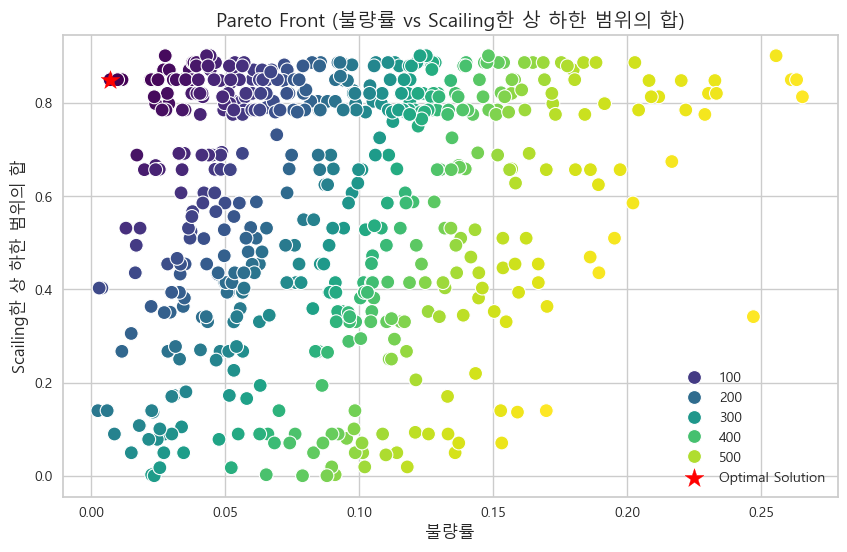

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 파레토 해집합 시각화: Defect_Rate vs Cost
plt.figure(figsize=(10, 6))

# 파레토 해집합을 산점도로 그리기
sns.scatterplot(x="Defect_Rate", y="Cost", data=pareto_df, hue="Rank", palette="viridis", s=100)

# 최적 타협 해 강조 (최고 점수)
optimal_solution = pareto_df.sort_values(by="TOPSIS_Score", ascending=False).iloc[0]
plt.scatter(optimal_solution["Defect_Rate"], optimal_solution["Cost"], color='red', s=200, marker='*', label="Optimal Solution")

# 레이블과 타이틀 설정
plt.title("Pareto Front (불량률 vs Scailing한 상 하한 범위의 합)", fontsize=14)
plt.xlabel("불량률", fontsize=12)
plt.ylabel("Scailing한 상 하한 범위의 합", fontsize=12)
plt.legend()
plt.show()


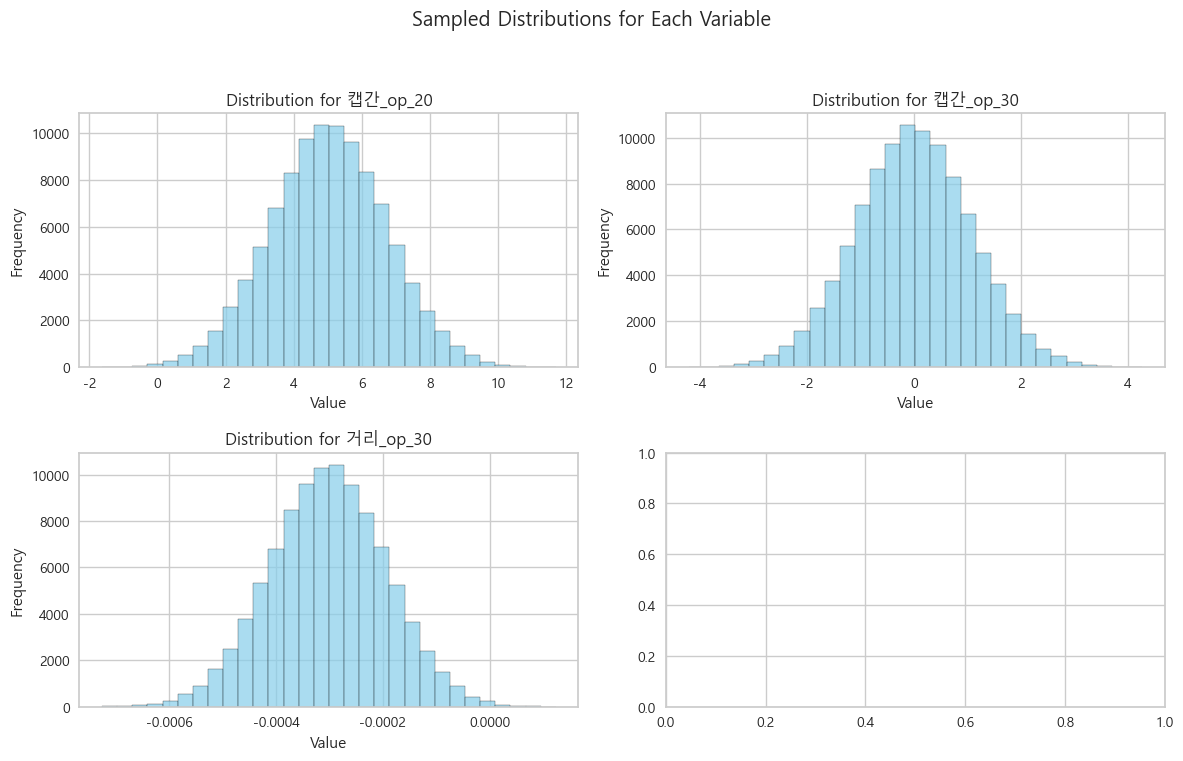

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# 데이터 수정 함수에 포함된 샘플링 함수
def sample_from_bounds(bounds, size=100000):
    samples = {}
    for col, (plus_sigma, minus_sigma) in bounds.items():
        # 각 분포의 평균과 표준 편차 설정
        mean = (plus_sigma + minus_sigma) / 2
        std_dev = (plus_sigma - minus_sigma) / 8

        # 상한과 하한 정의
        a, b = (minus_sigma - mean) / std_dev, (plus_sigma - mean) / std_dev
        samples[col] = truncnorm.rvs(a, b, loc=mean, scale=std_dev, size=size)
        
    return samples

# 테스트용 bounds 생성 (각 변수에 대해 상한, 하한 설정)
bounds = {
    '캡간_op_20': (11.8, -1.75),
    '캡간_op_30': (4.3, -4.3),
    '거리_op_30': (0.00013, -0.000735),
}

# 각 변수에 대한 샘플링 데이터 생성
sampled_values = sample_from_bounds(bounds)

# 분포 시각화
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Sampled Distributions for Each Variable')

# 각 변수의 분포를 서브플롯에 그림
for i, (col, values) in enumerate(sampled_values.items()):
    ax = axs[i // 2, i % 2]
    ax.hist(values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution for {col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
